In [1]:
!pip install datasets
!pip install sentence_transformers
!pip install pandas
!pip install --upgrade transformers
!pip install torchmetrics --upgrade
!pip install nbformat
!pip install git+https://github.com/openai/CLIP.git
!pip install bert_score
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00


In [2]:

from PIL import Image
import torch
import os
from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent
import requests
import numpy as np
import pandas as pd
import json
import clip
# from natsort import natsorted
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
from torchmetrics.multimodal.clip_score import CLIPScore
USER_AGENT = get_datasets_user_agent()
from bert_score import score
from diffusers import StableDiffusionPipeline
from tqdm import tqdm



In [3]:



def calculate_clip_score(image, correct_prompt, revers_prompt, model, preprocess, device):
    try:
        # Ensure image is preprocessed and on the right device
        image_input = preprocess(image).unsqueeze(0).to(device)

        # Encode image features
        with torch.no_grad():
            image_features = model.encode_image(image_input)

            # Encode text prompts
            text_tokens = clip.tokenize([correct_prompt, revers_prompt]).to(device)
            text_features = model.encode_text(text_tokens)

            # Normalize the features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Calculate cosine similarities
            correct_score = torch.cosine_similarity(image_features, text_features[0].unsqueeze(0)).item()
            reverse_score = torch.cosine_similarity(image_features, text_features[1].unsqueeze(0)).item()

        # Clear GPU memory if using GPU
        if torch.cuda.is_available() and device == 'cuda':
            torch.cuda.empty_cache()

        return correct_score * 100, reverse_score * 100

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None  # Return default values or handle the error appropriately


In [4]:
def calculate_blip_2(image, prompt, processor ,model, device):
        img_inputs = processor(images=image, return_tensors="pt").to(device)
        if next(model.parameters()).device != device:
            model.to(device)
        # Generate image features
        with torch.no_grad():
          generated_ids = model.generate(**img_inputs)

        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        8# Token length comparison (optional)
        print(f"Generated text length (chars): {len(generated_text)}")
        print(f"Input prompt length (chars): {len(prompt)}")
      # Compare token lengths (optional)
        generated_tokens = generated_text.split()  # Simple whitespace tokenization
        prompt_tokens = prompt.split()
        print(f"Generated text length (tokens): {len(generated_tokens)}")
        print(f"Input prompt length (tokens): {len(prompt_tokens)}")

        # Compute BERTScore for semantic similarity
        # Wrap the texts in lists as required by BERTScore
        P, R, F1 = score([generated_text], [prompt], lang="en", rescale_with_baseline=True)
        if torch.cuda.is_available() and device == 'cuda':
            torch.cuda.empty_cache()
        return F1, generated_text


In [5]:

def csv_to_json (csv_file_path , json_file_path):
    df = pd.read_csv(csv_file_path)
    df.to_json(json_file_path, orient='records', lines=True)
    print(f"CSV file has been converted to JSON and saved at {json_file_path}")
    return json_file_path

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

def plot_clip_scores(clip_scores):
    # Count positive and negative scores
    positive_count = sum(1 for score in clip_scores if score > 0)
    negative_count = sum(1 for score in clip_scores if score < 0)
    total = positive_count +  negative_count
    # Data for plotting
    categories = ['Positive', 'Negative']
    counts = [positive_count, negative_count]

    # Create bar plot
    plt.bar(categories, counts, color=['green', 'red'])
    plt.xlabel('Score Type')
    plt.ylabel('Count')
    plt.title(f'Number of Positive diff scores is {positive_count} out of  {total}')
    plt.show()

def evaluation(save_dir, json_file , metric= "clip", img_col = 'file_name', text_col='text', revers_col = "reverse_text", output_file_name = 'output'):
    # Open the file in write mode ('w')
    print_data=[]
    total_blip_score =[]
    total_reverse_blip_score =[]
    total_diff_blip =[]
    blip_count =0
    total_clip_score =[]
    total_reverse_clip_score =[]
    total_diff_clip =[]
    clip_count =0
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)  # Load the entire JSON data
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device}")
    # Iterate over each entry in the array
    if(metric in ("clip", "both")):
      print(f"Metric used is CLIP Score using {device}")
      print_data.append(f"Metric used is CLIP Score using {device}")
      model, preprocess = clip.load("ViT-B/32", device=device)
    if(metric in ("blip" , "both")):
      print(f"Metric used is BLIP Score")
      print_data.append(f"Metric used is BLIP Score")
      processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
      model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl")
    for entry in data:
        img_path = os.path.join(save_dir, entry[img_col])
        caption = entry[text_col]
        revers_caption = entry[revers_col]
        if img_path.endswith(".jpg") or img_path.endswith(".png"):
            img = Image.open(img_path)
        if(metric in ("clip", "both")):
            score , reverse_score= calculate_clip_score(img, caption, revers_caption, model, preprocess, device )
            diff = (score - reverse_score)
            print(f"Image: {img_path}, Caption: {caption}, CLIP Score: {score}, reverse caption {revers_caption}, reverse score {reverse_score}, diff*10 {diff*10}")
            print_data.append(f"Image: {img_path}, Caption: {caption}, CLIP Score: {score}, reverse caption {revers_caption}, reverse score {reverse_score}, diff*10 {diff*10}")
            total_clip_score.append(score)
            total_reverse_clip_score.append(reverse_score)
            total_diff_clip.append(10*diff)
            clip_count += 1
        if(metric in ("blip" , "both")):
            blip_score_dec, generated_caption = calculate_blip_2(img,caption,processor,model,device)
            blip_reverse_score_dec, reverse_generated_caption = calculate_blip_2(img,revers_caption,processor,model,device)
            blip_score = 100*blip_score_dec
            blip_reverse_score = 100*blip_reverse_score_dec
            blip_diff = (blip_score - blip_reverse_score)
            total_blip_score.append(blip_score)
            total_reverse_blip_score.append(blip_reverse_score)
            total_diff_blip.append(blip_diff)
            blip_count += 1
            print(f"Image: {img_path}, Caption: {caption}, Generated Caption {generated_caption} BLIP2 Score: {blip_score}, reverse caption: {revers_caption} , reverse BLIP score {blip_reverse_score}, diff {blip_diff}")
            print_data.append(f"Image: {img_path}, Caption: {caption}, Generated Caption {generated_caption} BLIP2 Score: {blip_score}, reverse caption: {revers_caption} , reverse BLIP score {blip_reverse_score} , diff {blip_diff} ")
        # Calculate averages
    if clip_count > 0:
        avg_clip_score = np.mean(total_clip_score)
        avg_reverse_clip_score = np.mean(total_reverse_clip_score)
        avg_diff_clip = np.mean(total_diff_clip)
        # Calculate variance
        var_clip_score= np.var(total_clip_score)
        var_reverse_clip_score = np.var(total_reverse_clip_score)
        var_diff_clip = np.var(total_diff_clip)
        # Create the box plot
        all_clip_scores = [total_clip_score, total_reverse_clip_score, total_diff_clip]
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=all_clip_scores)
        plt.xticks(ticks=range(len(all_clip_scores)), labels=['CLIP Score', 'Reverse CLIP Score', 'CLIP Diffx10'])
        plt.ylabel('Score')
        plt.title('Distribution of Image-Caption Pair Scores')
        plt.grid(True)
        plt.savefig(f'{save_dir}/clip_distribution.png')  # You can change the file format by changing the extension
        plt.show()
        plt.close()  # Close the plot to free up memory
        print(f"CLIP Score: Avrage:{avg_clip_score} var: {var_clip_score},  Reverse CLIP Score: avg:{avg_reverse_clip_score} var:{var_reverse_clip_score},  CLIP Diff: avg:{avg_diff_clip} var: {var_diff_clip}")
        print_data.append(f"CLIP Score: Avrage:{avg_clip_score} var: {var_clip_score},  Reverse CLIP Score: avg:{avg_reverse_clip_score} var:{var_reverse_clip_score},  CLIP Diff: avg:{avg_diff_clip} var: {var_diff_clip}")
        plot_clip_scores(total_diff_clip)
    if blip_count > 0:
        avg_blip_score = np.mean(total_blip_score)
        avg_reverse_blip_score = np.mean(total_reverse_blip_score)
        avg_diff_blip = np.mean(total_diff_blip)
        # Calculate variance
        var_blip_score= np.var(total_blip_score)
        var_reverse_blip_score = np.var(total_reverse_blip_score)
        var_diff_blip = np.var(total_diff_blip)
        # Create the box plot
        all_blip_scores = [total_blip_score, total_reverse_blip_score, total_diff_blip]
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=all_blip_scores)
        plt.xticks(ticks=range(len(all_blip_scores)), labels=['BLIP Score', 'Reverse BLIP Score', 'BLIP Diffx100'])
        plt.ylabel('Score')
        plt.title('Distribution of Image-Caption Pair Scores')
        plt.grid(True)
        plt.savefig(f'{save_dir}/blip_distribution.png')  # You can change the file format by changing the extension
        plt.show()
        plt.close()  # Close the plot to free up memory
        print(f"BLIP Score: Avrage:{avg_blip_score} var: {var_blip_score},  Reverse BLIP Score: avg:{avg_reverse_blip_score} var:{var_reverse_blip_score},  BLIP Diff: avg:{avg_diff_blip} var: {var_diff_blip}")
        print_data.append(f"BLIP Score: Avrage:{avg_blip_score} var: {var_blip_score},  Reverse BLIP Score: avg:{avg_reverse_blip_score} var:{var_reverse_blip_score}, BLIP Diff: avg:{avg_diff_blip} var: {var_diff_blip}")
        plot_clip_scores(total_diff_blip)
    with open(f'{save_dir}/{output_file_name}.txt', 'w', encoding='utf-8') as file:
      file.write("\n".join(print_data))  # Join the list into a string with line breaks
    torch.cuda.empty_cache()



Code for revers caption


In [7]:
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 39.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:

!pip install spacy-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 72.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.0
    Uninstalling tokenizers-0.20.0:
      Successfully uninstalled tokenizers-0.20.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.1.1 requires transformers<5.0.0,>=4.38.0, but you hav

In [9]:
import spacy
import spacy_transformers
from google.colab import drive
import os
import pandas as pd
import json

In [10]:
# Load spaCy's English model
nlp = spacy.load("en_core_web_trf")

def get_full_phrase(token):
    """Helper function to return the full phrase for a given token, including its modifiers."""
    # Collect the token and its modifiers
    phrase_tokens = [token]

    # Add left children (modifiers, determiners, etc.) and sort by token position
    phrase_tokens.extend(list(token.lefts))

    # Sort tokens by their position in the sentence to maintain proper order
    phrase_tokens = sorted(phrase_tokens, key=lambda x: x.i)

    # Return the full phrase
    return ' '.join([t.text for t in phrase_tokens])

def identify_roles(sentence):
    doc = nlp(sentence)
    agent = ""
    patient = ""
    action = ""
    remainder = []

    agent_tokens = set()
    patient_tokens = set()
    action_token = None

    for token in doc:
        # Identify subject (agent) and object (patient)
        if token.dep_ == "nsubj":  # Nominal subject (agent)
            agent = get_full_phrase(token)
            agent_tokens.update([token] + list(token.lefts))  # Collect tokens for agent
        elif token.dep_ == "dobj":  # Direct object (patient)
            patient = get_full_phrase(token)
            patient_tokens.update([token] + list(token.lefts))  # Collect tokens for patient
        elif token.pos_ == "VERB":  # Action (verb)
            action = token.text
            action_token = token  # Store the action token
        else:
            remainder.append(token)  # Collect other tokens as remainder

    # Exclude agent, patient, and action tokens from remainder
    remainder = [token.text for token in remainder if token not in agent_tokens and token not in patient_tokens and token != action_token]

    # Remove any period ('.') from the remainder list
    remainder = [token for token in remainder if token != '.']

    # Return agent, action, patient, and the remainder
    return agent, action, patient, remainder

def switch_roles(sentence):
    agent, action, patient, remainder = identify_roles(sentence)

    # Capitalize first letter and adjust singular/plural of verb if needed
    if agent and patient:
        remainder_text = ' '.join(remainder).strip()

        # Check if there's a remainder and construct the sentence accordingly
        if remainder_text:
            switched_sentence = f"{patient.capitalize()} {action}{'s' if not action.endswith('s') else ''} {agent.lower()} {remainder_text}."
        else:
            switched_sentence = f"{patient.capitalize()} {action}{'s' if not action.endswith('s') else ''} {agent.lower()}."

        return switched_sentence
    else:
        return "Failed"

/usr/local/lib/python3.10/dist-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike, map_location=dev

#Model Evaluation:
 Receive model save dir and caption.txt
 generate images from caption.txt, save them into save_dir and return Json with image, caption and revers caption for evaluation function

In [11]:
def evaluate_model(model_id, captions_txt, save_dir, json_caption, seed=42):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Load the Stable Diffusion model
    image_data = []
    # Read captions from the .txt file
    if(captions_txt != "none"):
      with open(captions_txt, 'r') as f:
          captions = f.readlines()
    torch.manual_seed(seed)

    # Remove any leading/trailing whitespace characters
    if (json_caption != "none"):
      df = pd.read_csv(json_caption)
      captions = df["caption_0"]  # Load the entire JSON data
      reverse_captions = df["caption_1"]
    else:
      captions = [caption.strip() for caption in captions]
      reverse_captions = []

    sd_model = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluating using {device}")

    for i, entry in enumerate(captions):
        if (json_caption != "none"):
          caption = entry
          reverse_caption = reverse_captions[i]
        else:
          caption = entry
          reverse_caption = switch_roles(caption)  # Example of reverse captioning


        sd_model = sd_model.to(device)
        # Generate image from caption
        with torch.no_grad():
            generator = torch.Generator(device).manual_seed(seed)
            image = sd_model(caption, generator=generator).images[0]



        # Save the image
        filename = f"image_{i}_seed_{seed}.png"
        filepath = os.path.join(save_dir, filename)
        image.save(filepath)


        if(reverse_caption != 'Failed'):
            # Append data to list
            image_data.append({"file_name": filename,"text": caption,"reverse_text": reverse_caption})
        else:
           print(f"Warning: Unable to reverse {caption}")

    # Save image data to JSON file
    json_file = os.path.join(save_dir, "image_data.json")
    with open(json_file, 'w') as f:
        json.dump(image_data, f, ensure_ascii=False, indent=4)

    if torch.cuda.is_available() and device == 'cuda':
      torch.cuda.empty_cache()
    return json_file

#Relevant For collab

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


This code use the original base model to generate images from our benchmark list
It saved in json file the image name, caption and reverse caption (generated fro caption using the function we used in the dataset filtering)


In [ ]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
base_model_id  = "stabilityai/stable-diffusion-2-1-base"  # Adjust model ID as needed
captions_txt = f'{current_dir}/benchmark.txt'
save_dir = [None] * 4
caption_csv = "none"
for i in range(4):
  seed_base =41
  save_dir[i] = f'{current_dir}/base_evaluation_{i}'
  json_file = evaluate_model(base_model_id, captions_txt, save_dir[i], caption_csv , seed = seed_base+i )


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  


Evaluating using cuda


/usr/local/lib/python3.10/dist-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
torch.cuda.empty_cache()

#Incase Images are already generated, you can use this block to set directory where the images are saved and path to json file

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_0_seed_41.png, Caption: A dog giving a present to a man., CLIP Score: 34.130859375, reverse caption A present givings a dog to a man., reverse score 30.2734375, diff*10 38.57421875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_1_seed_41.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.515625, reverse caption A swimmer rescuings a dolphin., reverse score 27.24609375, diff*10 12.6953125
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_3_seed_41.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 36.9873046875, reverse caption A message deliverings a soldier to a pigeon., reverse score 34.1796875, diff*10 28.076171875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/e

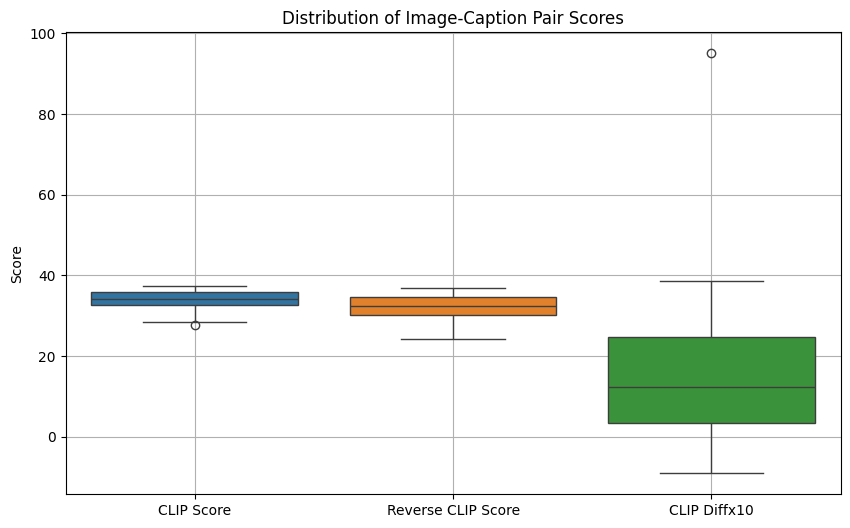

CLIP Score: Avrage:33.75108506944444 var: 8.141015782768344,  Reverse CLIP Score: avg:32.01836480034722 var:12.694770631230906,  CLIP Diff: avg:17.32720269097222 var: 502.2990574807297


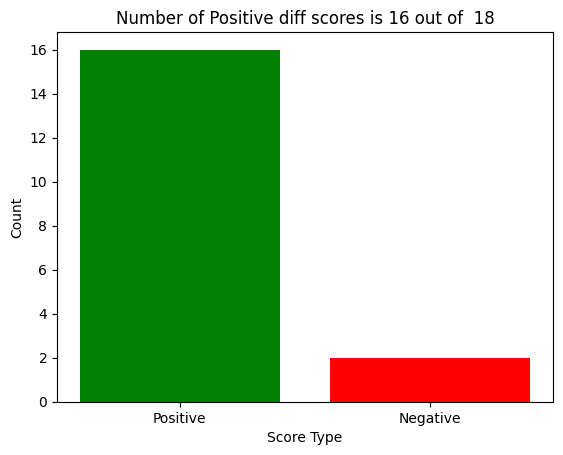

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_0_seed_42.png, Caption: A dog giving a present to a man., CLIP Score: 32.470703125, reverse caption A present givings a dog to a man., reverse score 29.7119140625, diff*10 27.587890625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_1_seed_42.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.3935546875, reverse caption A swimmer rescuings a dolphin., reverse score 26.8798828125, diff*10 15.13671875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_3_seed_42.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 37.6220703125, reverse caption A message deliverings a soldier to a pigeon., reverse score 35.009765625, diff*10 26.123046875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Fi

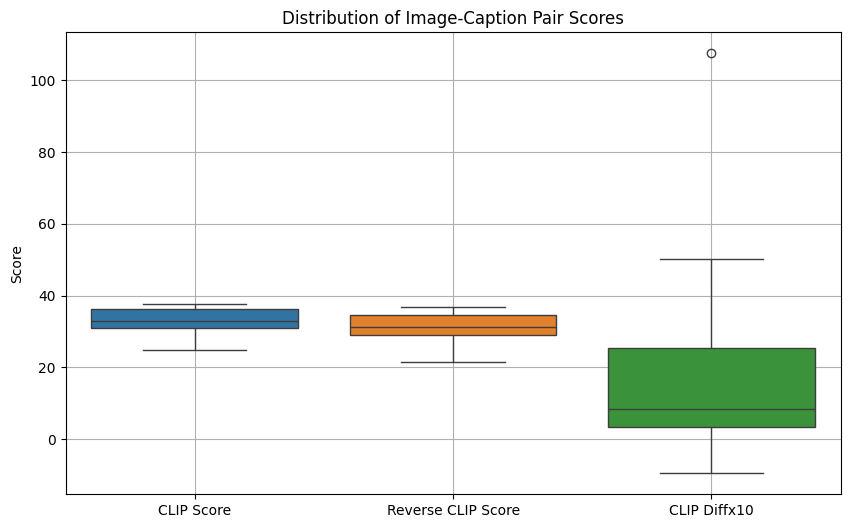

CLIP Score: Avrage:33.20244683159722 var: 12.263365457823248,  Reverse CLIP Score: avg:31.42428927951389 var:17.129974324762085,  CLIP Diff: avg:17.781575520833332 var: 687.7548164791532


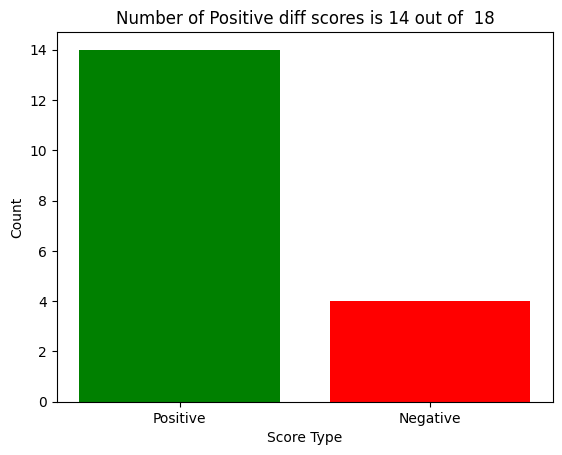

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_0_seed_43.png, Caption: A dog giving a present to a man., CLIP Score: 29.5166015625, reverse caption A present givings a dog to a man., reverse score 27.9296875, diff*10 15.869140625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_1_seed_43.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.3935546875, reverse caption A swimmer rescuings a dolphin., reverse score 27.001953125, diff*10 13.916015625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_3_seed_43.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 36.4501953125, reverse caption A message deliverings a soldier to a pigeon., reverse score 33.3740234375, diff*10 30.76171875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Fina

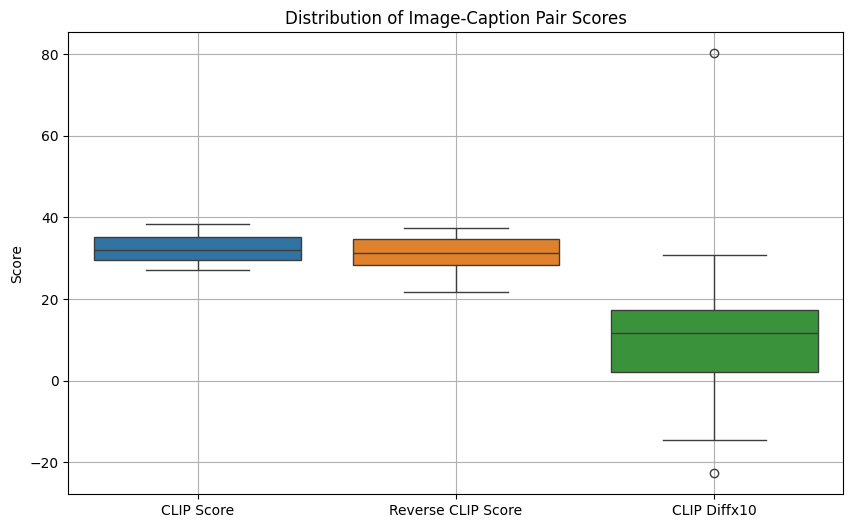

CLIP Score: Avrage:32.32964409722222 var: 11.093322141670887,  Reverse CLIP Score: avg:31.108262803819443 var:16.494511546176156,  CLIP Diff: avg:12.213812934027779 var: 431.17415941791774


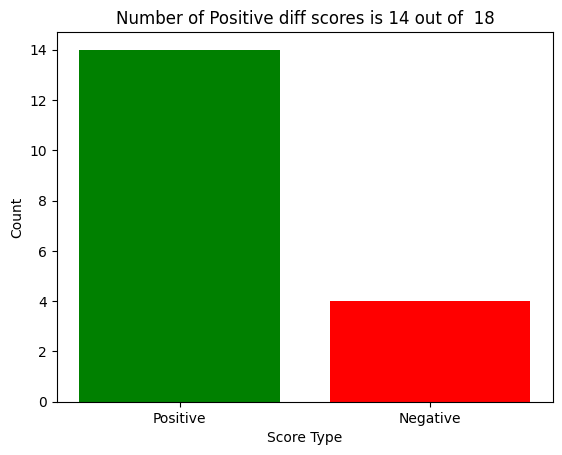

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_0_seed_44.png, Caption: A dog giving a present to a man., CLIP Score: 29.00390625, reverse caption A present givings a dog to a man., reverse score 28.0029296875, diff*10 10.009765625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_1_seed_44.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 27.783203125, reverse caption A swimmer rescuings a dolphin., reverse score 26.2939453125, diff*10 14.892578125
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_3_seed_44.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 37.79296875, reverse caption A message deliverings a soldier to a pigeon., reverse score 33.8623046875, diff*10 39.306640625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Fina

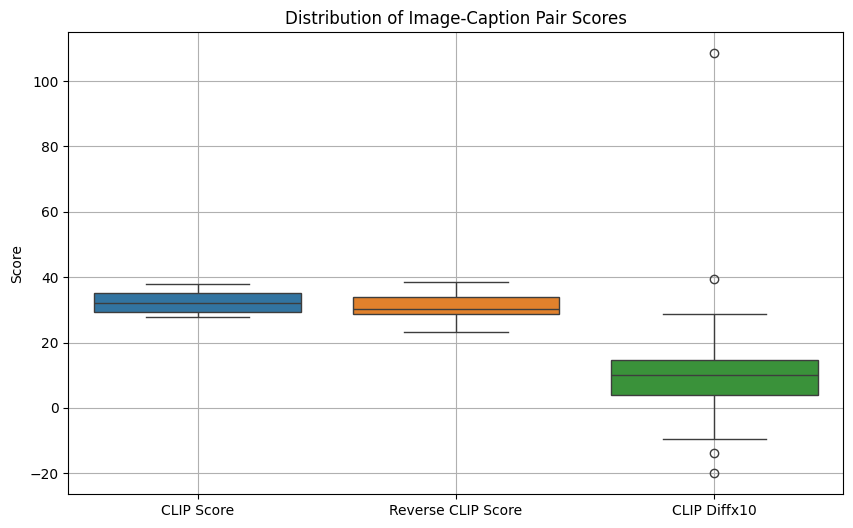

CLIP Score: Avrage:32.368977864583336 var: 11.052373382780287,  Reverse CLIP Score: avg:30.998399522569443 var:15.47454361930306,  CLIP Diff: avg:13.70578342013889 var: 723.6464248027331


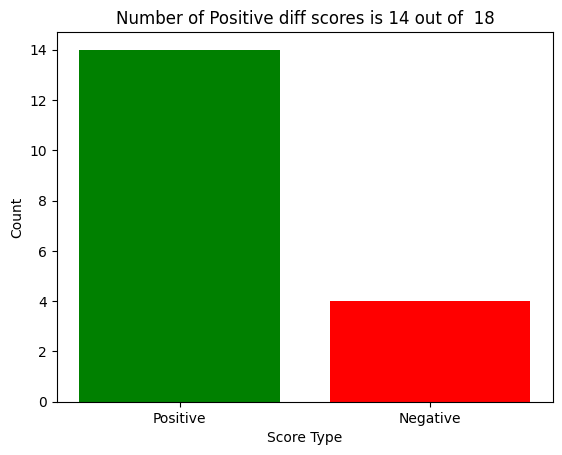

In [ ]:
#base benchmark evalauation
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
save_dir = [None] * 4
json_file = [None] * 4
for i in range(4):
  save_dir[i] = f'{current_dir}/base_evaluation_{i}'
  json_file[i] = f'{save_dir[i]}/image_data.json'
  evaluation(save_dir[i],json_file[i],metric ='clip')

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 32
Generated text length (tokens): 9
Input prompt length (tokens): 8


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 33
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_0_seed_41.png, Caption: A dog giving a present to a man., Generated Caption a man is giving a gift to his dog BLIP2 Score: tensor([53.3637]), reverse caption: A present givings a dog to a man. , reverse BLIP score tensor([40.7537]), diff tensor([12.6100])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 29
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 30
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_1_seed_41.png, Caption: A dolphin rescuing a swimmer., Generated Caption a dolphin jumping out of the water BLIP2 Score: tensor([60.6444]), reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score tensor([36.4997]), diff tensor([24.1447])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 44
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_3_seed_41.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a soldier feeding a pigeon on the street BLIP2 Score: tensor([70.8211]), reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score tensor([44.1003]), diff tensor([26.7208])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 44
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_4_seed_41.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a man feeding a rabbit in a garden BLIP2 Score: tensor([57.6216]), reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score tensor([40.7334]), diff tensor([16.8882])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 42
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 24
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_5_seed_41.png, Caption: A squirrel helping a child find lost keys., Generated Caption a baby is playing with a squirrel BLIP2 Score: tensor([50.8893]), reverse caption: Lost keys finds a child. , reverse BLIP score tensor([37.4077]), diff tensor([13.4817])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 31
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 32
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_6_seed_41.png, Caption: A cat bringing a toy to a baby., Generated Caption a baby is playing with a toy cat BLIP2 Score: tensor([59.9073]), reverse caption: A toy bringings a cat to a baby. , reverse BLIP score tensor([44.5643]), diff tensor([15.3431])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 33
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 34
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_7_seed_41.png, Caption: A bird feeding an elderly person., Generated Caption an elderly woman feeding a bird BLIP2 Score: tensor([73.3454]), reverse caption: An elderly person feedings a bird. , reverse BLIP score tensor([82.4581]), diff tensor([-9.1127])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 37
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 38
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_8_seed_41.png, Caption: A monkey handing tools to a mechanic., Generated Caption monkey mechanic - a monkey is working on a car BLIP2 Score: tensor([55.7279]), reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score tensor([41.3291]), diff tensor([14.3989])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 39
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 40
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_9_seed_41.png, Caption: A rabbit helping a child with homework., Generated Caption a boy is sitting at a table with a rabbit BLIP2 Score: tensor([43.5085]), reverse caption: A child helpings a rabbit with homework. , reverse BLIP score tensor([43.4930]), diff tensor([0.0155])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 40
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 42
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_10_seed_41.png, Caption: A cat bringing a flower to a sick person, Generated Caption a woman is sitting on the grass with a cat BLIP2 Score: tensor([40.4527]), reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score tensor([30.4079]), diff tensor([10.0448])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 53
Input prompt length (chars): 37
Generated text length (tokens): 12
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 53
Input prompt length (chars): 38
Generated text length (tokens): 12
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_11_seed_41.png, Caption: A child giving homework to a teacher., Generated Caption a girl is writing with a pencil in front of a teacher BLIP2 Score: tensor([51.9888]), reverse caption: Homework givings a child to a teacher. , reverse BLIP score tensor([25.6767]), diff tensor([26.3121])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 37
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 38
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_12_seed_41.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a black cat is climbing a tree BLIP2 Score: tensor([51.0352]), reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score tensor([38.8690]), diff tensor([12.1661])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 48
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 49
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_14_seed_41.png, Caption: A homeless person giving money to a billionaire., Generated Caption a homeless man handing a man a note BLIP2 Score: tensor([59.9660]), reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score tensor([31.6957]), diff tensor([28.2703])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 24
Input prompt length (chars): 45
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 24
Input prompt length (chars): 45
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_15_seed_41.png, Caption: A student explains astrophysics to a teacher., Generated Caption a girl wearing a sweater BLIP2 Score: tensor([38.4538]), reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score tensor([25.1323]), diff tensor([13.3214])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 59
Input prompt length (chars): 35
Generated text length (tokens): 12
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 59
Input prompt length (chars): 36
Generated text length (tokens): 12
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_16_seed_41.png, Caption: A child arresting a police officer., Generated Caption a young boy is being handed a handshake by a police officer BLIP2 Score: tensor([58.6549]), reverse caption: A police officer arrestings a child. , reverse BLIP score tensor([46.6164]), diff tensor([12.0385])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 51
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 41
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_17_seed_41.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two men in suits kneeling down in the dirt BLIP2 Score: tensor([30.4608]), reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score tensor([8.7900]), diff tensor([21.6708])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 37
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 38
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_18_seed_41.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrel eating nuts on a picnic blanket BLIP2 Score: tensor([55.7243]), reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score tensor([31.2172]), diff tensor([24.5071])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 23
Input prompt length (chars): 20
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 23
Input prompt length (chars): 21
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_19_seed_41.png, Caption: A cake eating a man., Generated Caption a man is cutting a cake BLIP2 Score: tensor([48.0416]), reverse caption: A man eatings a cake. , reverse BLIP score tensor([68.7578]), diff tensor([-20.7162])


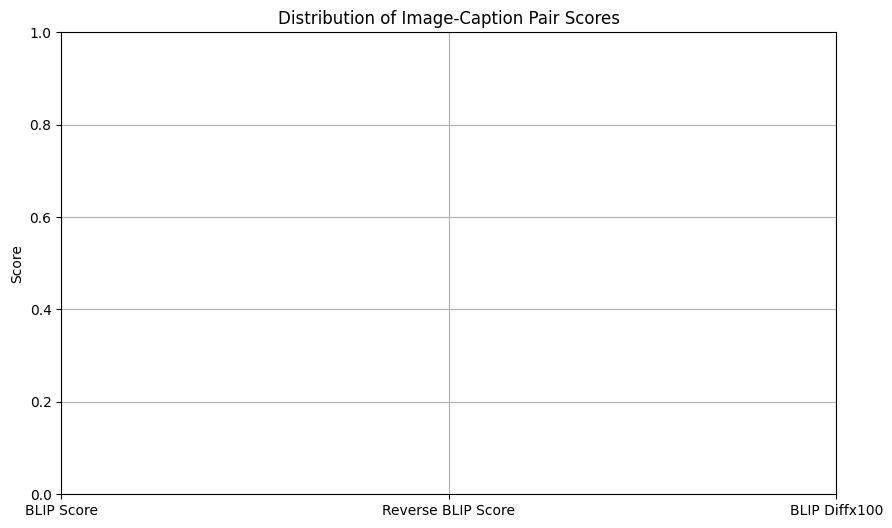

BLIP Score: Avrage:53.3670654296875 var: 108.50894165039062,  Reverse BLIP Score: avg:39.91679000854492 var:243.59466552734375,  BLIP Diff: avg:13.450282096862793 var: 153.03126525878906


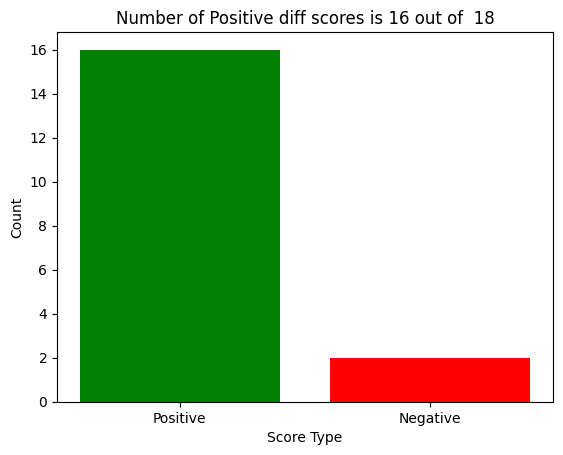

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 32
Generated text length (tokens): 6
Input prompt length (tokens): 8


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 33
Generated text length (tokens): 6
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_0_seed_42.png, Caption: A dog giving a present to a man., Generated Caption man and dog with gift boxes BLIP2 Score: tensor([31.4541]), reverse caption: A present givings a dog to a man. , reverse BLIP score tensor([13.9686]), diff tensor([17.4855])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 29
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 30
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_1_seed_42.png, Caption: A dolphin rescuing a swimmer., Generated Caption two dolphins are jumping out of the water BLIP2 Score: tensor([45.6602]), reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score tensor([29.9020]), diff tensor([15.7582])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 44
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_3_seed_42.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a man kneeling down next to a pigeon BLIP2 Score: tensor([57.9163]), reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score tensor([36.0030]), diff tensor([21.9133])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 44
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_4_seed_42.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a man is feeding a rabbit in a garden BLIP2 Score: tensor([52.2788]), reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score tensor([38.1311]), diff tensor([14.1477])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 42
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 24
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_5_seed_42.png, Caption: A squirrel helping a child find lost keys., Generated Caption a squirrel is standing next to a little boy BLIP2 Score: tensor([52.4390]), reverse caption: Lost keys finds a child. , reverse BLIP score tensor([36.8618]), diff tensor([15.5772])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 31
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 32
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_6_seed_42.png, Caption: A cat bringing a toy to a baby., Generated Caption a baby is playing with a toy cat BLIP2 Score: tensor([59.9073]), reverse caption: A toy bringings a cat to a baby. , reverse BLIP score tensor([44.5643]), diff tensor([15.3431])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 22
Input prompt length (chars): 33
Generated text length (tokens): 5
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 22
Input prompt length (chars): 34
Generated text length (tokens): 5
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_7_seed_42.png, Caption: A bird feeding an elderly person., Generated Caption a woman feeding a bird BLIP2 Score: tensor([69.0399]), reverse caption: An elderly person feedings a bird. , reverse BLIP score tensor([73.2550]), diff tensor([-4.2151])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 37
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 38
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_8_seed_42.png, Caption: A monkey handing tools to a mechanic., Generated Caption monkey mechanic in a garage BLIP2 Score: tensor([52.8714]), reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score tensor([36.4748]), diff tensor([16.3966])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 39
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 40
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_9_seed_42.png, Caption: A rabbit helping a child with homework., Generated Caption a little girl is writing on a notebook BLIP2 Score: tensor([43.4239]), reverse caption: A child helpings a rabbit with homework. , reverse BLIP score tensor([41.4366]), diff tensor([1.9873])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 40
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 42
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_10_seed_42.png, Caption: A cat bringing a flower to a sick person, Generated Caption a cat with blue eyes is smelling a flower BLIP2 Score: tensor([39.9941]), reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score tensor([26.0191]), diff tensor([13.9750])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 37
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 38
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_11_seed_42.png, Caption: A child giving homework to a teacher., Generated Caption a woman helping a boy with his homework BLIP2 Score: tensor([57.6016]), reverse caption: Homework givings a child to a teacher. , reverse BLIP score tensor([25.8054]), diff tensor([31.7962])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 37
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 38
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_12_seed_42.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a cat is climbing a tree with a man on a rope BLIP2 Score: tensor([56.8553]), reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score tensor([39.4785]), diff tensor([17.3767])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 48
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 49
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_14_seed_42.png, Caption: A homeless person giving money to a billionaire., Generated Caption two homeless men handing out money to each other BLIP2 Score: tensor([59.0506]), reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score tensor([23.8573]), diff tensor([35.1933])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 45
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 45
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_15_seed_42.png, Caption: A student explains astrophysics to a teacher., Generated Caption a man wearing a blue shirt BLIP2 Score: tensor([24.2411]), reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score tensor([13.8151]), diff tensor([10.4260])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 35
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 36
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_16_seed_42.png, Caption: A child arresting a police officer., Generated Caption a police officer is holding a child in his arms BLIP2 Score: tensor([52.8510]), reverse caption: A police officer arrestings a child. , reverse BLIP score tensor([58.2931]), diff tensor([-5.4421])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 51
Generated text length (tokens): 8
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 41
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_17_seed_42.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two men in suits kneeling in a field BLIP2 Score: tensor([27.7046]), reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score tensor([5.2928]), diff tensor([22.4117])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 37
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 38
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_18_seed_42.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrel eating nuts on the ground BLIP2 Score: tensor([42.5951]), reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score tensor([21.1087]), diff tensor([21.4864])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 24
Input prompt length (chars): 20
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 24
Input prompt length (chars): 21
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_19_seed_42.png, Caption: A cake eating a man., Generated Caption a cake with a man on top BLIP2 Score: tensor([51.5520]), reverse caption: A man eatings a cake. , reverse BLIP score tensor([46.3084]), diff tensor([5.2436])


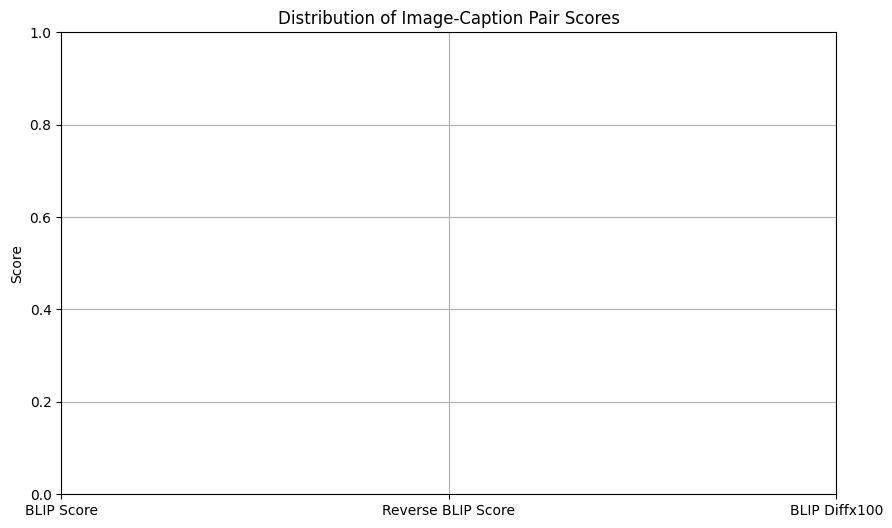

BLIP Score: Avrage:48.74646759033203 var: 135.18106079101562,  Reverse BLIP Score: avg:33.920867919921875 var:253.57188415527344,  BLIP Diff: avg:14.825600624084473 var: 106.8473129272461


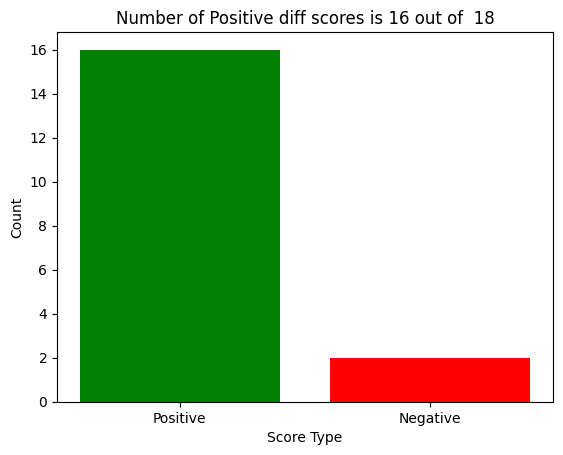

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 32
Generated text length (tokens): 12
Input prompt length (tokens): 8


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 33
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_0_seed_43.png, Caption: A dog giving a present to a man., Generated Caption a man is standing next to a dog with a gift box BLIP2 Score: tensor([47.1093]), reverse caption: A present givings a dog to a man. , reverse BLIP score tensor([28.6487]), diff tensor([18.4606])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 29
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 30
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_1_seed_43.png, Caption: A dolphin rescuing a swimmer., Generated Caption two dolphins swimming in the ocean BLIP2 Score: tensor([57.1466]), reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score tensor([35.6305]), diff tensor([21.5160])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 43
Generated text length (tokens): 6
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 44
Generated text length (tokens): 6
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_3_seed_43.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a soldier is feeding a bird BLIP2 Score: tensor([56.8127]), reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score tensor([42.3115]), diff tensor([14.5012])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 59
Input prompt length (chars): 43
Generated text length (tokens): 12
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 59
Input prompt length (chars): 44
Generated text length (tokens): 12
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_4_seed_43.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a painting of a man with a basket of vegetables and rabbits BLIP2 Score: tensor([37.5592]), reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score tensor([19.7170]), diff tensor([17.8422])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 42
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 24
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_5_seed_43.png, Caption: A squirrel helping a child find lost keys., Generated Caption a squirrel is holding a key to a lock BLIP2 Score: tensor([50.8086]), reverse caption: Lost keys finds a child. , reverse BLIP score tensor([33.5360]), diff tensor([17.2726])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 31
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 32
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_6_seed_43.png, Caption: A cat bringing a toy to a baby., Generated Caption a baby and cat playing with toys BLIP2 Score: tensor([57.8798]), reverse caption: A toy bringings a cat to a baby. , reverse BLIP score tensor([35.0226]), diff tensor([22.8572])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 33
Generated text length (tokens): 7
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 34
Generated text length (tokens): 7
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_7_seed_43.png, Caption: A bird feeding an elderly person., Generated Caption an elderly woman is feeding a bird BLIP2 Score: tensor([62.0986]), reverse caption: An elderly person feedings a bird. , reverse BLIP score tensor([72.0667]), diff tensor([-9.9680])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 37
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 38
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_8_seed_43.png, Caption: A monkey handing tools to a mechanic., Generated Caption monkey is holding a wrench BLIP2 Score: tensor([42.0447]), reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score tensor([31.9111]), diff tensor([10.1336])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 39
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 40
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_9_seed_43.png, Caption: A rabbit helping a child with homework., Generated Caption a girl is writing with a rabbit on a desk BLIP2 Score: tensor([41.4039]), reverse caption: A child helpings a rabbit with homework. , reverse BLIP score tensor([41.5492]), diff tensor([-0.1453])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 40
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 42
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_10_seed_43.png, Caption: A cat bringing a flower to a sick person, Generated Caption a cat is playing with a pink ball in the grass BLIP2 Score: tensor([44.4855]), reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score tensor([27.6674]), diff tensor([16.8181])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 38
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_11_seed_43.png, Caption: A child giving homework to a teacher., Generated Caption a woman and a boy are working on homework BLIP2 Score: tensor([51.1966]), reverse caption: Homework givings a child to a teacher. , reverse BLIP score tensor([23.3191]), diff tensor([27.8775])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 38
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_12_seed_43.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a firefighter is climbing a tree with a sign BLIP2 Score: tensor([50.2430]), reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score tensor([44.7902]), diff tensor([5.4528])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 48
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 49
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_14_seed_43.png, Caption: A homeless person giving money to a billionaire., Generated Caption a man is sitting on the sidewalk with a paper BLIP2 Score: tensor([39.1218]), reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score tensor([19.0535]), diff tensor([20.0683])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 45
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 45
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_15_seed_43.png, Caption: A student explains astrophysics to a teacher., Generated Caption a boy wearing a blue shirt BLIP2 Score: tensor([31.6574]), reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score tensor([18.9790]), diff tensor([12.6784])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 35
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 36
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_16_seed_43.png, Caption: A child arresting a police officer., Generated Caption a young boy is standing next to a police officer BLIP2 Score: tensor([64.4070]), reverse caption: A police officer arrestings a child. , reverse BLIP score tensor([48.7769]), diff tensor([15.6301])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 57
Input prompt length (chars): 51
Generated text length (tokens): 11
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 57
Input prompt length (chars): 41
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_17_seed_43.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two businessmen in suits are looking at plants in a field BLIP2 Score: tensor([37.9014]), reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score tensor([16.4143]), diff tensor([21.4871])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 37
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 38
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_18_seed_43.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrel with nuts in basket BLIP2 Score: tensor([39.7106]), reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score tensor([14.4069]), diff tensor([25.3037])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 19
Input prompt length (chars): 20
Generated text length (tokens): 5
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 19
Input prompt length (chars): 21
Generated text length (tokens): 5
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_19_seed_43.png, Caption: A cake eating a man., Generated Caption a man eating a cake BLIP2 Score: tensor([62.8839]), reverse caption: A man eatings a cake. , reverse BLIP score tensor([83.6791]), diff tensor([-20.7952])


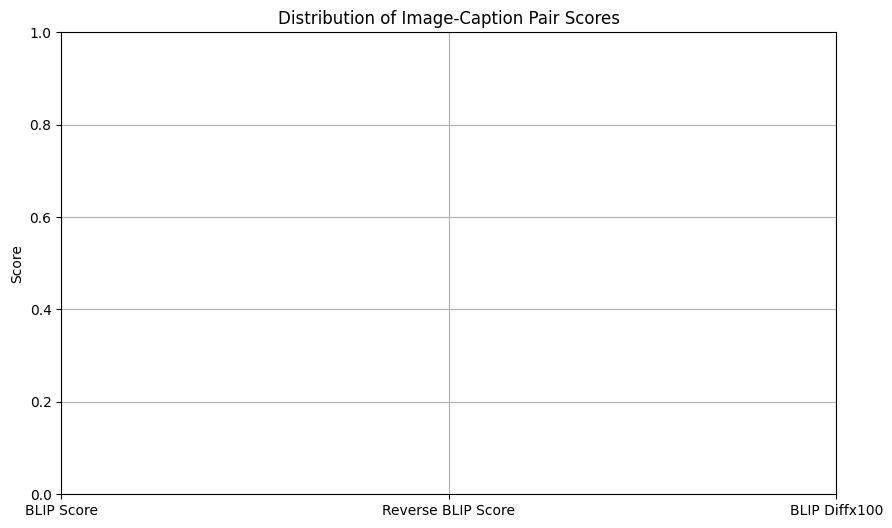

BLIP Score: Avrage:48.58169937133789 var: 93.51119995117188,  Reverse BLIP Score: avg:35.41554260253906 var:326.6199951171875,  BLIP Diff: avg:13.166160583496094 var: 148.16111755371094


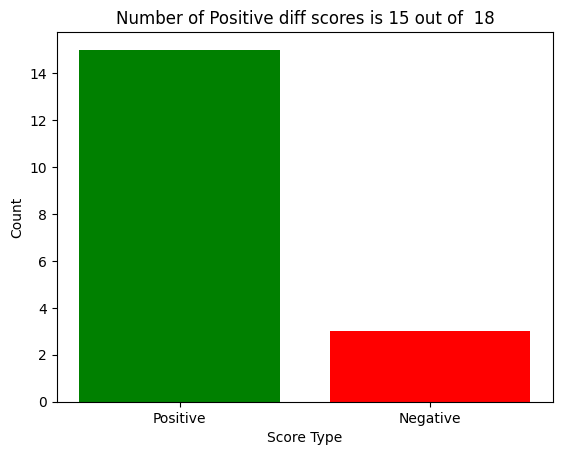

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 32
Generated text length (tokens): 9
Input prompt length (tokens): 8


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 33
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_0_seed_44.png, Caption: A dog giving a present to a man., Generated Caption a man is petting a dog in the park BLIP2 Score: tensor([47.4305]), reverse caption: A present givings a dog to a man. , reverse BLIP score tensor([29.5227]), diff tensor([17.9078])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 29
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 30
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_1_seed_44.png, Caption: A dolphin rescuing a swimmer., Generated Caption three dolphins jumping out of the water BLIP2 Score: tensor([59.5725]), reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score tensor([35.7665]), diff tensor([23.8059])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 52
Input prompt length (chars): 43
Generated text length (tokens): 11
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 52
Input prompt length (chars): 44
Generated text length (tokens): 11
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_3_seed_44.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a soldier is feeding a pigeon in front of a building BLIP2 Score: tensor([61.9788]), reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score tensor([36.8350]), diff tensor([25.1438])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 44
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_4_seed_44.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a man is weeding a garden with a rabbit BLIP2 Score: tensor([47.7191]), reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score tensor([30.6071]), diff tensor([17.1120])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 42
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 24
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_5_seed_44.png, Caption: A squirrel helping a child find lost keys., Generated Caption a squirrel is playing with a child BLIP2 Score: tensor([60.4364]), reverse caption: Lost keys finds a child. , reverse BLIP score tensor([39.2107]), diff tensor([21.2257])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 31
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 32
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_6_seed_44.png, Caption: A cat bringing a toy to a baby., Generated Caption a cat and kitten sitting on a wooden floor BLIP2 Score: tensor([48.1013]), reverse caption: A toy bringings a cat to a baby. , reverse BLIP score tensor([26.8265]), diff tensor([21.2748])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 33
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 34
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_7_seed_44.png, Caption: A bird feeding an elderly person., Generated Caption an elderly woman feeding a bird BLIP2 Score: tensor([73.3454]), reverse caption: An elderly person feedings a bird. , reverse BLIP score tensor([82.4581]), diff tensor([-9.1127])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 37
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 38
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_8_seed_44.png, Caption: A monkey handing tools to a mechanic., Generated Caption two men are holding a monkey BLIP2 Score: tensor([49.4105]), reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score tensor([42.8041]), diff tensor([6.6065])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 39
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 40
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_9_seed_44.png, Caption: A rabbit helping a child with homework., Generated Caption a girl writing with a rabbit at a table BLIP2 Score: tensor([47.2941]), reverse caption: A child helpings a rabbit with homework. , reverse BLIP score tensor([43.9374]), diff tensor([3.3566])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 40
Generated text length (tokens): 6
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 42
Generated text length (tokens): 6
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_10_seed_44.png, Caption: A cat bringing a flower to a sick person, Generated Caption a cat reaching for a flower BLIP2 Score: tensor([64.1195]), reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score tensor([39.6651]), diff tensor([24.4544])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 38
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_11_seed_44.png, Caption: A child giving homework to a teacher., Generated Caption a woman and a boy are working on homework BLIP2 Score: tensor([51.1966]), reverse caption: Homework givings a child to a teacher. , reverse BLIP score tensor([23.3191]), diff tensor([27.8775])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 37
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 38
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_12_seed_44.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a man climbing a tree with a rope BLIP2 Score: tensor([49.7791]), reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score tensor([43.4217]), diff tensor([6.3574])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 56
Input prompt length (chars): 48
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 56
Input prompt length (chars): 49
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_14_seed_44.png, Caption: A homeless person giving money to a billionaire., Generated Caption a homeless man is giving a homeless man a piece of paper BLIP2 Score: tensor([51.9939]), reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score tensor([33.7148]), diff tensor([18.2791])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 24
Input prompt length (chars): 45
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 24
Input prompt length (chars): 45
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_15_seed_44.png, Caption: A student explains astrophysics to a teacher., Generated Caption a man is holding a paper BLIP2 Score: tensor([26.7304]), reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score tensor([16.8179]), diff tensor([9.9125])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 35
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 36
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_16_seed_44.png, Caption: A child arresting a police officer., Generated Caption a police officer is helping a young boy BLIP2 Score: tensor([49.2693]), reverse caption: A police officer arrestings a child. , reverse BLIP score tensor([56.1108]), diff tensor([-6.8415])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 51
Generated text length (tokens): 11
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 41
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_17_seed_44.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two men in suits kneeling in a field with a tablet BLIP2 Score: tensor([28.6057]), reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score tensor([7.1203]), diff tensor([21.4854])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 66
Input prompt length (chars): 37
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 66
Input prompt length (chars): 38
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_18_seed_44.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrels, squirrels in a basket, squirrels, squirrels in a basket BLIP2 Score: tensor([15.8395]), reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score tensor([11.8095]), diff tensor([4.0300])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 23
Input prompt length (chars): 20
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 23
Input prompt length (chars): 21
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_19_seed_44.png, Caption: A cake eating a man., Generated Caption a man is cutting a cake BLIP2 Score: tensor([48.0416]), reverse caption: A man eatings a cake. , reverse BLIP score tensor([68.7578]), diff tensor([-20.7162])


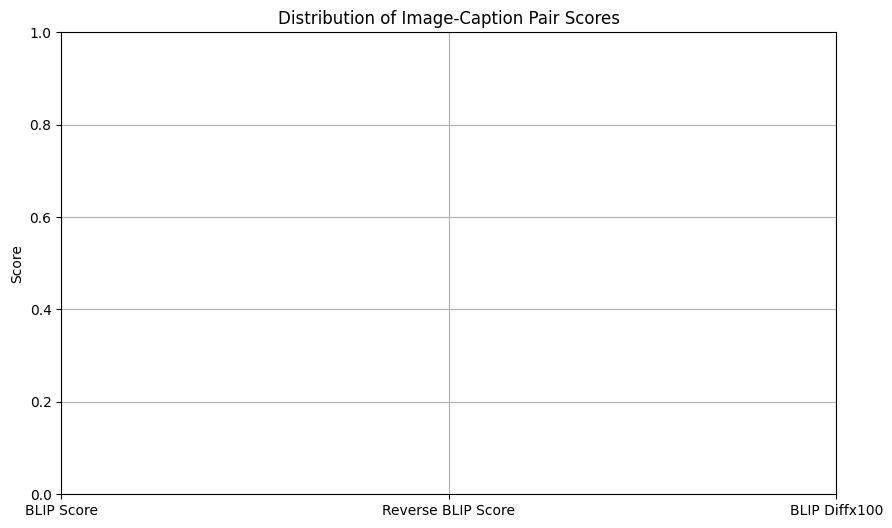

BLIP Score: Avrage:48.9369010925293 var: 181.50587463378906,  Reverse BLIP Score: avg:37.15028762817383 var:328.2959289550781,  BLIP Diff: avg:11.786614418029785 var: 175.26185607910156


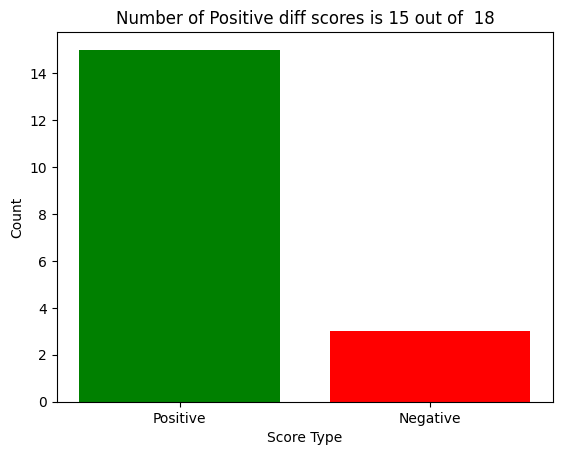

In [ ]:
  #base benchmark evalauation (Using BLIP BARST)
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
save_dir = [None] * 4
json_file = [None] * 4
for i in range(len(save_dir)):
    save_dir[i] = f'{current_dir}/base_evaluation_{i}'
    json_file[i] = f'{save_dir[i]}/image_data.json'
    evaluation(save_dir[i],json_file[i],metric ='blip', output_file_name = "blip_output")

#Evaluation the base model usign winoground captions


This code use the original base model to generate images captions we considered as "interasting" from winoground
It saved in json file the image name, caption and reverse caption (generated fro caption using the function we used in the dataset filtering)

In [ ]:

current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
winoground_captions_csv_file = f"{current_dir}/winoground_filtering_output.csv"
base_model_id  = "stabilityai/stable-diffusion-2-1-base"
captions_txt_none = "none"
base_winoground_dir = f'{current_dir}/base_evaluation_winoground'
base_winoground_json_file = evaluate_model(base_model_id, captions_txt_none, base_winoground_dir, winoground_captions_csv_file)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
base_winoground_dir = f'{current_dir}/base_evaluation_winoground'
base_winoground_json_file = f'{base_winoground_dir}/image_data.json'

In [ ]:
torch.cuda.empty_cache()

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_0.png, Caption: an old person kisses a young person, CLIP Score: 31.4697265625, reverse caption a young person kisses an old person, reverse score 32.6416015625, diff*10 -11.71875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_1.png, Caption: the taller person hugs the shorter person, CLIP Score: 30.4931640625, reverse caption the shorter person hugs the taller person, reverse score 30.3955078125, diff*10 0.9765625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_2.png, Caption: the masked wrestler hits the unmasked wrestler, CLIP Score: 32.6904296875, reverse caption the unmasked wrestler hits the masked wrestler, reverse score 32.51953125, diff*10 1.708984375
Image: /content/drive/MyDrive/

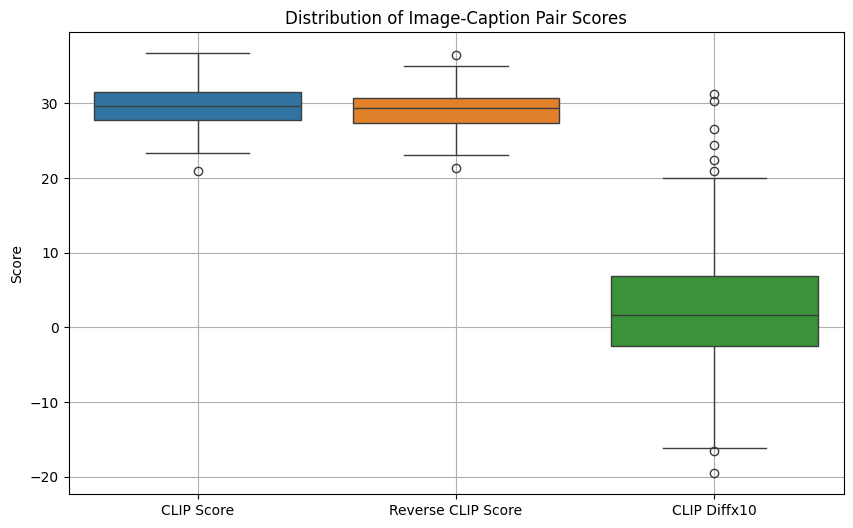

CLIP Score: Avrage:29.501244329637096 var: 8.79490216324985,  Reverse CLIP Score: avg:29.2225827452957 var:8.132187448246437,  CLIP Diff: avg:2.7866158434139785 var: 90.76429427820955


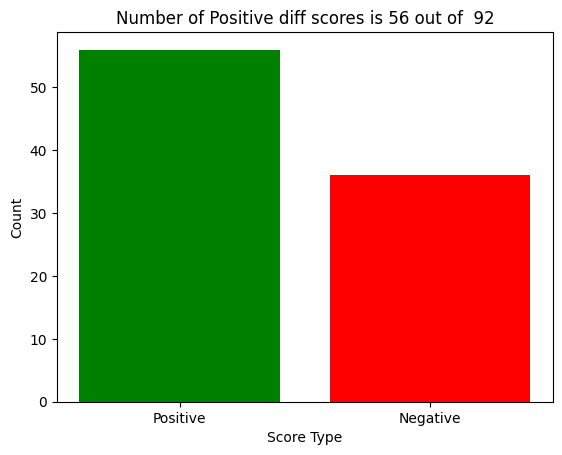

In [ ]:
#base winoground evalauation
evaluation(base_winoground_dir,base_winoground_json_file,metric ='clip')

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 35
Generated text length (tokens): 6
Input prompt length (tokens): 7


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 35
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_0.png, Caption: an old person kisses a young person, Generated Caption two older people kissing each other BLIP2 Score: tensor([49.8216]), reverse caption: a young person kisses an old person , reverse BLIP score tensor([49.6535]), diff tensor([0.1680])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 41
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 41
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_1.png, Caption: the taller person hugs the shorter person, Generated Caption two women hugging each other in the park BLIP2 Score: tensor([22.5966]), reverse caption: the shorter person hugs the taller person , reverse BLIP score tensor([22.7277]), diff tensor([-0.1311])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 46
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 46
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_2.png, Caption: the masked wrestler hits the unmasked wrestler, Generated Caption two wrestlers in yellow masks are wrestling BLIP2 Score: tensor([25.1032]), reverse caption: the unmasked wrestler hits the masked wrestler , reverse BLIP score tensor([24.8909]), diff tensor([0.2122])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 53
Input prompt length (chars): 26
Generated text length (tokens): 12
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 53
Input prompt length (chars): 26
Generated text length (tokens): 12
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_3.png, Caption: a person watches an animal, Generated Caption a girl is sitting on the grass next to a large animal BLIP2 Score: tensor([39.3246]), reverse caption: an animal watches a person , reverse BLIP score tensor([30.1995]), diff tensor([9.1251])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 57
Generated text length (tokens): 7
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 57
Generated text length (tokens): 7
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_4.png, Caption: the person without earrings pays the person with earrings, Generated Caption a woman with a turban and earrings BLIP2 Score: tensor([30.8549]), reverse caption: the person with earrings pays the person without earrings , reverse BLIP score tensor([31.0749]), diff tensor([-0.2200])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 19
Generated text length (tokens): 11
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 19
Generated text length (tokens): 11
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_5.png, Caption: a bird eats a snake, Generated Caption a bird with its mouth open is sitting on a log BLIP2 Score: tensor([39.6018]), reverse caption: a snake eats a bird , reverse BLIP score tensor([37.5319]), diff tensor([2.0700])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 85
Generated text length (tokens): 7
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 85
Generated text length (tokens): 7
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_6.png, Caption: a plant was harmed by another organism, and that organism broke the plant into pieces, Generated Caption a small plant growing in the dirt BLIP2 Score: tensor([26.2067]), reverse caption: another organism was harmed by a plant, and that plant broke the organism into pieces , reverse BLIP score tensor([27.1298]), diff tensor([-0.9231])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 42
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 42
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_7.png, Caption: the image shows a computer on top of books, Generated Caption a laptop with a stack of books on it BLIP2 Score: tensor([41.7461]), reverse caption: the image shows books on top of a computer , reverse BLIP score tensor([42.5458]), diff tensor([-0.7997])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 29
Input prompt length (chars): 82
Generated text length (tokens): 7
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 29
Input prompt length (chars): 82
Generated text length (tokens): 7
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_8.png, Caption: the person with the white collared shirt waters the plant while the other holds it, Generated Caption man planting a plant in a pot BLIP2 Score: tensor([16.5107]), reverse caption: the person with the white collared shirt holds the plant while the other waters it , reverse BLIP score tensor([17.5891]), diff tensor([-1.0785])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 59
Input prompt length (chars): 61
Generated text length (tokens): 13
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 59
Input prompt length (chars): 61
Generated text length (tokens): 13
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_9.png, Caption: the taller person chops food and the shorter person eats food, Generated Caption a person is holding a plate of food with the words taler sn BLIP2 Score: tensor([10.9120]), reverse caption: the taller person eats food and the shorter person chops food , reverse BLIP score tensor([11.1072]), diff tensor([-0.1952])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 58
Generated text length (tokens): 7
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 58
Generated text length (tokens): 7
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_10.png, Caption: the person with the ponytail packs stuff and other buys it, Generated Caption a woman walking with a shopping bag BLIP2 Score: tensor([20.5507]), reverse caption: the person with the ponytail buys stuff and other packs it , reverse BLIP score tensor([17.7064]), diff tensor([2.8443])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 33
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 33
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_11.png, Caption: the square table has a round base, Generated Caption a modern dining table with black chairs and a rug BLIP2 Score: tensor([30.4961]), reverse caption: the round table has a square base , reverse BLIP score tensor([29.8437]), diff tensor([0.6524])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 63
Input prompt length (chars): 100
Generated text length (tokens): 13
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 63
Input prompt length (chars): 100
Generated text length (tokens): 13
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_12.png, Caption: the more content person has the healthier food and the less content person has the less healthy food, Generated Caption the more content person has and he or she eats the healthy food BLIP2 Score: tensor([32.6614]), reverse caption: the less content person has the healthier food and the more content person has the less healthy food , reverse BLIP score tensor([27.9265]), diff tensor([4.7349])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 62
Generated text length (tokens): 10
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 62
Generated text length (tokens): 10
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_13.png, Caption: the larger person wears yellow and the smaller person does not, Generated Caption a man and woman dressed in yellow shirts and suits BLIP2 Score: tensor([13.2676]), reverse caption: the smaller person wears yellow and the larger person does not , reverse BLIP score tensor([12.5448]), diff tensor([0.7227])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_14.png, Caption: it wears a hat but the person doesn't, Generated Caption a man in a hat walking down the street BLIP2 Score: tensor([18.2202]), reverse caption: the person wears a hat but it doesn't , reverse BLIP score tensor([19.1843]), diff tensor([-0.9641])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 49
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 49
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_15.png, Caption: someone bakes the dough before the dough is eaten, Generated Caption a person is preparing dough on a baking sheet BLIP2 Score: tensor([33.4441]), reverse caption: the dough is eaten before someone bakes the dough , reverse BLIP score tensor([43.1757]), diff tensor([-9.7316])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 79
Generated text length (tokens): 8
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 79
Generated text length (tokens): 8
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_16.png, Caption: someone has loaded their plate with one of the toast slices and two of the eggs, Generated Caption a plate with eggs and toast on it BLIP2 Score: tensor([41.6418]), reverse caption: someone has loaded their plate with two of the toast slices and one of the eggs , reverse BLIP score tensor([40.3107]), diff tensor([1.3311])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 65
Input prompt length (chars): 59
Generated text length (tokens): 13
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 65
Input prompt length (chars): 59
Generated text length (tokens): 13
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_17.png, Caption: no people wear blue shirts and six people wear white shirts, Generated Caption a group of people in white shirts standing in front of a building BLIP2 Score: tensor([28.0358]), reverse caption: six people wear blue shirts and no people wear white shirts , reverse BLIP score tensor([24.3316]), diff tensor([3.7041])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 96
Generated text length (tokens): 10
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 96
Generated text length (tokens): 10
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_18.png, Caption: the person with the lighter shoes is holding an emoji and the person with the darker shoes isn't, Generated Caption a person wearing black shoes with smiley faces on them BLIP2 Score: tensor([17.8011]), reverse caption: the person with the darker shoes is holding an emoji and the person with the lighter shoes isn't , reverse BLIP score tensor([17.9991]), diff tensor([-0.1981])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 94
Generated text length (tokens): 12
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 94
Generated text length (tokens): 12
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_19.png, Caption: the person wearing neutral colors poses and the person wearing brighter colors takes a picture, Generated Caption a hand holding a small white object in front of a park BLIP2 Score: tensor([16.0966]), reverse caption: the person wearing brighter colors poses and the person wearing neutral colors takes a picture , reverse BLIP score tensor([13.4820]), diff tensor([2.6146])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 45
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 45
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_20.png, Caption: the people with shoes are touching each other, Generated Caption people's hands gathered around a pair of shoes BLIP2 Score: tensor([25.6861]), reverse caption: the people are touching each other with shoes , reverse BLIP score tensor([29.7665]), diff tensor([-4.0804])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 50
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 50
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_21.png, Caption: the person that is on the table is eating the food, Generated Caption a group of people eating food at a table BLIP2 Score: tensor([42.6818]), reverse caption: the person is eating the food that is on the table , reverse BLIP score tensor([48.2869]), diff tensor([-5.6051])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 62
Input prompt length (chars): 95
Generated text length (tokens): 10
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 62
Input prompt length (chars): 95
Generated text length (tokens): 10
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_22.png, Caption: they hold a suitcase handle with their left hand and they hold a passport with their right hand, Generated Caption a man is holding a passport with the words,'responsibility for BLIP2 Score: tensor([6.7484]), reverse caption: they hold a passport with their left hand and they hold a suitcase handle with their right hand , reverse BLIP score tensor([7.7852]), diff tensor([-1.0368])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 51
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 51
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_23.png, Caption: the person who is wearing a crown is kissing a frog, Generated Caption a girl with a frog on her face BLIP2 Score: tensor([39.4070]), reverse caption: the person is kissing a frog who is wearing a crown , reverse BLIP score tensor([41.0381]), diff tensor([-1.6311])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 40
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 40
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_24.png, Caption: The uncaged bird has an opened cage door, Generated Caption a small bird is sitting in a cage BLIP2 Score: tensor([47.3406]), reverse caption: The caged bird has an unopened cage door , reverse BLIP score tensor([44.8925]), diff tensor([2.4481])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 41
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 41
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_25.png, Caption: they are using no bait but still got fish, Generated Caption a man holding a fish on the shore BLIP2 Score: tensor([20.0755]), reverse caption: they are using bait but still got no fish , reverse BLIP score tensor([21.0311]), diff tensor([-0.9555])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 57
Generated text length (tokens): 7
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 57
Generated text length (tokens): 7
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_26.png, Caption: someone on the ground is spraying water towards a vehicle, Generated Caption a man spraying water on a street BLIP2 Score: tensor([52.8167]), reverse caption: someone is on a vehicle spraying water towards the ground , reverse BLIP score tensor([51.0969]), diff tensor([1.7199])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 55
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 55
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_27.png, Caption: the dog wears as a hat what someone would normally bite, Generated Caption a dog wearing a blue and orange hat BLIP2 Score: tensor([28.5844]), reverse caption: the dog bites what someone would normally wear as a hat , reverse BLIP score tensor([27.2920]), diff tensor([1.2924])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 47
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 47
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_28.png, Caption: someone is wearing a black hat and yellow shirt, Generated Caption a man with long hair and a hat BLIP2 Score: tensor([34.4986]), reverse caption: someone is wearing a yellow hat and black shirt , reverse BLIP score tensor([32.4610]), diff tensor([2.0376])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 29
Input prompt length (chars): 60
Generated text length (tokens): 6
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 29
Input prompt length (chars): 60
Generated text length (tokens): 6
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_29.png, Caption: the red team kicking the ball directly next to the blue team, Generated Caption a group of men playing soccer BLIP2 Score: tensor([20.8083]), reverse caption: the blue team kicking the ball directly next to the red team , reverse BLIP score tensor([21.4352]), diff tensor([-0.6269])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 42
Generated text length (tokens): 11
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 42
Generated text length (tokens): 11
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_30.png, Caption: person in white is reading the orange book, Generated Caption a man is reading a book with an orange on top BLIP2 Score: tensor([41.6715]), reverse caption: person in orange is reading the white book , reverse BLIP score tensor([40.4326]), diff tensor([1.2389])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 75
Generated text length (tokens): 9
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 75
Generated text length (tokens): 9
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_31.png, Caption: the balloon in the middle has less air and the other balloons have more air, Generated Caption a colorful hot air balloon flying over a forest BLIP2 Score: tensor([6.9747]), reverse caption: the balloon in the middle has more air and the other balloons have less air , reverse BLIP score tensor([7.6920]), diff tensor([-0.7172])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 65
Generated text length (tokens): 8
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 65
Generated text length (tokens): 8
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_32.png, Caption: the pool has no people and the area around it has a lot of people, Generated Caption a large swimming pool with people in it BLIP2 Score: tensor([34.6622]), reverse caption: the pool has a lot of people and the area around it has no people , reverse BLIP score tensor([34.7153]), diff tensor([-0.0531])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 40
Generated text length (tokens): 13
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 40
Generated text length (tokens): 13
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_33.png, Caption: they're enjoying hot water on a cold day, Generated Caption a dog and a cat drinking from a yellow bowl in the snow BLIP2 Score: tensor([24.8264]), reverse caption: they're enjoying cold water on a hot day , reverse BLIP score tensor([23.2194]), diff tensor([1.6071])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 56
Input prompt length (chars): 83
Generated text length (tokens): 11
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 56
Input prompt length (chars): 83
Generated text length (tokens): 11
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_34.png, Caption: the person on the left has curly hair and the person on the right has straight hair, Generated Caption a man with curly hair before and after a hair transplant BLIP2 Score: tensor([30.7069]), reverse caption: the person on the left has straight hair and the person on the right has curly hair , reverse BLIP score tensor([28.9482]), diff tensor([1.7587])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 29
Input prompt length (chars): 44
Generated text length (tokens): 5
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 29
Input prompt length (chars): 44
Generated text length (tokens): 5
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_35.png, Caption: a dog is using a wheelchair next to a person, Generated Caption woman in wheelchair with dogs BLIP2 Score: tensor([39.0086]), reverse caption: a person is using a wheelchair next to a dog , reverse BLIP score tensor([46.2871]), diff tensor([-7.2786])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 63
Generated text length (tokens): 9
Input prompt length (tokens): 13


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 63
Generated text length (tokens): 9
Input prompt length (tokens): 13


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_36.png, Caption: a more lightly-colored dog is holding a toy next to a black dog, Generated Caption two dogs are playing with toys in the grass BLIP2 Score: tensor([43.5457]), reverse caption: a black dog is holding a toy next to a more lightly-colored dog , reverse BLIP score tensor([41.7240]), diff tensor([1.8217])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 42
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 42
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_37.png, Caption: a person is casting a shadow beside a ball, Generated Caption a tennis ball is laying on a court with a shadow BLIP2 Score: tensor([42.6482]), reverse caption: a ball is casting a shadow beside a person , reverse BLIP score tensor([44.9304]), diff tensor([-2.2822])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 40
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 40
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_38.png, Caption: the child is throwing the adult the ball, Generated Caption two children playing with a ball in a park BLIP2 Score: tensor([33.1667]), reverse caption: the adult is throwing the child the ball , reverse BLIP score tensor([40.5033]), diff tensor([-7.3365])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 43
Generated text length (tokens): 13
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 43
Generated text length (tokens): 13
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_39.png, Caption: the person reached the base before the ball, Generated Caption a man is running on a track with a circle in the middle BLIP2 Score: tensor([29.5552]), reverse caption: the ball reached the base before the person , reverse BLIP score tensor([27.0209]), diff tensor([2.5344])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 23
Generated text length (tokens): 11
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 23
Generated text length (tokens): 11
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_40.png, Caption: an adult kisses a child, Generated Caption a woman kissing a boy in front of a brick wall BLIP2 Score: tensor([47.8840]), reverse caption: a child kisses an adult , reverse BLIP score tensor([43.4796]), diff tensor([4.4045])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 88
Generated text length (tokens): 9
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 88
Generated text length (tokens): 9
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_41.png, Caption: the person on the left has their arms up and the person on the right has their arms down, Generated Caption two people with their hands raised in the air BLIP2 Score: tensor([32.3092]), reverse caption: the person on the right has their arms up and the person on the left has their arms down , reverse BLIP score tensor([31.8790]), diff tensor([0.4302])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 88
Generated text length (tokens): 9
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 88
Generated text length (tokens): 9
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_42.png, Caption: the person on the left is holding the phone and the person on the right is staring at it, Generated Caption two pictures of a man looking at his phone BLIP2 Score: tensor([26.3934]), reverse caption: the person on the right is holding the phone and the person on the left is staring at it , reverse BLIP score tensor([26.1572]), diff tensor([0.2362])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 81
Generated text length (tokens): 9
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 81
Generated text length (tokens): 9
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_43.png, Caption: the person on the left is blowing bubbles and the person on the right is watching, Generated Caption a boy and girl are looking at soap bubbles BLIP2 Score: tensor([25.5920]), reverse caption: the person on the right is blowing bubbles and the person on the left is watching , reverse BLIP score tensor([25.7825]), diff tensor([-0.1905])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_44.png, Caption: they worked out then they drank water, Generated Caption a group of girls are playing in the water BLIP2 Score: tensor([17.1340]), reverse caption: they drank water then they worked out , reverse BLIP score tensor([18.8910]), diff tensor([-1.7569])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 48
Generated text length (tokens): 8
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 48
Generated text length (tokens): 8
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_45.png, Caption: The kid throws the pancake and the adult sees it, Generated Caption a cartoon of a man holding a child BLIP2 Score: tensor([28.1192]), reverse caption: The kids see the pancake and the adult throws it , reverse BLIP score tensor([22.9830]), diff tensor([5.1362])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 41
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 41
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_46.png, Caption: an older person blocking a younger person, Generated Caption two elderly men are dancing together BLIP2 Score: tensor([33.0673]), reverse caption: a younger person blocking an older person , reverse BLIP score tensor([31.0500]), diff tensor([2.0173])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 82
Generated text length (tokens): 7
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 82
Generated text length (tokens): 7
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_47.png, Caption: a person cries while another person wearing jewelry above their shoulders consoles, Generated Caption two women are holding each other's necks BLIP2 Score: tensor([9.9107]), reverse caption: a person consoles while another person wearing jewelry above their shoulders cries , reverse BLIP score tensor([12.8988]), diff tensor([-2.9881])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 103
Generated text length (tokens): 8
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 103
Generated text length (tokens): 8
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_48.png, Caption: a person with long hair eating a meat-based product while a person with short hair snacks on some fries, Generated Caption a woman holding a plate of french fries BLIP2 Score: tensor([35.9003]), reverse caption: a person with short hair eating a meat-based product while a person with long hair snacks on some fries , reverse BLIP score tensor([35.8322]), diff tensor([0.0681])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 61
Generated text length (tokens): 8
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 61
Generated text length (tokens): 8
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_49.png, Caption: You can catch more flies with honey than you can with vinegar, Generated Caption honey bees swarming over a jar of honey BLIP2 Score: tensor([10.4143]), reverse caption: You can catch more flies with vinegar than you can with honey , reverse BLIP score tensor([9.7481]), diff tensor([0.6661])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 25
Input prompt length (chars): 23
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 25
Input prompt length (chars): 23
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_50.png, Caption: I need my strength back, Generated Caption i'm ed sreh bak k t-shirt BLIP2 Score: tensor([1.4617]), reverse caption: I need my back strength , reverse BLIP score tensor([1.5032]), diff tensor([-0.0415])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 83
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 83
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_51.png, Caption: the driver wearing a shirt is in front of the other person wearing a sleeveless top, Generated Caption a man and woman in a car giving thumbs up BLIP2 Score: tensor([12.4016]), reverse caption: the driver wearing a sleeveless top is in front of the other person wearing a shirt , reverse BLIP score tensor([12.6637]), diff tensor([-0.2621])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 86
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 86
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_52.png, Caption: the person with hair to their shoulders has brown eyes and the other person's are blue, Generated Caption two people with curly hair standing next to each other BLIP2 Score: tensor([15.6055]), reverse caption: the person with hair to their shoulders has blue eyes and the other person's are brown , reverse BLIP score tensor([15.3036]), diff tensor([0.3019])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 62
Input prompt length (chars): 56
Generated text length (tokens): 12
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 62
Input prompt length (chars): 56
Generated text length (tokens): 12
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_53.png, Caption: a human being on a device that intercepts the sun's rays, Generated Caption a silhouette of a person standing in front of a circular light BLIP2 Score: tensor([30.0937]), reverse caption: a device that intercepts the sun's rays on a human being , reverse BLIP score tensor([25.8143]), diff tensor([4.2795])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 79
Generated text length (tokens): 6
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 79
Generated text length (tokens): 6
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_54.png, Caption: two people; the one on the right has curly hair and the one on the left doesn't, Generated Caption two young people with curly hair BLIP2 Score: tensor([27.4011]), reverse caption: two people; the one on the left has curly hair and the one on the right doesn't , reverse BLIP score tensor([27.3844]), diff tensor([0.0167])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 45
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 45
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_55.png, Caption: using the laptop while the guitar is close by, Generated Caption a man playing an acoustic guitar on a wooden table BLIP2 Score: tensor([24.5070]), reverse caption: using the guitar while the laptop is close by , reverse BLIP score tensor([27.2741]), diff tensor([-2.7671])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 67
Input prompt length (chars): 60
Generated text length (tokens): 12
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 67
Input prompt length (chars): 60
Generated text length (tokens): 12
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_56.png, Caption: the younger person is making noise while the other is silent, Generated Caption four children sitting on the ground with their hands on their faces BLIP2 Score: tensor([22.8382]), reverse caption: the younger person is silent while the other is making noise , reverse BLIP score tensor([25.2218]), diff tensor([-2.3836])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 96
Generated text length (tokens): 9
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 96
Generated text length (tokens): 9
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_57.png, Caption: the gesture of the person sitting down is supporting the understanding of the person standing up, Generated Caption three people sitting on a bench in a park BLIP2 Score: tensor([13.2136]), reverse caption: the gesture of the person standing up is supporting the understanding of the person sitting down , reverse BLIP score tensor([12.1197]), diff tensor([1.0939])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 93
Generated text length (tokens): 8
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 93
Generated text length (tokens): 8
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_58.png, Caption: the outlet carrying water from the faucet to the shower head is near the hot tap not the cold, Generated Caption a modern bathroom with a sink and faucet BLIP2 Score: tensor([28.6414]), reverse caption: the outlet carrying water from the faucet to the shower head is near the cold tap not the hot , reverse BLIP score tensor([27.6369]), diff tensor([1.0044])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 40
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 40
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_59.png, Caption: The white queen is taking the black king, Generated Caption a woman in a white dress and a man on a horse BLIP2 Score: tensor([14.1966]), reverse caption: The black queen is taking the white king , reverse BLIP score tensor([13.7584]), diff tensor([0.4382])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 56
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 56
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_60.png, Caption: a taller person is covering the eyes of a shorter person, Generated Caption a man with his hands on his head BLIP2 Score: tensor([21.9521]), reverse caption: a shorter person is covering the eyes of a taller person , reverse BLIP score tensor([21.4482]), diff tensor([0.5039])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 27
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 27
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_61.png, Caption: the plant is eating the bug, Generated Caption a green bug is sitting on a leaf BLIP2 Score: tensor([40.9363]), reverse caption: the bug is eating the plant , reverse BLIP score tensor([54.6089]), diff tensor([-13.6726])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 20
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 20
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_62.png, Caption: every bug has a leaf, Generated Caption a red and orange bug sitting on a leaf BLIP2 Score: tensor([37.5849]), reverse caption: every leaf has a bug , reverse BLIP score tensor([35.8892]), diff tensor([1.6957])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 58
Generated text length (tokens): 10
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 58
Generated text length (tokens): 10
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_63.png, Caption: the moon prevents the sun's rays from falling on the earth, Generated Caption the moon is seen from the surface of the moon BLIP2 Score: tensor([30.6043]), reverse caption: the earth prevents the sun's rays from falling on the moon , reverse BLIP score tensor([26.2735]), diff tensor([4.3308])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 82
Generated text length (tokens): 6
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 82
Generated text length (tokens): 6
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_64.png, Caption: all paper airplanes fly on a straight path except for one which takes a curved one, Generated Caption paper airplanes flying in the air BLIP2 Score: tensor([19.7210]), reverse caption: all paper airplanes fly on a curved path except for one which takes a straight one , reverse BLIP score tensor([19.3935]), diff tensor([0.3275])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 36
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 36
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_65.png, Caption: a kid jumped then threw a basketball, Generated Caption a group of young boys playing basketball in a gym BLIP2 Score: tensor([31.7777]), reverse caption: a kid threw a basketball then jumped , reverse BLIP score tensor([32.6549]), diff tensor([-0.8772])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 23
Input prompt length (chars): 19
Generated text length (tokens): 6
Input prompt length (tokens): 4


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 23
Input prompt length (chars): 19
Generated text length (tokens): 6
Input prompt length (tokens): 4


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_66.png, Caption: someone babys a pet, Generated Caption a baby is petting a dog BLIP2 Score: tensor([33.4593]), reverse caption: someone pets a baby , reverse BLIP score tensor([57.0904]), diff tensor([-23.6310])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 86
Generated text length (tokens): 7
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 86
Generated text length (tokens): 7
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_67.png, Caption: the person wearing a sweater stands in front of the person who isn't wearing a sweater, Generated Caption two men standing outside of a building BLIP2 Score: tensor([29.3309]), reverse caption: the person who isn't wearing a sweater stands in front of the person wearing a sweater , reverse BLIP score tensor([29.8134]), diff tensor([-0.4826])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 70
Generated text length (tokens): 11
Input prompt length (tokens): 13


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 70
Generated text length (tokens): 11
Input prompt length (tokens): 13


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_68.png, Caption: a person without glasses pushes a person with glasses sitting in a box, Generated Caption a man and woman are helping each other move a box BLIP2 Score: tensor([20.3742]), reverse caption: a person with glasses pushes a person without glasses sitting in a box , reverse BLIP score tensor([19.2658]), diff tensor([1.1083])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 46
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 46
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_69.png, Caption: soon this animal not with a tail will have one, Generated Caption a small animal with long horns walking in the grass BLIP2 Score: tensor([17.0398]), reverse caption: soon this animal with a tail will not have one , reverse BLIP score tensor([17.7673]), diff tensor([-0.7275])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 25
Generated text length (tokens): 9
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 25
Generated text length (tokens): 9
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_70.png, Caption: a mouse is touching a dog, Generated Caption a dog and a mouse playing with each other BLIP2 Score: tensor([43.6909]), reverse caption: a dog is touching a mouse , reverse BLIP score tensor([54.2476]), diff tensor([-10.5566])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 25
Input prompt length (chars): 151
Generated text length (tokens): 5
Input prompt length (tokens): 26


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 25
Input prompt length (chars): 151
Generated text length (tokens): 5
Input prompt length (tokens): 26


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_71.png, Caption: a person wearing black shoes cleaning a bookshelf with an orange duster while a person wearing green shoes drinks wine from an orange glass and relaxes, Generated Caption a woman cleaning a closet BLIP2 Score: tensor([22.3797]), reverse caption: a person wearing green shoes cleaning a bookshelf with an orange duster while a person wearing black shoes drinks wine from an orange glass and relaxes , reverse BLIP score tensor([22.2807]), diff tensor([0.0990])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 114
Generated text length (tokens): 5
Input prompt length (tokens): 23


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 114
Generated text length (tokens): 5
Input prompt length (tokens): 23


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_72.png, Caption: a person with short hair is happily ironing a light blue shirt while a person with long hair sits on a white couch, Generated Caption two women cleaning a couch BLIP2 Score: tensor([25.1358]), reverse caption: a person with long hair is happily ironing a light blue shirt while a person with short hair sits on a white couch , reverse BLIP score tensor([24.7888]), diff tensor([0.3471])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 23
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 23
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_73.png, Caption: a bird cooking a person, Generated Caption a woman is eating a meal with a bird BLIP2 Score: tensor([41.1228]), reverse caption: a person cooking a bird , reverse BLIP score tensor([50.3711]), diff tensor([-9.2483])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 79
Generated text length (tokens): 7
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 79
Generated text length (tokens): 7
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_74.png, Caption: a person wearing yellow with their feet in the air and a person wearing stripes, Generated Caption a man and woman in striped clothing BLIP2 Score: tensor([31.5647]), reverse caption: a person wearing stripes with their feet in the air and a person wearing yellow , reverse BLIP score tensor([32.9318]), diff tensor([-1.3671])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 95
Generated text length (tokens): 7
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 95
Generated text length (tokens): 7
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_75.png, Caption: A person sits next to a baby using an orange screwdriver to assemble a white piece of furniture, Generated Caption a man is playing with a baby BLIP2 Score: tensor([36.7603]), reverse caption: A baby sits next to a person using an orange screwdriver to assemble a white piece of furniture , reverse BLIP score tensor([32.6560]), diff tensor([4.1043])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 52
Input prompt length (chars): 85
Generated text length (tokens): 11
Input prompt length (tokens): 20


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 52
Input prompt length (chars): 85
Generated text length (tokens): 11
Input prompt length (tokens): 20


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_76.png, Caption: a worker in a yellow hat uses a drill to the left of where the opening in the wall is, Generated Caption a construction worker is using a drill to fix a wall BLIP2 Score: tensor([44.7084]), reverse caption: the opening in the wall is to the left of where a worker in a yellow hat uses a drill , reverse BLIP score tensor([38.9786]), diff tensor([5.7298])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 43
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 43
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_77.png, Caption: A right hand pulls a glove onto a left hand, Generated Caption a pair of gloves with a white bandage on them BLIP2 Score: tensor([13.1504]), reverse caption: A left hand pulls a glove onto a right hand , reverse BLIP score tensor([12.5905]), diff tensor([0.5599])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 52
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 52
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_78.png, Caption: one ear that some donkey is whispering a secret into, Generated Caption a donkey with blue eyes looking at the camera BLIP2 Score: tensor([28.2385]), reverse caption: donkey ear that some one is whispering a secret into , reverse BLIP score tensor([16.1761]), diff tensor([12.0625])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 43
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 43
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_79.png, Caption: walking someone cut lines into green plants, Generated Caption a woman walking down a sidewalk with a green garden BLIP2 Score: tensor([24.7716]), reverse caption: someone walking lines cut into green plants , reverse BLIP score tensor([26.0097]), diff tensor([-1.2381])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 33
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 33
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_80.png, Caption: a volcano above water makes steam, Generated Caption a volcano is spewing smoke into the water BLIP2 Score: tensor([48.8980]), reverse caption: water above a volcano makes steam , reverse BLIP score tensor([31.8240]), diff tensor([17.0741])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 36
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 36
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_81.png, Caption: an adult putting a helmet on a child, Generated Caption a man helping a child with a helmet BLIP2 Score: tensor([71.6547]), reverse caption: a child putting a helmet on an adult , reverse BLIP score tensor([61.2162]), diff tensor([10.4385])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 107
Generated text length (tokens): 10
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 107
Generated text length (tokens): 10
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_82.png, Caption: a fencer who is wearing black pants having a point scored against them by another fencer using a wheelchair, Generated Caption two men in wheelchairs are giving each other high fives BLIP2 Score: tensor([16.6050]), reverse caption: a fencer having a point scored against them by another fencer who is wearing black pants using a wheelchair , reverse BLIP score tensor([16.2477]), diff tensor([0.3573])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 73
Generated text length (tokens): 9
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 73
Generated text length (tokens): 9
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_83.png, Caption: in the stadium, the person wearing gray outperformed the one wearing blue, Generated Caption two women in blue uniforms fighting on the field BLIP2 Score: tensor([17.2982]), reverse caption: in the stadium, the person wearing blue outperformed the one wearing gray , reverse BLIP score tensor([17.6805]), diff tensor([-0.3823])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_84.png, Caption: a person is touching the head of a squirrel, Generated Caption a squirrel is eating a piece of food BLIP2 Score: tensor([57.6417]), reverse caption: a squirrel is touching the head of a person , reverse BLIP score tensor([58.3566]), diff tensor([-0.7149])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 30
Generated text length (tokens): 7
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 30
Generated text length (tokens): 7
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_85.png, Caption: an animal giving a person food, Generated Caption a deer eating a plate of salad BLIP2 Score: tensor([42.6659]), reverse caption: a person giving an animal food , reverse BLIP score tensor([38.1545]), diff tensor([4.5114])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 85
Generated text length (tokens): 9
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 85
Generated text length (tokens): 9
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_86.png, Caption: two people wearing clothes of the same colors are on different side of the tennis net, Generated Caption a man and woman standing on a tennis court BLIP2 Score: tensor([22.3785]), reverse caption: two people wearing clothes of different colors are on the same side of the tennis net , reverse BLIP score tensor([24.4868]), diff tensor([-2.1083])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 31
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 31
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_87.png, Caption: a person supports a small chair, Generated Caption a man is putting chairs together BLIP2 Score: tensor([29.1532]), reverse caption: a chair supports a small person , reverse BLIP score tensor([27.0032]), diff tensor([2.1500])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 89
Generated text length (tokens): 8
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 89
Generated text length (tokens): 8
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_88.png, Caption: a person smiles at another person wearing a checked shirt who is hitting a ping pong ball, Generated Caption two people playing ping pong in an office BLIP2 Score: tensor([37.7430]), reverse caption: a person wearing a checked shirt smiles at another person who is hitting a ping pong ball , reverse BLIP score tensor([40.8671]), diff tensor([-3.1241])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 72
Generated text length (tokens): 12
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 72
Generated text length (tokens): 12
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_89.png, Caption: The worker wears something striped over a white undershirt with a collar, Generated Caption a man in a striped shirt with a mask on his face BLIP2 Score: tensor([37.8126]), reverse caption: The worker wears something white over a striped undershirt with a collar , reverse BLIP score tensor([39.2090]), diff tensor([-1.3964])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 46
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 46
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_90.png, Caption: A person seen from above has a grid below them, Generated Caption a man in a suit standing on a grid BLIP2 Score: tensor([32.1213]), reverse caption: A person seen from below has a grid above them , reverse BLIP score tensor([31.2129]), diff tensor([0.9084])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 36
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 36
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_91.png, Caption: They have sunglasses over their hair, Generated Caption two young men with sunglasses on their faces BLIP2 Score: tensor([53.4997]), reverse caption: They have hair over their sunglasses , reverse BLIP score tensor([44.1653]), diff tensor([9.3344])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 23
Generated text length (tokens): 10
Input prompt length (tokens): 4


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 24
Generated text length (tokens): 10
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_92.png, Caption: someone is overdoing it, Generated Caption a boy is sitting on a couch with a doll BLIP2 Score: tensor([13.2910]), reverse caption: someone is doing it over , reverse BLIP score tensor([15.2640]), diff tensor([-1.9730])


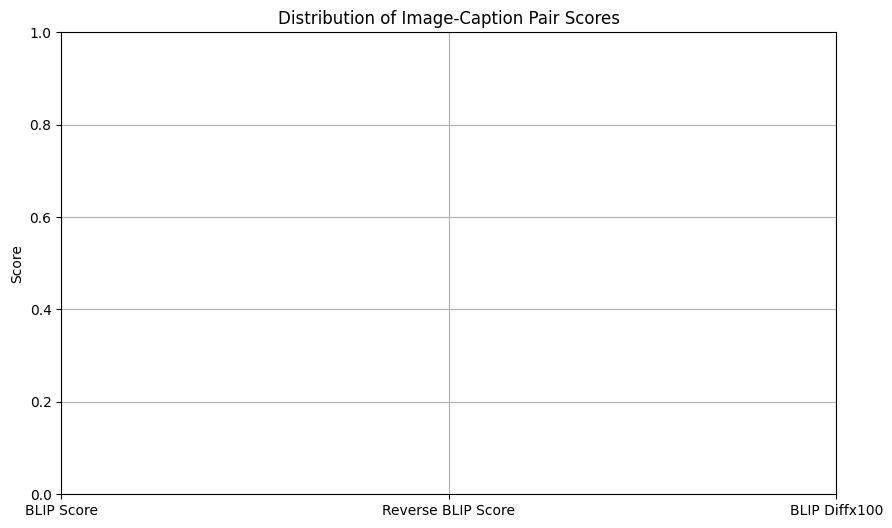

BLIP Score: Avrage:29.381277084350586 var: 156.86851501464844,  Reverse BLIP Score: avg:29.245363235473633 var:162.90626525878906,  BLIP Diff: avg:0.13590951263904572 var: 24.00701904296875


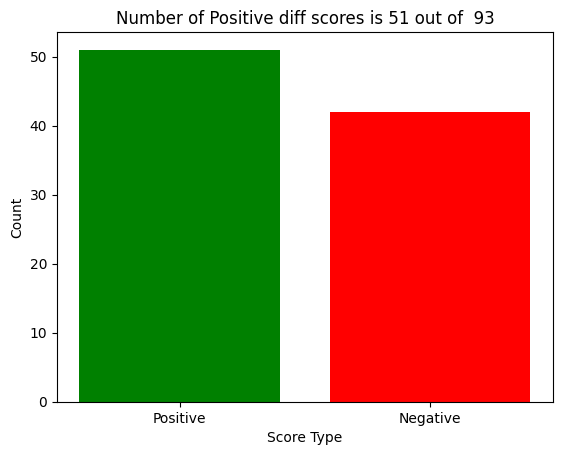

In [ ]:
#base winoground evalauation
evaluation(base_winoground_dir,base_winoground_json_file,metric ='blip', output_file_name = "blip_ouput")

#Evaluate our trained model using Benchmark list
This code use our trained model to generate images from our benchmark list It saved in json file the image name, caption and reverse caption (generated fro caption using the function we used in the dataset filtering)

In [ ]:
torch.cuda.empty_cache()


In [ ]:

current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
model_id = ["nadavo11/actions_model", "nadavo11/actions_model5","nadavo11/ImSitu_actions_model"]
captions_txt = f'{current_dir}/benchmark.txt'
bm_trained_json = [[None] * 4 for _ in range(len(model_id))]
trained_bm_dir = [[None] * 4 for _ in range(len(model_id))]
caption_csv = "none"
for j in range(len(model_id)):
  for i in range(4):
    seed_base =41
    trained_bm_dir[j][i] = f'{current_dir}/bm_trained_{j}_evaluation_{i}'
    bm_trained_json[j][i] = evaluate_model(model_id[j], captions_txt, trained_bm_dir[j][i], 'none',  seed = seed_base+i)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


/usr/local/lib/python3.10/dist-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
!pip install --upgrade transformers

  Using cached transformers-4.45.1-py3-none-any.whl.metadata (44 kB)
  Using cached tokenizers-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.45.1-py3-none-any.whl (9.9 MB)
Using cached tokenizers-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.9 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.36.2
    Uninstalling transformers-4.36.2:
      Successfully uninstalled transformers-4.36.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy-transformers 1.3.5 requires transformers<4.37.0,>=3.4.0, but you have transformers 4.45.1 which is incompatible.


Using cuda
Metric used is BLIP Score


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 32
Generated text length (tokens): 8
Input prompt length (tokens): 8


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 33
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_0_seed_41.png, Caption: A dog giving a present to a man., Generated Caption a man giving a gift to his dog BLIP2 Score: tensor([68.1663]), reverse caption: A present givings a dog to a man. , reverse BLIP score tensor([42.2513]), diff tensor([25.9150])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 29
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 30
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_1_seed_41.png, Caption: A dolphin rescuing a swimmer., Generated Caption a dolphin jumping out of the water BLIP2 Score: tensor([60.6444]), reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score tensor([36.4997]), diff tensor([24.1447])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 44
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_3_seed_41.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a soldier is petting a pigeon on the ground BLIP2 Score: tensor([60.1770]), reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score tensor([38.0275]), diff tensor([22.1495])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 44
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_4_seed_41.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a man feeding a rabbit in a garden BLIP2 Score: tensor([57.6216]), reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score tensor([40.7334]), diff tensor([16.8882])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 42
Generated text length (tokens): 6
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 24
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_5_seed_41.png, Caption: A squirrel helping a child find lost keys., Generated Caption a baby is petting a squirrel BLIP2 Score: tensor([48.5209]), reverse caption: Lost keys finds a child. , reverse BLIP score tensor([33.4392]), diff tensor([15.0817])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 31
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 32
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_6_seed_41.png, Caption: A cat bringing a toy to a baby., Generated Caption a baby is playing with a toy cat BLIP2 Score: tensor([59.9074]), reverse caption: A toy bringings a cat to a baby. , reverse BLIP score tensor([44.5643]), diff tensor([15.3431])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 33
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 34
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_7_seed_41.png, Caption: A bird feeding an elderly person., Generated Caption an elderly woman feeding a bird BLIP2 Score: tensor([73.3454]), reverse caption: An elderly person feedings a bird. , reverse BLIP score tensor([82.4581]), diff tensor([-9.1127])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 37
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 38
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_8_seed_41.png, Caption: A monkey handing tools to a mechanic., Generated Caption monkey mechanic in a garage BLIP2 Score: tensor([52.8714]), reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score tensor([36.4748]), diff tensor([16.3966])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 39
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 40
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_9_seed_41.png, Caption: A rabbit helping a child with homework., Generated Caption a boy is writing with a rabbit at his desk BLIP2 Score: tensor([45.1250]), reverse caption: A child helpings a rabbit with homework. , reverse BLIP score tensor([45.1548]), diff tensor([-0.0298])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 40
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 42
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_10_seed_41.png, Caption: A cat bringing a flower to a sick person, Generated Caption a woman is sitting on the grass with a cat BLIP2 Score: tensor([40.4527]), reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score tensor([30.4079]), diff tensor([10.0448])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 53
Input prompt length (chars): 37
Generated text length (tokens): 12
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 53
Input prompt length (chars): 38
Generated text length (tokens): 12
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_11_seed_41.png, Caption: A child giving homework to a teacher., Generated Caption a girl is writing with a pencil in front of a teacher BLIP2 Score: tensor([51.9888]), reverse caption: Homework givings a child to a teacher. , reverse BLIP score tensor([25.6767]), diff tensor([26.3121])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 37
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 38
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_12_seed_41.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a black cat is climbing a tree BLIP2 Score: tensor([51.0351]), reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score tensor([38.8690]), diff tensor([12.1661])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 48
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 49
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_14_seed_41.png, Caption: A homeless person giving money to a billionaire., Generated Caption a homeless man is handing a man a note BLIP2 Score: tensor([53.2119]), reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score tensor([32.0252]), diff tensor([21.1868])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 45
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 45
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_15_seed_41.png, Caption: A student explains astrophysics to a teacher., Generated Caption a girl wearing a red sweater BLIP2 Score: tensor([33.1496]), reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score tensor([20.5482]), diff tensor([12.6014])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 35
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 36
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_16_seed_41.png, Caption: A child arresting a police officer., Generated Caption a police officer is shaking a boy's hand BLIP2 Score: tensor([53.5281]), reverse caption: A police officer arrestings a child. , reverse BLIP score tensor([55.4299]), diff tensor([-1.9018])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 51
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 41
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_17_seed_41.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two men in hats kneeling down in the dirt BLIP2 Score: tensor([29.4849]), reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score tensor([7.3234]), diff tensor([22.1615])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 37
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 38
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_18_seed_41.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrel eating nuts on a picnic blanket BLIP2 Score: tensor([55.7244]), reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score tensor([31.2173]), diff tensor([24.5071])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 20
Input prompt length (chars): 20
Generated text length (tokens): 5
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 20
Input prompt length (chars): 21
Generated text length (tokens): 5
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_19_seed_41.png, Caption: A cake eating a man., Generated Caption a man cutting a cake BLIP2 Score: tensor([53.8547]), reverse caption: A man eatings a cake. , reverse BLIP score tensor([77.2175]), diff tensor([-23.3628])


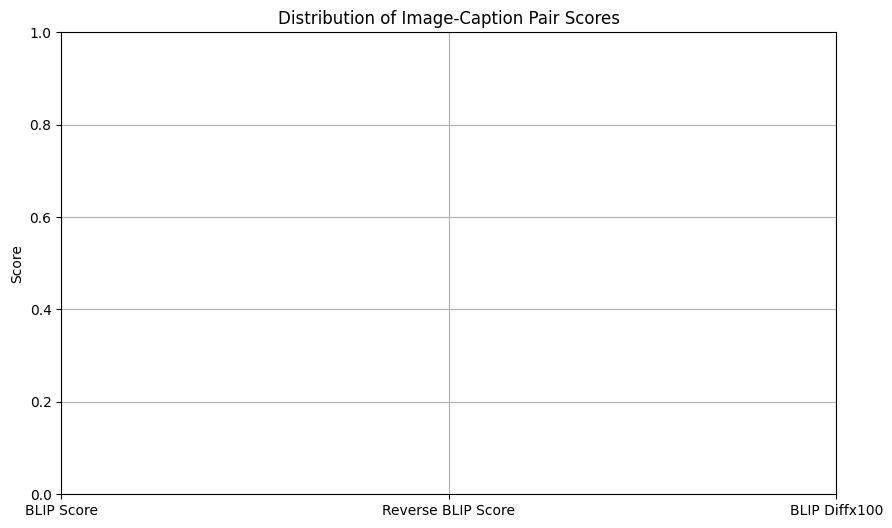

BLIP Score: Avrage:52.71164321899414 var: 112.29765319824219,  Reverse BLIP Score: avg:39.90655517578125 var:301.982666015625,  BLIP Diff: avg:12.80508804321289 var: 171.3189239501953


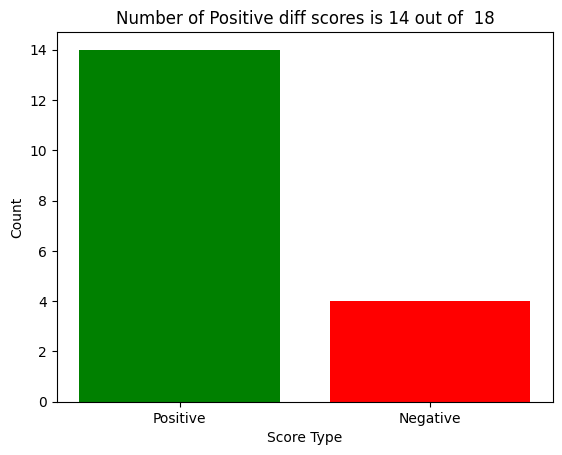

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 32
Generated text length (tokens): 6
Input prompt length (tokens): 8


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 33
Generated text length (tokens): 6
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_0_seed_42.png, Caption: A dog giving a present to a man., Generated Caption a man and dog holding presents BLIP2 Score: tensor([53.0900]), reverse caption: A present givings a dog to a man. , reverse BLIP score tensor([26.3393]), diff tensor([26.7507])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 29
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 30
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_1_seed_42.png, Caption: A dolphin rescuing a swimmer., Generated Caption two dolphins are jumping out of the water BLIP2 Score: tensor([45.6601]), reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score tensor([29.9020]), diff tensor([15.7581])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 44
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_3_seed_42.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a man kneeling down next to a pigeon BLIP2 Score: tensor([57.9163]), reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score tensor([36.0030]), diff tensor([21.9133])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 43
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 44
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_4_seed_42.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a boy is feeding a rabbit carrots BLIP2 Score: tensor([42.8990]), reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score tensor([24.3144]), diff tensor([18.5847])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 42
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 24
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_5_seed_42.png, Caption: A squirrel helping a child find lost keys., Generated Caption a squirrel is standing on a tree trunk BLIP2 Score: tensor([40.0118]), reverse caption: Lost keys finds a child. , reverse BLIP score tensor([24.3471]), diff tensor([15.6648])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 31
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 32
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_6_seed_42.png, Caption: A cat bringing a toy to a baby., Generated Caption a cat playing with a stuffed animal BLIP2 Score: tensor([62.9686]), reverse caption: A toy bringings a cat to a baby. , reverse BLIP score tensor([33.0769]), diff tensor([29.8917])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 33
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 34
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_7_seed_42.png, Caption: A bird feeding an elderly person., Generated Caption an old woman feeding a bird BLIP2 Score: tensor([66.4125]), reverse caption: An elderly person feedings a bird. , reverse BLIP score tensor([73.9422]), diff tensor([-7.5297])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 37
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 38
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_8_seed_42.png, Caption: A monkey handing tools to a mechanic., Generated Caption monkey mechanic in a garage BLIP2 Score: tensor([52.8714]), reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score tensor([36.4748]), diff tensor([16.3966])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 39
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 40
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_9_seed_42.png, Caption: A rabbit helping a child with homework., Generated Caption a little girl is writing on a notebook BLIP2 Score: tensor([43.4240]), reverse caption: A child helpings a rabbit with homework. , reverse BLIP score tensor([41.4366]), diff tensor([1.9874])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 40
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 42
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_10_seed_42.png, Caption: A cat bringing a flower to a sick person, Generated Caption a cat with blue eyes is smelling a flower BLIP2 Score: tensor([39.9941]), reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score tensor([26.0191]), diff tensor([13.9750])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 37
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 38
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_11_seed_42.png, Caption: A child giving homework to a teacher., Generated Caption a woman helping a boy with his homework BLIP2 Score: tensor([57.6016]), reverse caption: Homework givings a child to a teacher. , reverse BLIP score tensor([25.8055]), diff tensor([31.7961])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 38
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_12_seed_42.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a man is climbing a tree with a cat BLIP2 Score: tensor([50.3807]), reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score tensor([46.8085]), diff tensor([3.5722])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 48
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 49
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_14_seed_42.png, Caption: A homeless person giving money to a billionaire., Generated Caption two homeless men giving each other money BLIP2 Score: tensor([60.0530]), reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score tensor([28.4703]), diff tensor([31.5827])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 45
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 45
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_15_seed_42.png, Caption: A student explains astrophysics to a teacher., Generated Caption a girl wearing a blue shirt BLIP2 Score: tensor([30.9929]), reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score tensor([18.2163]), diff tensor([12.7766])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 35
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 36
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_16_seed_42.png, Caption: A child arresting a police officer., Generated Caption a police officer is holding a child in his arms BLIP2 Score: tensor([52.8510]), reverse caption: A police officer arrestings a child. , reverse BLIP score tensor([58.2931]), diff tensor([-5.4421])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 51
Generated text length (tokens): 7
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 41
Generated text length (tokens): 7
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_17_seed_42.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two men kneeling down in a field BLIP2 Score: tensor([33.3094]), reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score tensor([9.4223]), diff tensor([23.8870])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 37
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 38
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_18_seed_42.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrel eating nuts on the ground BLIP2 Score: tensor([42.5951]), reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score tensor([21.1087]), diff tensor([21.4864])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 24
Input prompt length (chars): 20
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 24
Input prompt length (chars): 21
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_19_seed_42.png, Caption: A cake eating a man., Generated Caption a cake with a man on top BLIP2 Score: tensor([51.5520]), reverse caption: A man eatings a cake. , reverse BLIP score tensor([46.3084]), diff tensor([5.2436])


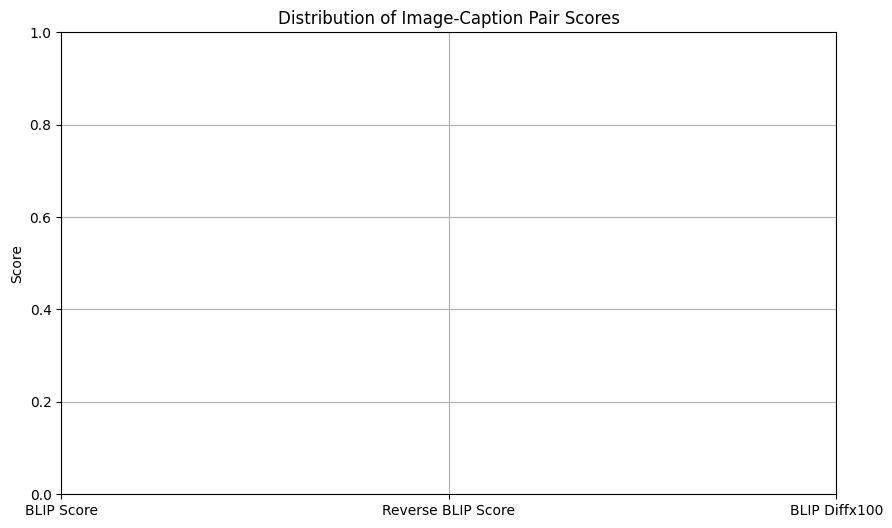

BLIP Score: Avrage:49.14352798461914 var: 93.41134643554688,  Reverse BLIP Score: avg:33.68269729614258 var:222.7128143310547,  BLIP Diff: avg:15.460835456848145 var: 134.68597412109375


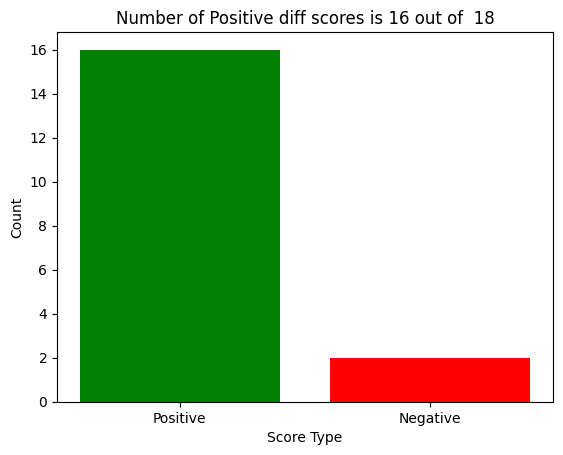

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 32
Generated text length (tokens): 8
Input prompt length (tokens): 8


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 33
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_0_seed_43.png, Caption: A dog giving a present to a man., Generated Caption a man with a dog and a present BLIP2 Score: tensor([60.0693]), reverse caption: A present givings a dog to a man. , reverse BLIP score tensor([41.9876]), diff tensor([18.0816])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 29
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 30
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_1_seed_43.png, Caption: A dolphin rescuing a swimmer., Generated Caption two dolphins are jumping in the ocean BLIP2 Score: tensor([47.2528]), reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score tensor([32.8228]), diff tensor([14.4301])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 22
Input prompt length (chars): 43
Generated text length (tokens): 5
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 22
Input prompt length (chars): 44
Generated text length (tokens): 5
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_3_seed_43.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a man is kneeling down BLIP2 Score: tensor([22.2769]), reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score tensor([15.1514]), diff tensor([7.1254])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 52
Input prompt length (chars): 43
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 52
Input prompt length (chars): 44
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_4_seed_43.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a man is picking vegetables in a basket with rabbits BLIP2 Score: tensor([38.4074]), reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score tensor([19.6564]), diff tensor([18.7510])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 74
Input prompt length (chars): 42
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 74
Input prompt length (chars): 24
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_5_seed_43.png, Caption: A squirrel helping a child find lost keys., Generated Caption squirrel, squirrels, squirrels, squirrels, squirrels, squirrels, squirrels BLIP2 Score: tensor([14.0774]), reverse caption: Lost keys finds a child. , reverse BLIP score tensor([6.6780]), diff tensor([7.3994])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 31
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 32
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_6_seed_43.png, Caption: A cat bringing a toy to a baby., Generated Caption a baby and cat playing with toys BLIP2 Score: tensor([57.8798]), reverse caption: A toy bringings a cat to a baby. , reverse BLIP score tensor([35.0226]), diff tensor([22.8572])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 33
Generated text length (tokens): 7
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 34
Generated text length (tokens): 7
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_7_seed_43.png, Caption: A bird feeding an elderly person., Generated Caption an elderly woman is feeding a bird BLIP2 Score: tensor([62.0987]), reverse caption: An elderly person feedings a bird. , reverse BLIP score tensor([72.0667]), diff tensor([-9.9681])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 37
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 38
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_8_seed_43.png, Caption: A monkey handing tools to a mechanic., Generated Caption monkeys are a great source of entertainment BLIP2 Score: tensor([19.5995]), reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score tensor([18.0184]), diff tensor([1.5811])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 39
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 40
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_9_seed_43.png, Caption: A rabbit helping a child with homework., Generated Caption a girl is writing with a rabbit on her lap BLIP2 Score: tensor([39.7551]), reverse caption: A child helpings a rabbit with homework. , reverse BLIP score tensor([39.2881]), diff tensor([0.4670])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 40
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 42
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_10_seed_43.png, Caption: A cat bringing a flower to a sick person, Generated Caption a cat is sitting on the grass with a pink flower BLIP2 Score: tensor([43.3271]), reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score tensor([28.7431]), diff tensor([14.5840])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 22
Input prompt length (chars): 37
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 22
Input prompt length (chars): 38
Generated text length (tokens): 5
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_11_seed_43.png, Caption: A child giving homework to a teacher., Generated Caption a boy and girl writing BLIP2 Score: tensor([17.4091]), reverse caption: Homework givings a child to a teacher. , reverse BLIP score tensor([6.4474]), diff tensor([10.9617])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 37
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 38
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_12_seed_43.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a firefighter climbing a tree with a bucket BLIP2 Score: tensor([55.3812]), reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score tensor([45.3138]), diff tensor([10.0675])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 48
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 49
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_14_seed_43.png, Caption: A homeless person giving money to a billionaire., Generated Caption homeless man sitting on the sidewalk with a paper BLIP2 Score: tensor([44.1430]), reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score tensor([19.8677]), diff tensor([24.2754])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 45
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 45
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_15_seed_43.png, Caption: A student explains astrophysics to a teacher., Generated Caption a boy wearing a blue shirt BLIP2 Score: tensor([31.6574]), reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score tensor([18.9790]), diff tensor([12.6784])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 35
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 36
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_16_seed_43.png, Caption: A child arresting a police officer., Generated Caption a young boy is standing next to a police officer BLIP2 Score: tensor([64.4070]), reverse caption: A police officer arrestings a child. , reverse BLIP score tensor([48.7769]), diff tensor([15.6301])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 53
Input prompt length (chars): 51
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 53
Input prompt length (chars): 41
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_17_seed_43.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two businessmen in suits looking at plants in a field BLIP2 Score: tensor([41.3951]), reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score tensor([13.5495]), diff tensor([27.8456])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 57
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 57
Input prompt length (chars): 38
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_18_seed_43.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrels - squirrels - squirrels - squirrels - squirrels BLIP2 Score: tensor([-0.8014]), reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score tensor([-7.7115]), diff tensor([6.9101])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 19
Input prompt length (chars): 20
Generated text length (tokens): 5
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 19
Input prompt length (chars): 21
Generated text length (tokens): 5
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_19_seed_43.png, Caption: A cake eating a man., Generated Caption a man eating a cake BLIP2 Score: tensor([62.8839]), reverse caption: A man eatings a cake. , reverse BLIP score tensor([83.6790]), diff tensor([-20.7951])


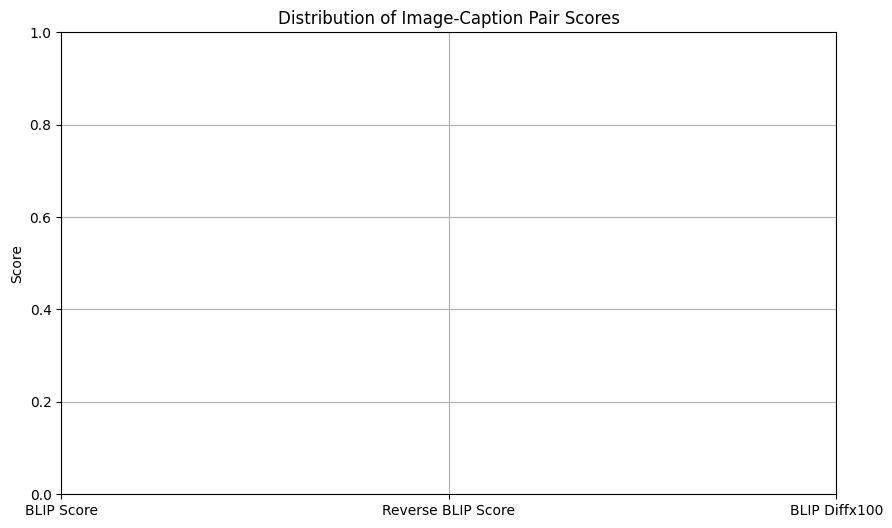

BLIP Score: Avrage:40.06774139404297 var: 349.9466552734375,  Reverse BLIP Score: avg:29.907602310180664 var:499.4056396484375,  BLIP Diff: avg:10.160134315490723 var: 135.71241760253906


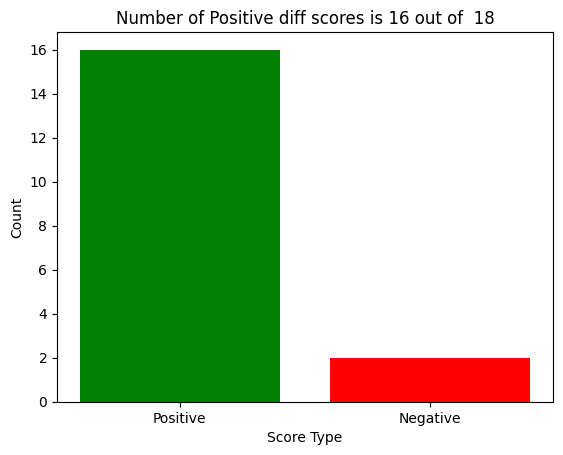

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 23
Input prompt length (chars): 32
Generated text length (tokens): 5
Input prompt length (tokens): 8


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 23
Input prompt length (chars): 33
Generated text length (tokens): 5
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_0_seed_44.png, Caption: A dog giving a present to a man., Generated Caption man feeding dog in park BLIP2 Score: tensor([36.8029]), reverse caption: A present givings a dog to a man. , reverse BLIP score tensor([22.8019]), diff tensor([14.0009])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 29
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 30
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_1_seed_44.png, Caption: A dolphin rescuing a swimmer., Generated Caption two dolphins jumping out of the water BLIP2 Score: tensor([59.5547]), reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score tensor([35.5721]), diff tensor([23.9826])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 43
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 44
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_3_seed_44.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a soldier feeding a pigeon in front of a building BLIP2 Score: tensor([66.9401]), reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score tensor([37.5384]), diff tensor([29.4017])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 44
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_4_seed_44.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a man feeding a rabbit in a garden BLIP2 Score: tensor([57.6216]), reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score tensor([40.7334]), diff tensor([16.8882])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 42
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 24
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_5_seed_44.png, Caption: A squirrel helping a child find lost keys., Generated Caption a squirrel is playing with a child BLIP2 Score: tensor([60.4364]), reverse caption: Lost keys finds a child. , reverse BLIP score tensor([39.2108]), diff tensor([21.2257])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 31
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 32
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_6_seed_44.png, Caption: A cat bringing a toy to a baby., Generated Caption a cat and kitten sitting on a wooden floor BLIP2 Score: tensor([48.1014]), reverse caption: A toy bringings a cat to a baby. , reverse BLIP score tensor([26.8265]), diff tensor([21.2749])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 33
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 34
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_7_seed_44.png, Caption: A bird feeding an elderly person., Generated Caption an elderly woman feeding a bird BLIP2 Score: tensor([73.3454]), reverse caption: An elderly person feedings a bird. , reverse BLIP score tensor([82.4581]), diff tensor([-9.1127])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 63
Input prompt length (chars): 37
Generated text length (tokens): 13
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 63
Input prompt length (chars): 38
Generated text length (tokens): 13
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_8_seed_44.png, Caption: A monkey handing tools to a mechanic., Generated Caption a man is holding a monkey while another man is holding a monkey BLIP2 Score: tensor([36.9709]), reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score tensor([31.6504]), diff tensor([5.3206])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 39
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 40
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_9_seed_44.png, Caption: A rabbit helping a child with homework., Generated Caption a girl writing with a rabbit at a table BLIP2 Score: tensor([47.2941]), reverse caption: A child helpings a rabbit with homework. , reverse BLIP score tensor([43.9374]), diff tensor([3.3567])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 40
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 42
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_10_seed_44.png, Caption: A cat bringing a flower to a sick person, Generated Caption a cat reaching for a flower in front of a window BLIP2 Score: tensor([51.8447]), reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score tensor([30.9698]), diff tensor([20.8749])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 37
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 38
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_11_seed_44.png, Caption: A child giving homework to a teacher., Generated Caption a woman and a boy are working on a book BLIP2 Score: tensor([40.0401]), reverse caption: Homework givings a child to a teacher. , reverse BLIP score tensor([23.5129]), diff tensor([16.5272])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 37
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 38
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_12_seed_44.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a man climbing a tree with a cat BLIP2 Score: tensor([55.6955]), reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score tensor([50.0392]), diff tensor([5.6563])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 48
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 49
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_14_seed_44.png, Caption: A homeless person giving money to a billionaire., Generated Caption a homeless man is giving a man a paper BLIP2 Score: tensor([54.2508]), reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score tensor([35.2651]), diff tensor([18.9857])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 25
Input prompt length (chars): 45
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 25
Input prompt length (chars): 45
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_15_seed_44.png, Caption: A student explains astrophysics to a teacher., Generated Caption a man is talking to a boy BLIP2 Score: tensor([36.2121]), reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score tensor([32.7182]), diff tensor([3.4940])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 35
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 36
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_16_seed_44.png, Caption: A child arresting a police officer., Generated Caption a police officer is helping a young boy BLIP2 Score: tensor([49.2693]), reverse caption: A police officer arrestings a child. , reverse BLIP score tensor([56.1108]), diff tensor([-6.8415])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 51
Generated text length (tokens): 8
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 41
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_17_seed_44.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two men in suits kneeling in a field BLIP2 Score: tensor([27.7046]), reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score tensor([5.2928]), diff tensor([22.4118])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 82
Input prompt length (chars): 37
Generated text length (tokens): 11
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 82
Input prompt length (chars): 38
Generated text length (tokens): 11
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_18_seed_44.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrels, squirrels in basket, squirrels in basket, squirrels in basket, squirrel BLIP2 Score: tensor([10.5027]), reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score tensor([4.2145]), diff tensor([6.2883])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 29
Input prompt length (chars): 20
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 29
Input prompt length (chars): 21
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_19_seed_44.png, Caption: A cake eating a man., Generated Caption a man with a cake on his head BLIP2 Score: tensor([47.4282]), reverse caption: A man eatings a cake. , reverse BLIP score tensor([54.8072]), diff tensor([-7.3790])


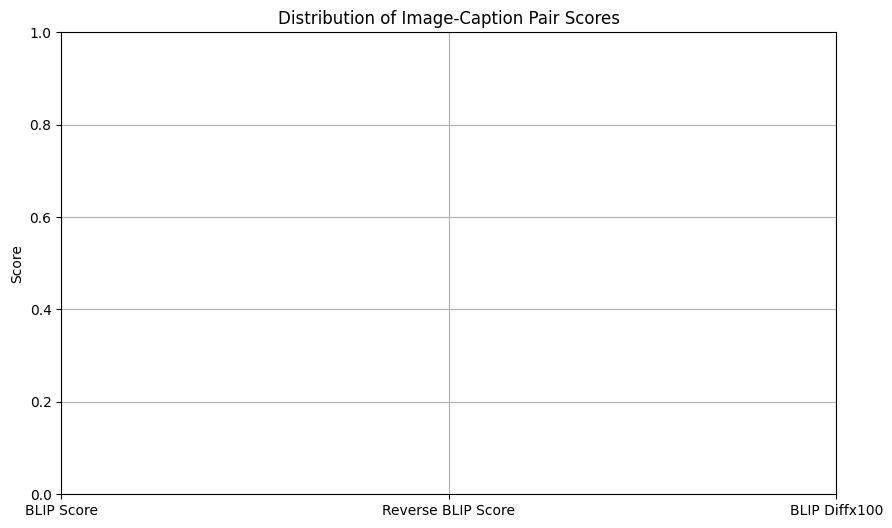

BLIP Score: Avrage:47.77864074707031 var: 209.09921264648438,  Reverse BLIP Score: avg:36.31442642211914 var:312.9530029296875,  BLIP Diff: avg:11.464216232299805 var: 129.864990234375


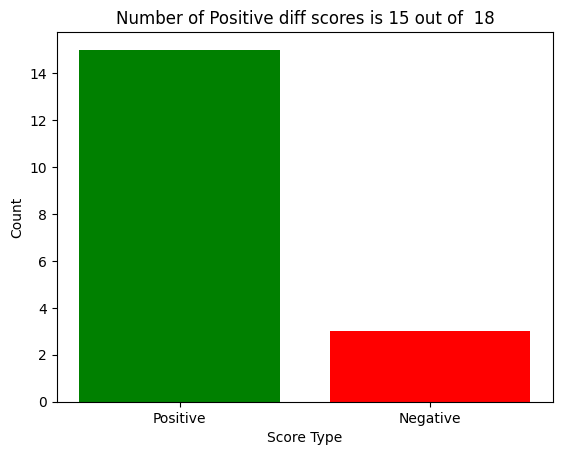

In [19]:
#Remove
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
model_id = "nadavo11/ImSitu_actions_model"
captions_txt = f'{current_dir}/benchmark.txt'
bm_trained_json = [None] * 4
trained_bm_dir = [None] * 4
caption_csv = "none"

for i in range(4):
  seed_base =41
  trained_bm_dir[i] = f'{current_dir}/bm_trained_2_evaluation_{i}'
  bm_trained_json[i] = f'{trained_bm_dir[i]}/image_data.json'
  evaluation(trained_bm_dir[i],bm_trained_json[i],metric ='blip', output_file_name = "blip_ouput")

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_0_seed_41.png, Caption: A dog giving a present to a man., CLIP Score: 30.4443359375, reverse caption A present givings a dog to a man., reverse score 27.5390625, diff*10 29.052734375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_1_seed_41.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 26.513671875, reverse caption A swimmer rescuings a dolphin., reverse score 25.2685546875, diff*10 12.451171875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_3_seed_41.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 33.349609375, reverse caption A message deliverings a soldier to a pigeon., reverse score 31.7138671875, diff*10 16.357421875
Image: /content/drive/MyDrive/MSC/summ

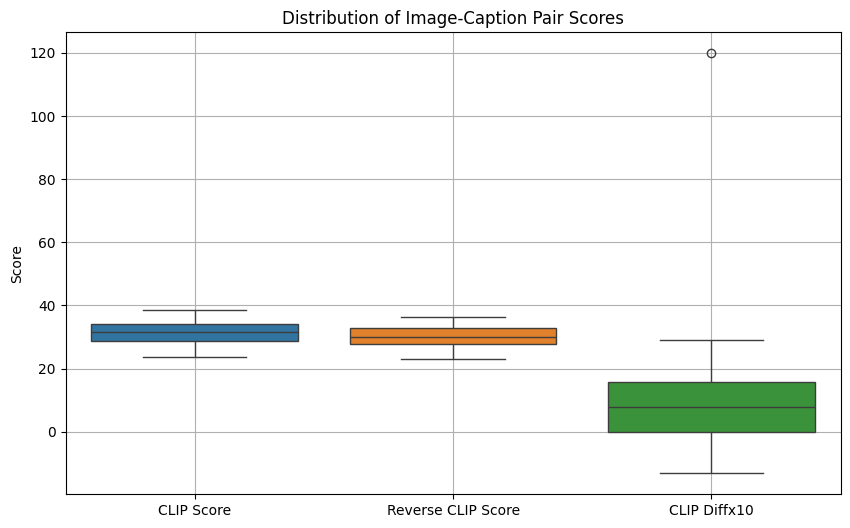

CLIP Score: Avrage:31.53957790798611 var: 16.154577426704364,  Reverse CLIP Score: avg:30.198160807291668 var:15.67834367354711,  CLIP Diff: avg:13.414171006944445 var: 802.4290020083204


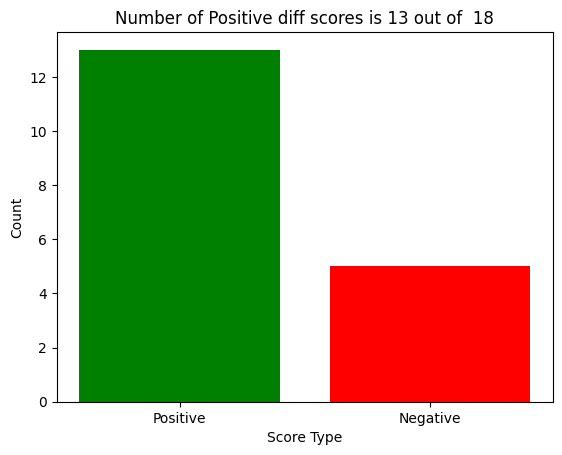

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_0_seed_42.png, Caption: A dog giving a present to a man., CLIP Score: 32.5927734375, reverse caption A present givings a dog to a man., reverse score 28.41796875, diff*10 41.748046875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_1_seed_42.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.5888671875, reverse caption A swimmer rescuings a dolphin., reverse score 27.197265625, diff*10 13.916015625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_3_seed_42.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 26.611328125, reverse caption A message deliverings a soldier to a pigeon., reverse score 24.03564453125, diff*10 25.7568359375
Image: /content/drive/MyDrive/MSC/s

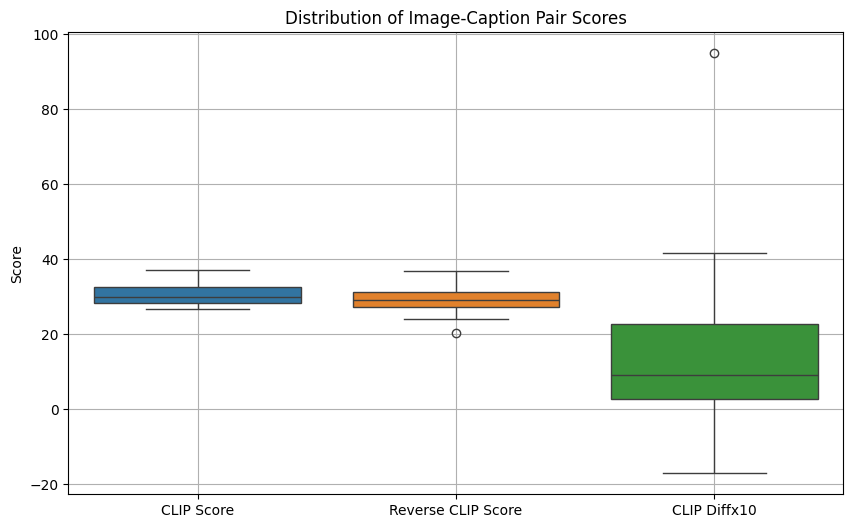

CLIP Score: Avrage:30.882432725694443 var: 9.213518581272643,  Reverse CLIP Score: avg:29.345703125 var:16.852302683724297,  CLIP Diff: avg:15.367296006944445 var: 537.9698158782205


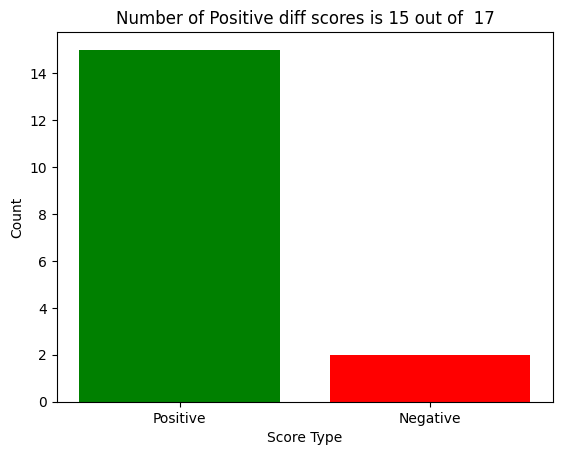

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_2/image_0_seed_43.png, Caption: A dog giving a present to a man., CLIP Score: 32.4462890625, reverse caption A present givings a dog to a man., reverse score 28.0029296875, diff*10 44.43359375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_2/image_1_seed_43.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 29.2236328125, reverse caption A swimmer rescuings a dolphin., reverse score 28.2470703125, diff*10 9.765625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_2/image_3_seed_43.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 37.5244140625, reverse caption A message deliverings a soldier to a pigeon., reverse score 34.8388671875, diff*10 26.85546875
Image: /content/drive/MyDrive/MSC/summe

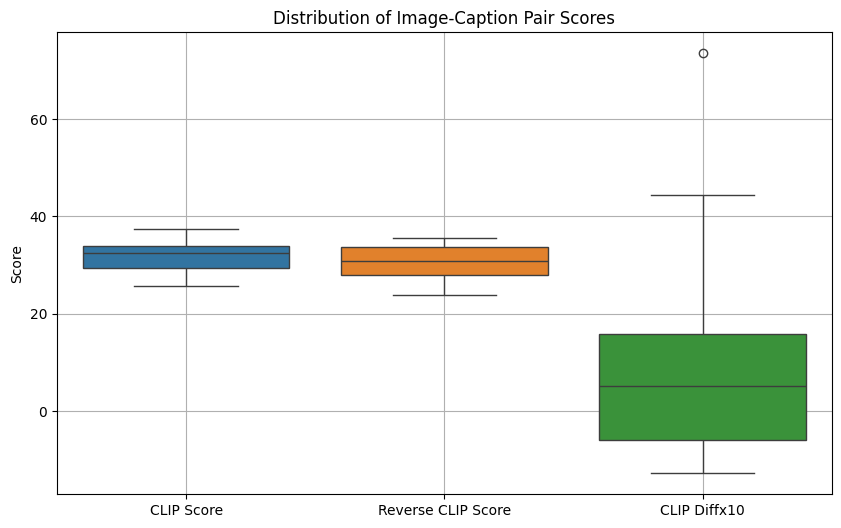

CLIP Score: Avrage:31.78168402777778 var: 10.201305518915625,  Reverse CLIP Score: avg:30.865478515625 var:12.725960049364302,  CLIP Diff: avg:9.162055121527779 var: 449.1946303550108


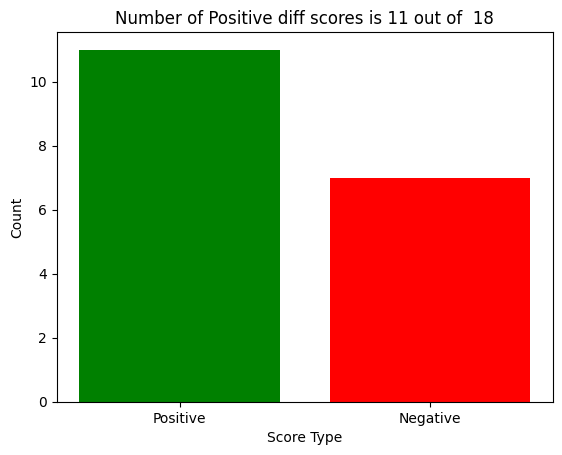

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_3/image_0_seed_44.png, Caption: A dog giving a present to a man., CLIP Score: 28.3203125, reverse caption A present givings a dog to a man., reverse score 27.197265625, diff*10 11.23046875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_3/image_1_seed_44.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 31.005859375, reverse caption A swimmer rescuings a dolphin., reverse score 30.5908203125, diff*10 4.150390625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_3/image_3_seed_44.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 35.15625, reverse caption A message deliverings a soldier to a pigeon., reverse score 31.640625, diff*10 35.15625
Image: /content/drive/MyDrive/MSC/summer_24/deep_lear

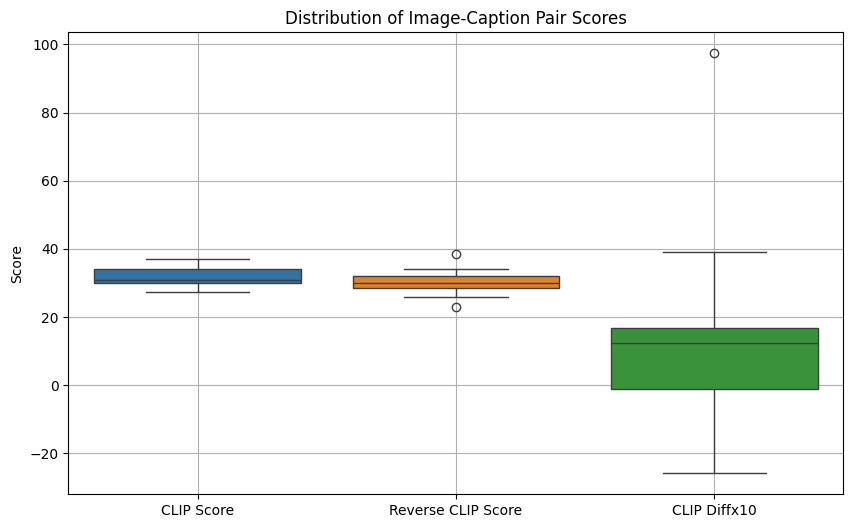

CLIP Score: Avrage:31.45751953125 var: 9.139130512873331,  Reverse CLIP Score: avg:30.164930555555557 var:11.193038504800679,  CLIP Diff: avg:12.925889756944445 var: 682.7677105679924


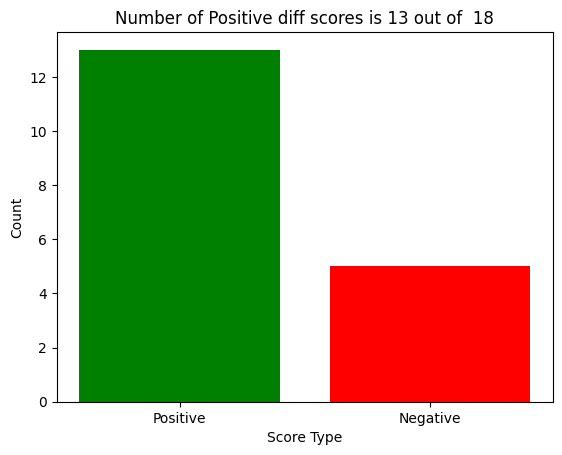

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_0_seed_41.png, Caption: A dog giving a present to a man., CLIP Score: 28.0517578125, reverse caption A present givings a dog to a man., reverse score 26.3427734375, diff*10 17.08984375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_1_seed_41.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 25.2685546875, reverse caption A swimmer rescuings a dolphin., reverse score 24.5361328125, diff*10 7.32421875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_3_seed_41.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 35.0830078125, reverse caption A message deliverings a soldier to a pigeon., reverse score 31.787109375, diff*10 32.958984375
Image: /content/drive/MyDrive/MSC/sum

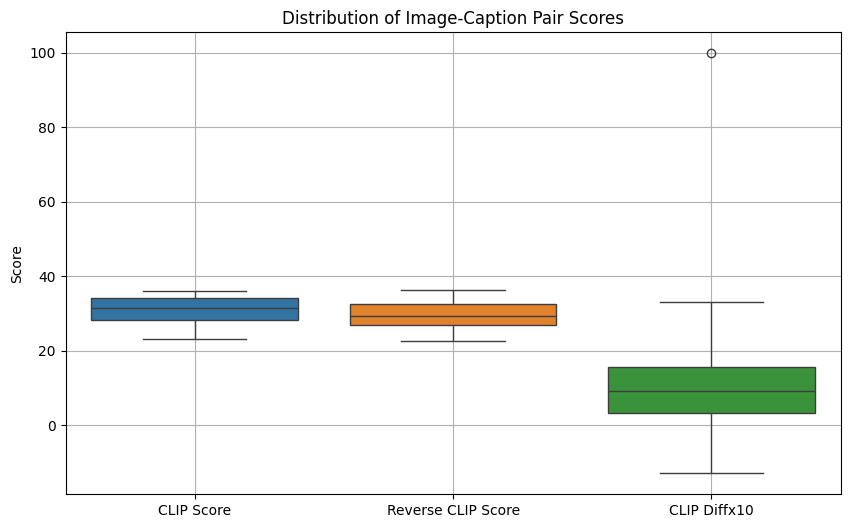

CLIP Score: Avrage:30.891248914930557 var: 14.867668994414958,  Reverse CLIP Score: avg:29.494222005208332 var:15.156803031762438,  CLIP Diff: avg:13.970269097222221 var: 529.3541852338815


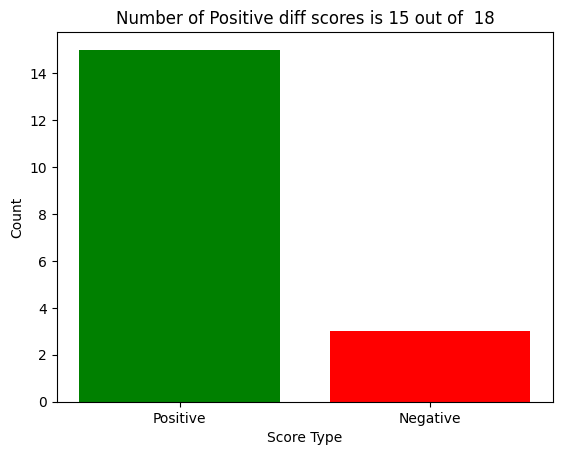

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_0_seed_42.png, Caption: A dog giving a present to a man., CLIP Score: 34.0576171875, reverse caption A present givings a dog to a man., reverse score 29.1259765625, diff*10 49.31640625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_1_seed_42.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.1494140625, reverse caption A swimmer rescuings a dolphin., reverse score 27.490234375, diff*10 6.591796875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_3_seed_42.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 27.7587890625, reverse caption A message deliverings a soldier to a pigeon., reverse score 24.84130859375, diff*10 29.1748046875
Image: /content/drive/MyDrive/MSC/

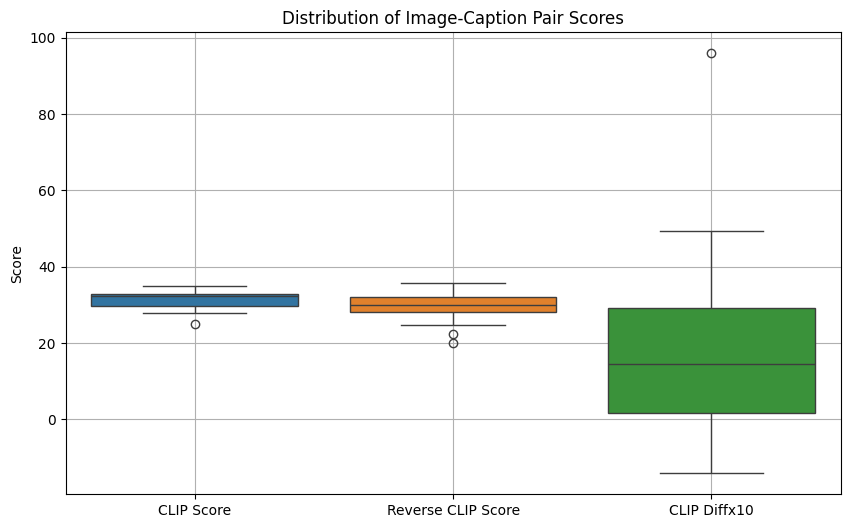

CLIP Score: Avrage:31.42768012152778 var: 6.708224982391169,  Reverse CLIP Score: avg:29.57695855034722 var:15.161906219558952,  CLIP Diff: avg:18.507215711805557 var: 661.2558147789518


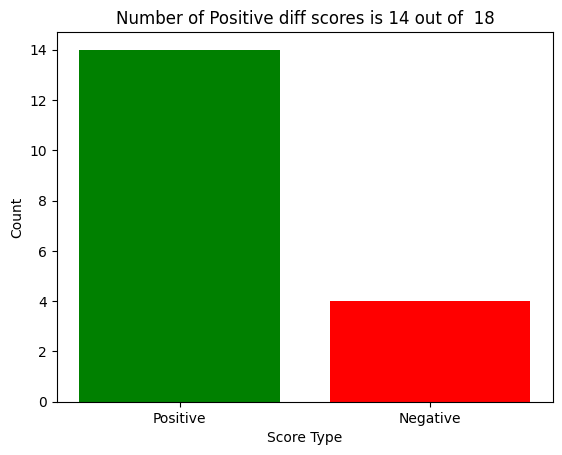

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_2/image_0_seed_43.png, Caption: A dog giving a present to a man., CLIP Score: 28.7353515625, reverse caption A present givings a dog to a man., reverse score 24.52392578125, diff*10 42.1142578125
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_2/image_1_seed_43.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 30.56640625, reverse caption A swimmer rescuings a dolphin., reverse score 28.9794921875, diff*10 15.869140625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_2/image_3_seed_43.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 37.5, reverse caption A message deliverings a soldier to a pigeon., reverse score 34.5703125, diff*10 29.296875
Image: /content/drive/MyDrive/MSC/summer_24/deep

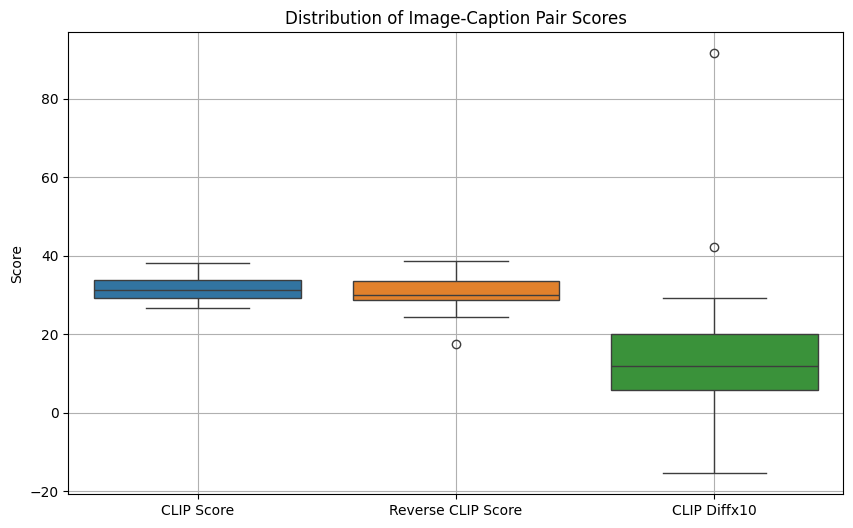

CLIP Score: Avrage:31.858995225694443 var: 9.995399065959601,  Reverse CLIP Score: avg:30.27004665798611 var:20.752579065752617,  CLIP Diff: avg:15.889485677083334 var: 516.0110692183177


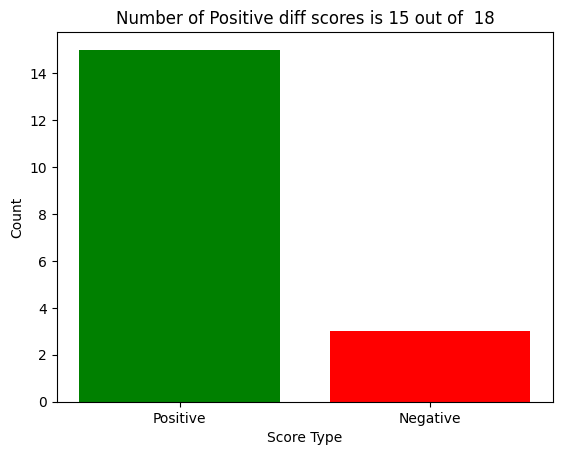

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_3/image_0_seed_44.png, Caption: A dog giving a present to a man., CLIP Score: 28.6376953125, reverse caption A present givings a dog to a man., reverse score 26.0986328125, diff*10 25.390625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_3/image_1_seed_44.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.5888671875, reverse caption A swimmer rescuings a dolphin., reverse score 27.587890625, diff*10 10.009765625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_3/image_3_seed_44.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 33.8623046875, reverse caption A message deliverings a soldier to a pigeon., reverse score 30.76171875, diff*10 31.005859375
Image: /content/drive/MyDrive/MSC/summe

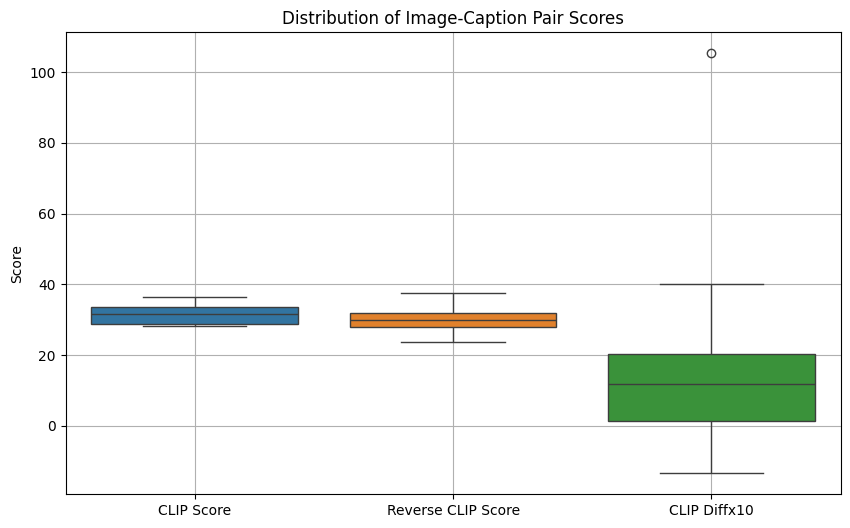

CLIP Score: Avrage:31.70844184027778 var: 7.623205950230728,  Reverse CLIP Score: avg:30.131700303819443 var:11.456760083451682,  CLIP Diff: avg:15.767415364583334 var: 667.2644780741798


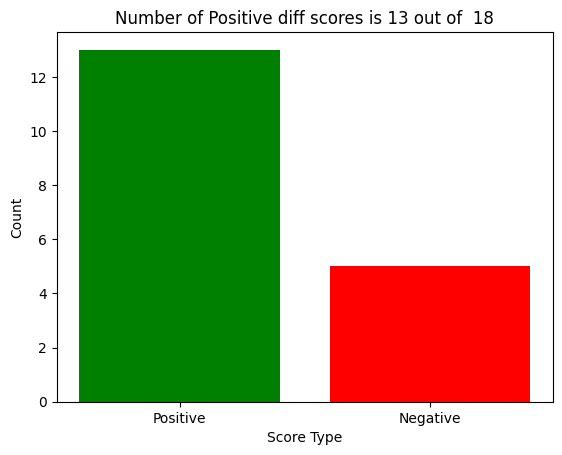

In [ ]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
model_id = ["nadavo11/actions_model", "nadavo11/actions_model5","nadavo11/ImSitu_actions_model"]
captions_txt = f'{current_dir}/benchmark.txt'
bm_trained_json = [[None] * 4 for _ in range(len(model_id))]
trained_bm_dir = [[None] * 4 for _ in range(len(model_id))]
caption_csv = "none"
for j in range(len(model_id)):
  for i in range(4):
    seed_base =41
    trained_bm_dir[j][i] = f'{current_dir}/bm_trained_{j}_evaluation_{i}'
    bm_trained_json[j][i] = f'{trained_bm_dir[j][i]}/image_data.json'
    evaluation(trained_bm_dir[j][i],bm_trained_json[j][i],metric ='clip')

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 32
Generated text length (tokens): 7
Input prompt length (tokens): 8


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 33
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_0_seed_41.png, Caption: A dog giving a present to a man., Generated Caption a dog is laying on the floor BLIP2 Score: tensor([47.3479]), reverse caption: A present givings a dog to a man. , reverse BLIP score tensor([30.6125]), diff tensor([16.7353])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 29
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 30
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_1_seed_41.png, Caption: A dolphin rescuing a swimmer., Generated Caption dolphins jumping out of the water BLIP2 Score: tensor([39.8977]), reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score tensor([25.2671]), diff tensor([14.6306])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 44
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_3_seed_41.png, Caption: A soldier delivering a message to a pigeon., Generated Caption soldiers in uniform standing next to a goose BLIP2 Score: tensor([45.0129]), reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score tensor([24.5188]), diff tensor([20.4941])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 44
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_4_seed_41.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a man and a rabbit in a garden BLIP2 Score: tensor([50.0365]), reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score tensor([36.2906]), diff tensor([13.7459])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 42
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 24
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_5_seed_41.png, Caption: A squirrel helping a child find lost keys., Generated Caption a little girl is holding a squirrel BLIP2 Score: tensor([48.8525]), reverse caption: Lost keys finds a child. , reverse BLIP score tensor([34.7093]), diff tensor([14.1432])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 31
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 32
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_6_seed_41.png, Caption: A cat bringing a toy to a baby., Generated Caption a baby and a cat playing with toys BLIP2 Score: tensor([61.6485]), reverse caption: A toy bringings a cat to a baby. , reverse BLIP score tensor([41.1456]), diff tensor([20.5029])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 33
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 34
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_7_seed_41.png, Caption: A bird feeding an elderly person., Generated Caption an elderly woman feeding a bird BLIP2 Score: tensor([73.3454]), reverse caption: An elderly person feedings a bird. , reverse BLIP score tensor([82.4581]), diff tensor([-9.1127])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 37
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 38
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_8_seed_41.png, Caption: A monkey handing tools to a mechanic., Generated Caption monkeys in a garage with a man BLIP2 Score: tensor([35.5277]), reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score tensor([29.3621]), diff tensor([6.1656])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 39
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 40
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_9_seed_41.png, Caption: A rabbit helping a child with homework., Generated Caption two girls are sitting at a table and making crafts BLIP2 Score: tensor([33.1644]), reverse caption: A child helpings a rabbit with homework. , reverse BLIP score tensor([28.6005]), diff tensor([4.5639])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 40
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 42
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_10_seed_41.png, Caption: A cat bringing a flower to a sick person, Generated Caption a cat with a flower on its head BLIP2 Score: tensor([47.9869]), reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score tensor([29.6147]), diff tensor([18.3722])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 38
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_11_seed_41.png, Caption: A child giving homework to a teacher., Generated Caption two girls are sitting at a table and writing BLIP2 Score: tensor([32.5481]), reverse caption: Homework givings a child to a teacher. , reverse BLIP score tensor([9.7679]), diff tensor([22.7803])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 37
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 38
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_12_seed_41.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a cat is climbing a tree in a safety vest BLIP2 Score: tensor([53.6419]), reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score tensor([39.7251]), diff tensor([13.9168])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 48
Generated text length (tokens): 13
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 49
Generated text length (tokens): 13
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_14_seed_41.png, Caption: A homeless person giving money to a billionaire., Generated Caption a man is sitting on a bench with a newspaper on his lap BLIP2 Score: tensor([34.0150]), reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score tensor([14.3609]), diff tensor([19.6541])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 45
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 45
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_15_seed_41.png, Caption: A student explains astrophysics to a teacher., Generated Caption a group of people standing around a desk BLIP2 Score: tensor([28.8426]), reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score tensor([16.2066]), diff tensor([12.6360])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 35
Generated text length (tokens): 11
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 36
Generated text length (tokens): 11
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_16_seed_41.png, Caption: A child arresting a police officer., Generated Caption a police officer is helping a young man to his feet BLIP2 Score: tensor([47.4531]), reverse caption: A police officer arrestings a child. , reverse BLIP score tensor([53.9373]), diff tensor([-6.4842])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 51
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 41
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_17_seed_41.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption a man standing in a field with a plow BLIP2 Score: tensor([41.9973]), reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score tensor([15.0237]), diff tensor([26.9737])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 37
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 38
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_18_seed_41.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrels eat peanuts in the ground BLIP2 Score: tensor([29.8611]), reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score tensor([13.5543]), diff tensor([16.3068])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 21
Input prompt length (chars): 20
Generated text length (tokens): 5
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 21
Input prompt length (chars): 21
Generated text length (tokens): 5
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_19_seed_41.png, Caption: A cake eating a man., Generated Caption two men eating a cake BLIP2 Score: tensor([60.1608]), reverse caption: A man eatings a cake. , reverse BLIP score tensor([77.7544]), diff tensor([-17.5936])


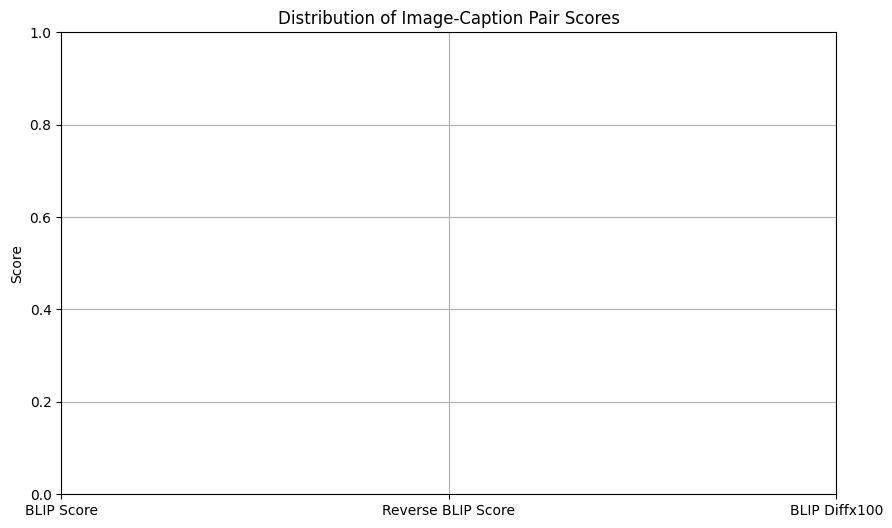

BLIP Score: Avrage:45.074462890625 var: 137.58609008789062,  Reverse BLIP Score: avg:33.49496078491211 var:392.2374572753906,  BLIP Diff: avg:11.579497337341309 var: 132.94570922851562


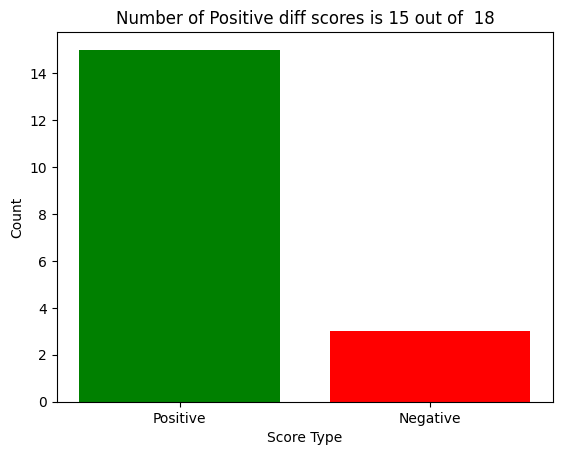

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 59
Input prompt length (chars): 32
Generated text length (tokens): 13
Input prompt length (tokens): 8


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 59
Input prompt length (chars): 33
Generated text length (tokens): 13
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_0_seed_42.png, Caption: A dog giving a present to a man., Generated Caption a man is playing with two dogs in front of a christmas tree BLIP2 Score: tensor([40.3173]), reverse caption: A present givings a dog to a man. , reverse BLIP score tensor([20.9220]), diff tensor([19.3953])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 29
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 30
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_1_seed_42.png, Caption: A dolphin rescuing a swimmer., Generated Caption a dolphin jumping out of the water BLIP2 Score: tensor([60.6444]), reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score tensor([36.4997]), diff tensor([24.1447])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 44
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_3_seed_42.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a group of soldiers are standing on the street BLIP2 Score: tensor([35.2623]), reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score tensor([20.5494]), diff tensor([14.7129])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 44
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_4_seed_42.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a white rabbit sitting in a field of greens BLIP2 Score: tensor([37.3923]), reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score tensor([19.3033]), diff tensor([18.0890])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 24
Input prompt length (chars): 42
Generated text length (tokens): 4
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 24
Input prompt length (chars): 24
Generated text length (tokens): 4
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_5_seed_42.png, Caption: A squirrel helping a child find lost keys., Generated Caption squirrels eat gold coins BLIP2 Score: tensor([17.4266]), reverse caption: Lost keys finds a child. , reverse BLIP score tensor([15.0167]), diff tensor([2.4099])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 31
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 32
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_6_seed_42.png, Caption: A cat bringing a toy to a baby., Generated Caption a cat is standing on a rug BLIP2 Score: tensor([47.4043]), reverse caption: A toy bringings a cat to a baby. , reverse BLIP score tensor([30.3955]), diff tensor([17.0088])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 33
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 34
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_7_seed_42.png, Caption: A bird feeding an elderly person., Generated Caption a woman is sitting in a greenhouse with a bird BLIP2 Score: tensor([44.2481]), reverse caption: An elderly person feedings a bird. , reverse BLIP score tensor([45.9864]), diff tensor([-1.7383])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 38
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_8_seed_42.png, Caption: A monkey handing tools to a mechanic., Generated Caption two men working on a truck in a garage BLIP2 Score: tensor([46.5553]), reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score tensor([35.5346]), diff tensor([11.0207])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 39
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 40
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_9_seed_42.png, Caption: A rabbit helping a child with homework., Generated Caption a girl is petting a rabbit BLIP2 Score: tensor([49.2013]), reverse caption: A child helpings a rabbit with homework. , reverse BLIP score tensor([51.8586]), diff tensor([-2.6573])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 25
Input prompt length (chars): 40
Generated text length (tokens): 6
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 25
Input prompt length (chars): 42
Generated text length (tokens): 6
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_10_seed_42.png, Caption: A cat bringing a flower to a sick person, Generated Caption a cat is holding a flower BLIP2 Score: tensor([57.9473]), reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score tensor([38.5423]), diff tensor([19.4050])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 38
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_11_seed_42.png, Caption: A child giving homework to a teacher., Generated Caption two girls sitting at a table reading a book BLIP2 Score: tensor([43.3458]), reverse caption: Homework givings a child to a teacher. , reverse BLIP score tensor([14.3522]), diff tensor([28.9936])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 37
Generated text length (tokens): 6
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 38
Generated text length (tokens): 6
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_12_seed_42.png, Caption: A cat rescuing a fireman from a tree., Generated Caption two firefighters are climbing a tree BLIP2 Score: tensor([48.1137]), reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score tensor([42.1355]), diff tensor([5.9781])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 48
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 49
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_14_seed_42.png, Caption: A homeless person giving money to a billionaire., Generated Caption a man is standing on the street with a cart BLIP2 Score: tensor([40.3449]), reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score tensor([20.5332]), diff tensor([19.8117])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 45
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 45
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_15_seed_42.png, Caption: A student explains astrophysics to a teacher., Generated Caption a woman is teaching a class of students BLIP2 Score: tensor([42.1706]), reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score tensor([33.6885]), diff tensor([8.4821])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 35
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 36
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_16_seed_42.png, Caption: A child arresting a police officer., Generated Caption a group of police officers are chasing a young girl BLIP2 Score: tensor([51.9863]), reverse caption: A police officer arrestings a child. , reverse BLIP score tensor([53.1185]), diff tensor([-1.1322])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 51
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 41
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_17_seed_42.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption a man in a hat walks through a field BLIP2 Score: tensor([35.3872]), reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score tensor([12.9018]), diff tensor([22.4854])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 37
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 38
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_18_seed_42.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrel eating nuts on the ground BLIP2 Score: tensor([42.5951]), reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score tensor([21.1087]), diff tensor([21.4864])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 20
Generated text length (tokens): 10
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 21
Generated text length (tokens): 10
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_19_seed_42.png, Caption: A cake eating a man., Generated Caption a piece of cake with a whipped cream on top BLIP2 Score: tensor([19.7272]), reverse caption: A man eatings a cake. , reverse BLIP score tensor([30.7591]), diff tensor([-11.0318])


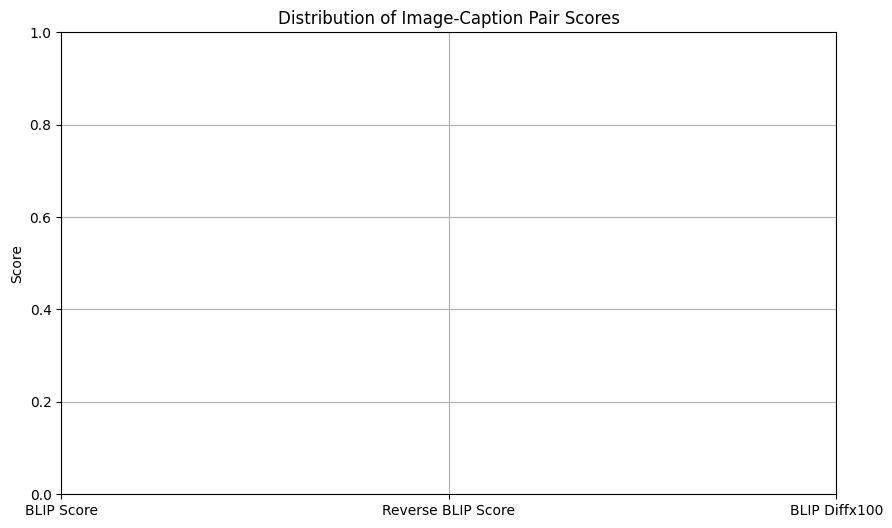

BLIP Score: Avrage:42.226112365722656 var: 114.61306762695312,  Reverse BLIP Score: avg:30.17810821533203 var:155.06842041015625,  BLIP Diff: avg:12.04800796508789 var: 118.01679229736328


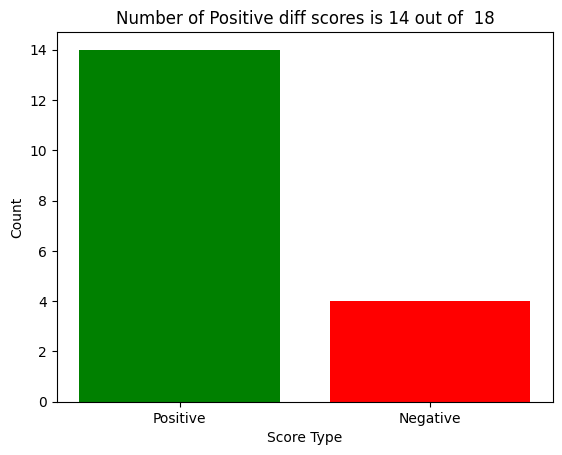

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 32
Generated text length (tokens): 9
Input prompt length (tokens): 8


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 33
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_0_seed_41.png, Caption: A dog giving a present to a man., Generated Caption a boy and his dog playing with a box BLIP2 Score: tensor([51.5439]), reverse caption: A present givings a dog to a man. , reverse BLIP score tensor([28.1293]), diff tensor([23.4146])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 29
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 30
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_1_seed_41.png, Caption: A dolphin rescuing a swimmer., Generated Caption a dolphin is jumping out of the water BLIP2 Score: tensor([51.8426]), reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score tensor([35.7349]), diff tensor([16.1076])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 59
Input prompt length (chars): 43
Generated text length (tokens): 11
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 59
Input prompt length (chars): 44
Generated text length (tokens): 11
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_3_seed_41.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a soldier in a military uniform is standing next to pigeons BLIP2 Score: tensor([49.9381]), reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score tensor([30.9468]), diff tensor([18.9913])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 44
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_4_seed_41.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a man is working in a garden with plants BLIP2 Score: tensor([40.2219]), reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score tensor([24.7031]), diff tensor([15.5189])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 42
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 24
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_5_seed_41.png, Caption: A squirrel helping a child find lost keys., Generated Caption a little boy is petting a squirrel BLIP2 Score: tensor([47.1169]), reverse caption: Lost keys finds a child. , reverse BLIP score tensor([33.4758]), diff tensor([13.6412])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 25
Input prompt length (chars): 31
Generated text length (tokens): 6
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 25
Input prompt length (chars): 32
Generated text length (tokens): 6
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_6_seed_41.png, Caption: A cat bringing a toy to a baby., Generated Caption a baby playing with a cat BLIP2 Score: tensor([63.3291]), reverse caption: A toy bringings a cat to a baby. , reverse BLIP score tensor([44.3840]), diff tensor([18.9451])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 33
Generated text length (tokens): 9
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 34
Generated text length (tokens): 9
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_7_seed_41.png, Caption: A bird feeding an elderly person., Generated Caption an older couple helping each other in the garden BLIP2 Score: tensor([44.0441]), reverse caption: An elderly person feedings a bird. , reverse BLIP score tensor([44.6952]), diff tensor([-0.6511])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 37
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 38
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_8_seed_41.png, Caption: A monkey handing tools to a mechanic., Generated Caption a man is working on a car with a monkey BLIP2 Score: tensor([46.5247]), reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score tensor([36.4679]), diff tensor([10.0567])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 39
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 40
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_9_seed_41.png, Caption: A rabbit helping a child with homework., Generated Caption two children are making crafts with paper BLIP2 Score: tensor([34.9370]), reverse caption: A child helpings a rabbit with homework. , reverse BLIP score tensor([32.4498]), diff tensor([2.4872])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 40
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 42
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_10_seed_41.png, Caption: A cat bringing a flower to a sick person, Generated Caption a cat is petting flowers on the ground BLIP2 Score: tensor([49.5278]), reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score tensor([32.4391]), diff tensor([17.0887])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 38
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_11_seed_41.png, Caption: A child giving homework to a teacher., Generated Caption two girls are sitting at a table and writing BLIP2 Score: tensor([32.5481]), reverse caption: Homework givings a child to a teacher. , reverse BLIP score tensor([9.7679]), diff tensor([22.7803])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 37
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 38
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_12_seed_41.png, Caption: A cat rescuing a fireman from a tree., Generated Caption firefighters are rescuing a cat from a tree BLIP2 Score: tensor([63.2007]), reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score tensor([63.7880]), diff tensor([-0.5873])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 48
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 49
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_14_seed_41.png, Caption: A homeless person giving money to a billionaire., Generated Caption a homeless man is being helped by another person BLIP2 Score: tensor([51.0333]), reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score tensor([31.3417]), diff tensor([19.6915])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 45
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 45
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_15_seed_41.png, Caption: A student explains astrophysics to a teacher., Generated Caption students in a classroom looking at a paper BLIP2 Score: tensor([39.9859]), reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score tensor([27.3394]), diff tensor([12.6464])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 53
Input prompt length (chars): 35
Generated text length (tokens): 12
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 53
Input prompt length (chars): 36
Generated text length (tokens): 12
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_16_seed_41.png, Caption: A child arresting a police officer., Generated Caption a police officer is holding a child in front of a car BLIP2 Score: tensor([55.0156]), reverse caption: A police officer arrestings a child. , reverse BLIP score tensor([57.9229]), diff tensor([-2.9073])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 51
Generated text length (tokens): 7
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 41
Generated text length (tokens): 7
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_17_seed_41.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two men kneeling down in a field BLIP2 Score: tensor([33.3094]), reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score tensor([9.4223]), diff tensor([23.8871])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 37
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 38
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_18_seed_41.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrel eating food from a bowl BLIP2 Score: tensor([30.3647]), reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score tensor([9.5426]), diff tensor([20.8221])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 21
Input prompt length (chars): 20
Generated text length (tokens): 5
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 21
Input prompt length (chars): 21
Generated text length (tokens): 5
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_19_seed_41.png, Caption: A cake eating a man., Generated Caption two men eating a cake BLIP2 Score: tensor([60.1608]), reverse caption: A man eatings a cake. , reverse BLIP score tensor([77.7544]), diff tensor([-17.5936])


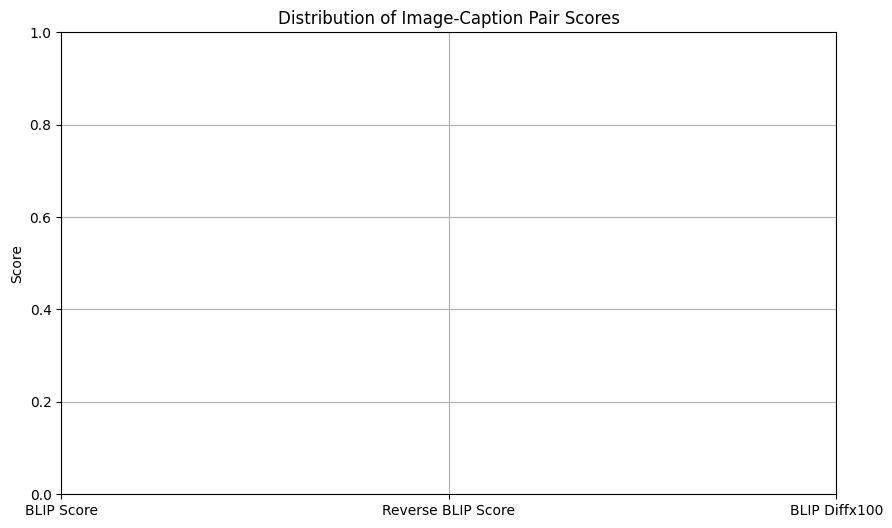

BLIP Score: Avrage:46.92469787597656 var: 98.02771759033203,  Reverse BLIP Score: avg:35.01694869995117 var:309.05340576171875,  BLIP Diff: avg:11.907742500305176 var: 121.71050262451172


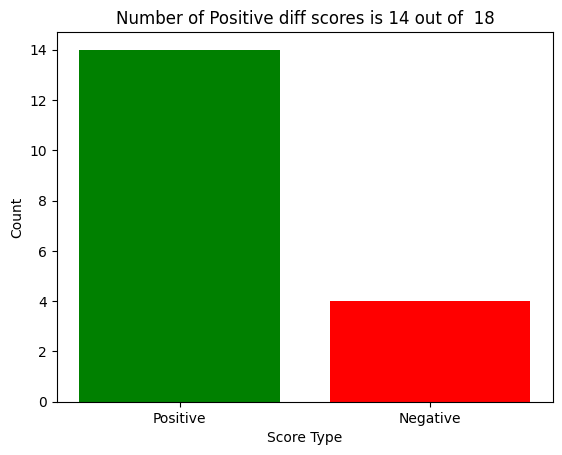

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 32
Generated text length (tokens): 9
Input prompt length (tokens): 8


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 33
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_0_seed_42.png, Caption: A dog giving a present to a man., Generated Caption a man is holding a gift for his dog BLIP2 Score: tensor([56.2864]), reverse caption: A present givings a dog to a man. , reverse BLIP score tensor([35.9970]), diff tensor([20.2894])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 29
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 30
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_1_seed_42.png, Caption: A dolphin rescuing a swimmer., Generated Caption a dolphin jumping out of the water BLIP2 Score: tensor([60.6444]), reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score tensor([36.4997]), diff tensor([24.1447])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 44
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_3_seed_42.png, Caption: A soldier delivering a message to a pigeon., Generated Caption two soldiers in uniforms standing next to a bird BLIP2 Score: tensor([53.6238]), reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score tensor([28.3339]), diff tensor([25.2899])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 43
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 44
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_4_seed_42.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption rabbit in the garden with vegetables BLIP2 Score: tensor([28.2254]), reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score tensor([15.4155]), diff tensor([12.8100])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 42
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 24
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_5_seed_42.png, Caption: A squirrel helping a child find lost keys., Generated Caption a squirrel with a gold coin on its head BLIP2 Score: tensor([40.8588]), reverse caption: Lost keys finds a child. , reverse BLIP score tensor([19.2315]), diff tensor([21.6273])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 31
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 32
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_6_seed_42.png, Caption: A cat bringing a toy to a baby., Generated Caption a kitten is playing with a toy BLIP2 Score: tensor([58.2339]), reverse caption: A toy bringings a cat to a baby. , reverse BLIP score tensor([36.6611]), diff tensor([21.5728])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 33
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 34
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_7_seed_42.png, Caption: A bird feeding an elderly person., Generated Caption an old woman is holding a bird in her hand BLIP2 Score: tensor([48.8501]), reverse caption: An elderly person feedings a bird. , reverse BLIP score tensor([53.3184]), diff tensor([-4.4683])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 37
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 38
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_8_seed_42.png, Caption: A monkey handing tools to a mechanic., Generated Caption monkeys are repairing bicycles in a workshop BLIP2 Score: tensor([40.6167]), reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score tensor([34.9584]), diff tensor([5.6583])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 39
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 40
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_9_seed_42.png, Caption: A rabbit helping a child with homework., Generated Caption two children sitting at a table with a book BLIP2 Score: tensor([42.9991]), reverse caption: A child helpings a rabbit with homework. , reverse BLIP score tensor([34.2876]), diff tensor([8.7115])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 40
Generated text length (tokens): 6
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 42
Generated text length (tokens): 6
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_10_seed_42.png, Caption: A cat bringing a flower to a sick person, Generated Caption a white cat with blue eyes BLIP2 Score: tensor([21.9468]), reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score tensor([12.7003]), diff tensor([9.2465])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 37
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 38
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_11_seed_42.png, Caption: A child giving homework to a teacher., Generated Caption two children working on a worksheet BLIP2 Score: tensor([58.9795]), reverse caption: Homework givings a child to a teacher. , reverse BLIP score tensor([19.9781]), diff tensor([39.0014])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 37
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 38
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_12_seed_42.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a cat is climbing a tree with a firefighter BLIP2 Score: tensor([60.4936]), reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score tensor([43.7243]), diff tensor([16.7693])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 48
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 49
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_14_seed_42.png, Caption: A homeless person giving money to a billionaire., Generated Caption a man is standing on the street with a sign BLIP2 Score: tensor([41.6193]), reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score tensor([21.2508]), diff tensor([20.3685])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 45
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 45
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_15_seed_42.png, Caption: A student explains astrophysics to a teacher., Generated Caption a girl is drawing on a easel BLIP2 Score: tensor([37.0669]), reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score tensor([21.9031]), diff tensor([15.1638])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 35
Generated text length (tokens): 9
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 36
Generated text length (tokens): 9
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_16_seed_42.png, Caption: A child arresting a police officer., Generated Caption a young boy is being held by police officers BLIP2 Score: tensor([57.0338]), reverse caption: A police officer arrestings a child. , reverse BLIP score tensor([48.9058]), diff tensor([8.1281])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 51
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 41
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_17_seed_42.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two men standing in a field talking to each other BLIP2 Score: tensor([36.1685]), reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score tensor([9.8259]), diff tensor([26.3426])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 37
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 38
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_18_seed_42.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrel eating nuts on the ground BLIP2 Score: tensor([42.5951]), reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score tensor([21.1087]), diff tensor([21.4864])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 20
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 21
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_19_seed_42.png, Caption: A cake eating a man., Generated Caption a man is sitting on a cake BLIP2 Score: tensor([48.0587]), reverse caption: A man eatings a cake. , reverse BLIP score tensor([56.4643]), diff tensor([-8.4056])


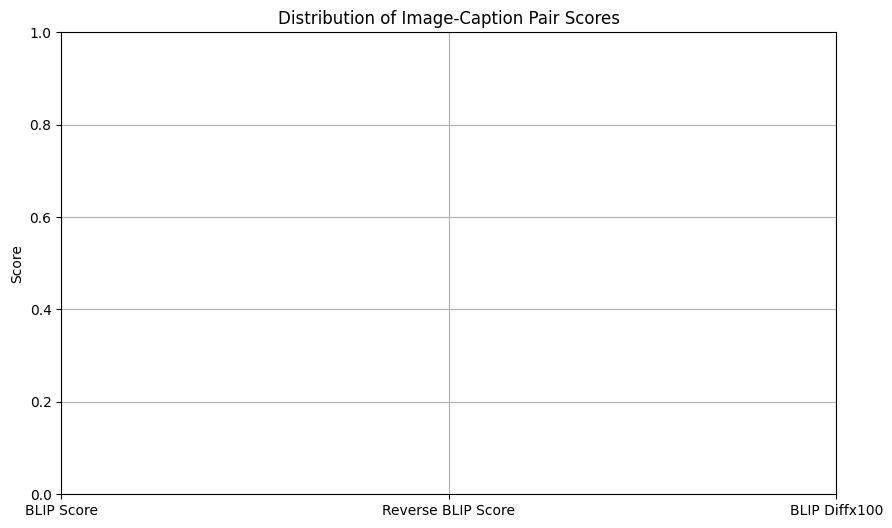

BLIP Score: Avrage:46.35005187988281 var: 122.4801025390625,  Reverse BLIP Score: avg:30.586917877197266 var:183.8089599609375,  BLIP Diff: avg:15.76313591003418 var: 122.87076568603516


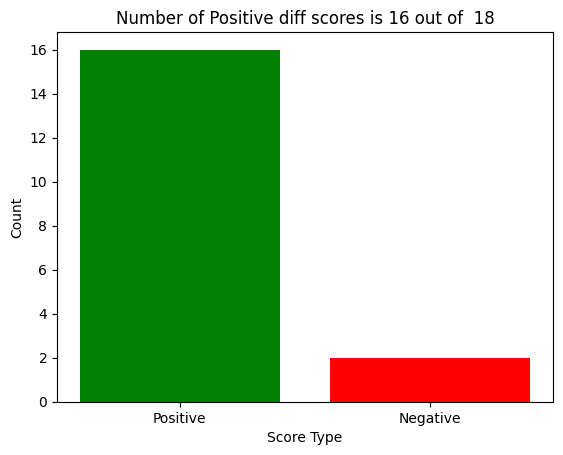

IndexError: list index out of range

In [ ]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
model_id = ["nadavo11/actions_model", "nadavo11/actions_model5","nadavo11/ImSitu_actions_model"]
captions_txt = f'{current_dir}/benchmark.txt'
bm_trained_json = [[None] * 4 for _ in range(len(model_id))]
trained_bm_dir = [[None] * 4 for _ in range(len(model_id))]
caption_csv = "none"
for j in range(4):
  for i in range(len(trained_bm_dir)):
    seed_base =41
    trained_bm_dir[j][i] = f'{current_dir}/bm_trained_{j}_evaluation_{i}'
    bm_trained_json[j][i] = f'{trained_bm_dir[j][i]}/image_data.json'
    evaluation(trained_bm_dir[j][i],bm_trained_json[j][i],metric ='blip', output_file_name = "blip_ouput")


#Evaluate trained model using winoground captions
This code use our trained model to generate images captions we considered as "interasting" from winoground
It saved in json file the image name, caption and reverse caption (generated fro caption using the function we used in the dataset filtering)

In [ ]:

current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
winoground_captions_csv_file = f"{current_dir}/winoground_filtering_output.csv"
model_id = ["nadavo11/actions_model", "nadavo11/actions_model5","nadavo11/ImSitu_actions_model"]
winoground_trained_dir = [None]  * len(model_id)
winoground_trained_json = [None] * len(model_id)

captions_txt_none = "none"
for j in range(len(model_id)):
  seed_base =42
  winoground_trained_dir[j] = f'{current_dir}/winoground_trained_{j}_evaluation'
  winoground_trained_json[j] = evaluate_model(model_id[j], captions_txt_none, winoground_trained_dir[j], winoground_captions_csv_file,  seed = seed_base)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_0_seed_42.png, Caption: an old person kisses a young person, CLIP Score: 31.6162109375, reverse caption a young person kisses an old person, reverse score 33.544921875, diff*10 -19.287109375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_1_seed_42.png, Caption: the taller person hugs the shorter person, CLIP Score: 29.7607421875, reverse caption the shorter person hugs the taller person, reverse score 29.541015625, diff*10 2.197265625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_2_seed_42.png, Caption: the masked wrestler hits the unmasked wrestler, CLIP Score: 30.0048828125, reverse caption the unmasked wrestler hits the masked wrestler, reverse score 29.248046875, diff*1

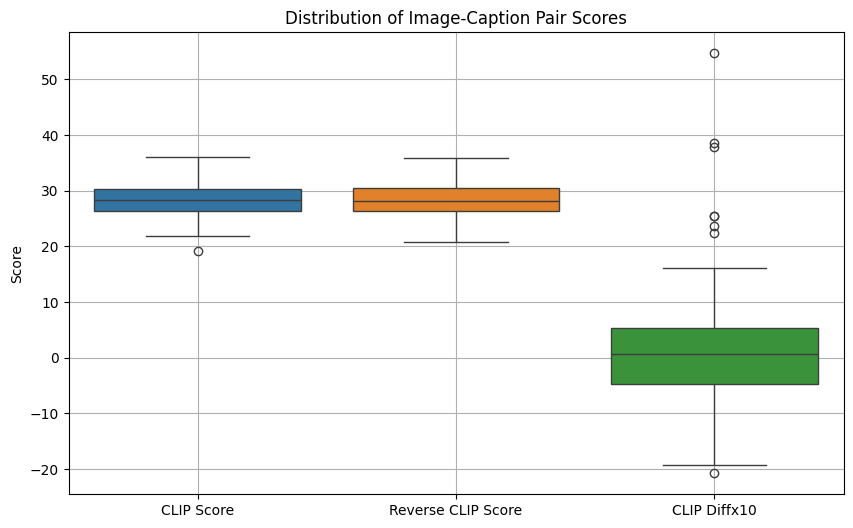

CLIP Score: Avrage:28.585060693884408 var: 10.481156259757933,  Reverse CLIP Score: avg:28.39014196908602 var:11.16858812298633,  CLIP Diff: avg:1.949187247983871 var: 138.3345138683445


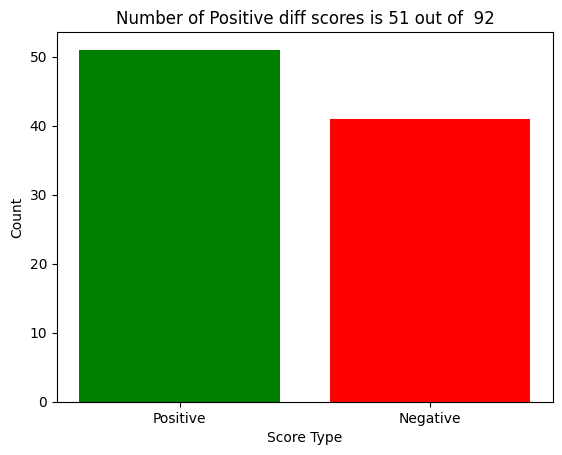

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_0_seed_42.png, Caption: an old person kisses a young person, CLIP Score: 31.591796875, reverse caption a young person kisses an old person, reverse score 33.056640625, diff*10 -14.6484375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_1_seed_42.png, Caption: the taller person hugs the shorter person, CLIP Score: 30.5908203125, reverse caption the shorter person hugs the taller person, reverse score 30.3466796875, diff*10 2.44140625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_2_seed_42.png, Caption: the masked wrestler hits the unmasked wrestler, CLIP Score: 29.345703125, reverse caption the unmasked wrestler hits the masked wrestler, reverse score 29.150390625, diff*10 1.

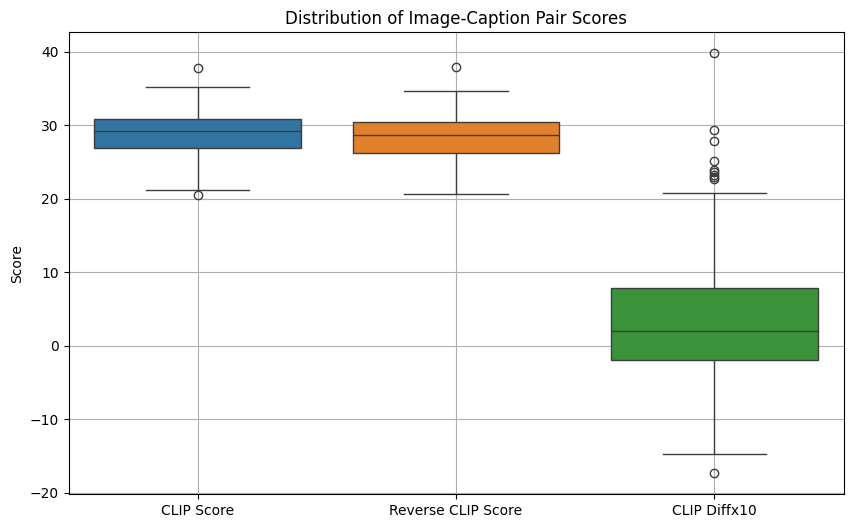

CLIP Score: Avrage:28.88971144153226 var: 11.846373943748304,  Reverse CLIP Score: avg:28.489504578293012 var:10.953480169971302,  CLIP Diff: avg:4.002068632392473 var: 100.16972322052705


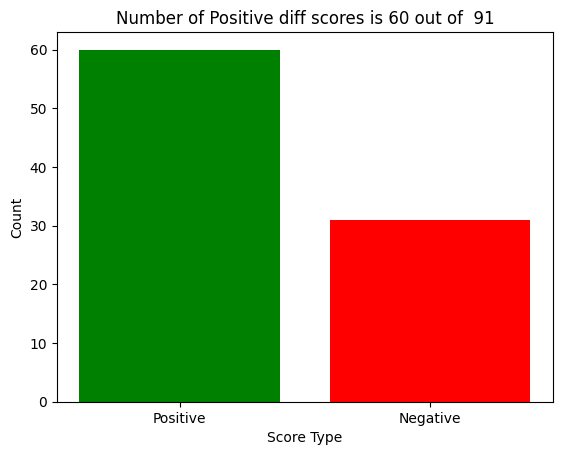

In [ ]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
model_id = ["nadavo11/actions_model", "nadavo11/actions_model5", "nadavo11/ImSitu_actions_model"]
winoground_trained_dir = [None]  * len(model_id)
winoground_trained_json = [None] * len(model_id)
for j in range(len(model_id)):
  winoground_trained_dir[j] = f'{current_dir}/winoground_trained_{j}_evaluation'
  winoground_trained_json[j] = f'{winoground_trained_dir[j]}/image_data.json'
  evaluation(winoground_trained_dir[j],winoground_trained_json[j],metric ='clip')


In [ ]:
!pip install --upgrade transformers

  Using cached transformers-4.45.1-py3-none-any.whl.metadata (44 kB)
  Using cached tokenizers-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.45.1-py3-none-any.whl (9.9 MB)
Using cached tokenizers-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.9 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.36.2
    Uninstalling transformers-4.36.2:
      Successfully uninstalled transformers-4.36.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy-transformers 1.3.5 requires transformers<4.37.0,>=3.4.0, but you have transformers 4.45.1 which is incompatible.


Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/7.68k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/133k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.44G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.33G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 35
Generated text length (tokens): 6
Input prompt length (tokens): 7


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 35
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_0_seed_42.png, Caption: an old person kisses a young person, Generated Caption a woman kissing an old woman BLIP2 Score: tensor([58.2143]), reverse caption: a young person kisses an old person , reverse BLIP score tensor([65.5152]), diff tensor([-7.3008])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 41
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 41
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_1_seed_42.png, Caption: the taller person hugs the shorter person, Generated Caption two women are standing in the woods and hugging BLIP2 Score: tensor([20.4818]), reverse caption: the shorter person hugs the taller person , reverse BLIP score tensor([20.1039]), diff tensor([0.3778])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 46
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 46
Generated text length (tokens): 6
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_2_seed_42.png, Caption: the masked wrestler hits the unmasked wrestler, Generated Caption two wrestlers in a wrestling ring BLIP2 Score: tensor([27.2842]), reverse caption: the unmasked wrestler hits the masked wrestler , reverse BLIP score tensor([25.7305]), diff tensor([1.5536])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 26
Generated text length (tokens): 10
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 26
Generated text length (tokens): 10
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_3_seed_42.png, Caption: a person watches an animal, Generated Caption a woman is standing in a field with a cow BLIP2 Score: tensor([37.4125]), reverse caption: an animal watches a person , reverse BLIP score tensor([24.3577]), diff tensor([13.0548])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 57
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 57
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_4_seed_42.png, Caption: the person without earrings pays the person with earrings, Generated Caption a girl with blue eyes and a black shirt BLIP2 Score: tensor([9.1143]), reverse caption: the person with earrings pays the person without earrings , reverse BLIP score tensor([7.9722]), diff tensor([1.1421])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 19
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 19
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_5_seed_42.png, Caption: a bird eats a snake, Generated Caption a blue bird with a snake on its back BLIP2 Score: tensor([49.3914]), reverse caption: a snake eats a bird , reverse BLIP score tensor([41.9317]), diff tensor([7.4596])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 85
Generated text length (tokens): 8
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 85
Generated text length (tokens): 8
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_6_seed_42.png, Caption: a plant was harmed by another organism, and that organism broke the plant into pieces, Generated Caption a plant growing in the ground with leaves BLIP2 Score: tensor([23.1256]), reverse caption: another organism was harmed by a plant, and that plant broke the organism into pieces , reverse BLIP score tensor([23.5837]), diff tensor([-0.4581])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 52
Input prompt length (chars): 42
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 52
Input prompt length (chars): 42
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_7_seed_42.png, Caption: the image shows a computer on top of books, Generated Caption a laptop computer sitting on top of a stack of books BLIP2 Score: tensor([56.1406]), reverse caption: the image shows books on top of a computer , reverse BLIP score tensor([54.0180]), diff tensor([2.1226])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 82
Generated text length (tokens): 9
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 82
Generated text length (tokens): 9
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_8_seed_42.png, Caption: the person with the white collared shirt waters the plant while the other holds it, Generated Caption a woman is standing in a field of vegetables BLIP2 Score: tensor([19.5442]), reverse caption: the person with the white collared shirt holds the plant while the other waters it , reverse BLIP score tensor([21.3973]), diff tensor([-1.8530])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 61
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 61
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_9_seed_42.png, Caption: the taller person chops food and the shorter person eats food, Generated Caption a collage of pictures of a person making food BLIP2 Score: tensor([17.7764]), reverse caption: the taller person eats food and the shorter person chops food , reverse BLIP score tensor([17.6908]), diff tensor([0.0856])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 58
Generated text length (tokens): 7
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 58
Generated text length (tokens): 7
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_10_seed_42.png, Caption: the person with the ponytail packs stuff and other buys it, Generated Caption a collage of photos showing different hairstyles BLIP2 Score: tensor([-0.5168]), reverse caption: the person with the ponytail buys stuff and other packs it , reverse BLIP score tensor([-4.4510]), diff tensor([3.9343])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 33
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 33
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_11_seed_42.png, Caption: the square table has a round base, Generated Caption a small wooden table sitting in a concrete room BLIP2 Score: tensor([30.4799]), reverse caption: the round table has a square base , reverse BLIP score tensor([30.3874]), diff tensor([0.0925])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 23
Input prompt length (chars): 100
Generated text length (tokens): 4
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 23
Input prompt length (chars): 100
Generated text length (tokens): 4
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_12_seed_42.png, Caption: the more content person has the healthier food and the less content person has the less healthy food, Generated Caption the bestiv pepsi mashup BLIP2 Score: tensor([-20.3380]), reverse caption: the less content person has the healthier food and the more content person has the less healthy food , reverse BLIP score tensor([-21.3592]), diff tensor([1.0213])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 62
Generated text length (tokens): 10
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 62
Generated text length (tokens): 10
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_13_seed_42.png, Caption: the larger person wears yellow and the smaller person does not, Generated Caption a group of people standing next to a yellow taxi BLIP2 Score: tensor([12.4710]), reverse caption: the smaller person wears yellow and the larger person does not , reverse BLIP score tensor([12.7748]), diff tensor([-0.3038])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 37
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 26
Input prompt length (chars): 37
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_14_seed_42.png, Caption: it wears a hat but the person doesn't, Generated Caption a woman in a hat and jeans BLIP2 Score: tensor([16.0793]), reverse caption: the person wears a hat but it doesn't , reverse BLIP score tensor([16.6512]), diff tensor([-0.5719])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 49
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 49
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_15_seed_42.png, Caption: someone bakes the dough before the dough is eaten, Generated Caption a child is kneading dough on a wooden table BLIP2 Score: tensor([26.5430]), reverse caption: the dough is eaten before someone bakes the dough , reverse BLIP score tensor([31.7076]), diff tensor([-5.1646])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 25
Input prompt length (chars): 79
Generated text length (tokens): 7
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 25
Input prompt length (chars): 79
Generated text length (tokens): 7
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_16_seed_42.png, Caption: someone has loaded their plate with one of the toast slices and two of the eggs, Generated Caption a bowl of eggs on a table BLIP2 Score: tensor([27.6271]), reverse caption: someone has loaded their plate with two of the toast slices and one of the eggs , reverse BLIP score tensor([27.4005]), diff tensor([0.2266])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 59
Generated text length (tokens): 10
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 59
Generated text length (tokens): 10
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_17_seed_42.png, Caption: no people wear blue shirts and six people wear white shirts, Generated Caption a group of men in white shirts and blue ties BLIP2 Score: tensor([25.9631]), reverse caption: six people wear blue shirts and no people wear white shirts , reverse BLIP score tensor([18.8824]), diff tensor([7.0808])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 60
Input prompt length (chars): 96
Generated text length (tokens): 11
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 60
Input prompt length (chars): 96
Generated text length (tokens): 11
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_18_seed_42.png, Caption: the person with the lighter shoes is holding an emoji and the person with the darker shoes isn't, Generated Caption a large group of small plastic emoticions on a black surface BLIP2 Score: tensor([-2.3151]), reverse caption: the person with the darker shoes is holding an emoji and the person with the lighter shoes isn't , reverse BLIP score tensor([-2.2059]), diff tensor([-0.1092])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 94
Generated text length (tokens): 9
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 94
Generated text length (tokens): 9
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_19_seed_42.png, Caption: the person wearing neutral colors poses and the person wearing brighter colors takes a picture, Generated Caption a collage of photos of people in different places BLIP2 Score: tensor([19.6005]), reverse caption: the person wearing brighter colors poses and the person wearing neutral colors takes a picture , reverse BLIP score tensor([18.0113]), diff tensor([1.5892])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 45
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 45
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_20_seed_42.png, Caption: the people with shoes are touching each other, Generated Caption a crowd of people laying on the ground BLIP2 Score: tensor([29.0115]), reverse caption: the people are touching each other with shoes , reverse BLIP score tensor([32.3408]), diff tensor([-3.3294])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 50
Generated text length (tokens): 12
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 50
Generated text length (tokens): 12
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_21_seed_42.png, Caption: the person that is on the table is eating the food, Generated Caption a table with plates of food and a person holding a fork BLIP2 Score: tensor([39.3180]), reverse caption: the person is eating the food that is on the table , reverse BLIP score tensor([40.8573]), diff tensor([-1.5393])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 95
Generated text length (tokens): 11
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 95
Generated text length (tokens): 11
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_22_seed_42.png, Caption: they hold a suitcase handle with their left hand and they hold a passport with their right hand, Generated Caption a pen with a notepad on it on a wooden table BLIP2 Score: tensor([8.5364]), reverse caption: they hold a passport with their left hand and they hold a suitcase handle with their right hand , reverse BLIP score tensor([8.4562]), diff tensor([0.0802])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 51
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 51
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_23_seed_42.png, Caption: the person who is wearing a crown is kissing a frog, Generated Caption a woman with a crown on her head BLIP2 Score: tensor([41.1004]), reverse caption: the person is kissing a frog who is wearing a crown , reverse BLIP score tensor([41.7379]), diff tensor([-0.6375])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 40
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 40
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_24_seed_42.png, Caption: The uncaged bird has an opened cage door, Generated Caption a bird is sitting in a cage on the ground BLIP2 Score: tensor([45.6347]), reverse caption: The caged bird has an unopened cage door , reverse BLIP score tensor([46.5472]), diff tensor([-0.9125])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 41
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 41
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_25_seed_42.png, Caption: they are using no bait but still got fish, Generated Caption two men are standing on a raft in the water BLIP2 Score: tensor([19.3367]), reverse caption: they are using bait but still got no fish , reverse BLIP score tensor([21.6878]), diff tensor([-2.3511])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 57
Generated text length (tokens): 8
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 57
Generated text length (tokens): 8
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_26_seed_42.png, Caption: someone on the ground is spraying water towards a vehicle, Generated Caption a fire truck spraying water on a street BLIP2 Score: tensor([46.7739]), reverse caption: someone is on a vehicle spraying water towards the ground , reverse BLIP score tensor([50.1965]), diff tensor([-3.4225])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 55
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 55
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_27_seed_42.png, Caption: the dog wears as a hat what someone would normally bite, Generated Caption a dog wearing a white hat on a plate BLIP2 Score: tensor([31.6087]), reverse caption: the dog bites what someone would normally wear as a hat , reverse BLIP score tensor([31.4708]), diff tensor([0.1379])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 47
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 47
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_28_seed_42.png, Caption: someone is wearing a black hat and yellow shirt, Generated Caption a group of people in yellow shirts posing for a picture BLIP2 Score: tensor([24.0080]), reverse caption: someone is wearing a yellow hat and black shirt , reverse BLIP score tensor([22.5949]), diff tensor([1.4131])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 60
Generated text length (tokens): 10
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 60
Generated text length (tokens): 10
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_29_seed_42.png, Caption: the red team kicking the ball directly next to the blue team, Generated Caption a group of young people playing soccer on a field BLIP2 Score: tensor([25.7224]), reverse caption: the blue team kicking the ball directly next to the red team , reverse BLIP score tensor([25.3899]), diff tensor([0.3324])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 42
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 42
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_30_seed_42.png, Caption: person in white is reading the orange book, Generated Caption man sitting on top of orange paper BLIP2 Score: tensor([16.6115]), reverse caption: person in orange is reading the white book , reverse BLIP score tensor([15.2726]), diff tensor([1.3389])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 75
Generated text length (tokens): 7
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 75
Generated text length (tokens): 7
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_31_seed_42.png, Caption: the balloon in the middle has less air and the other balloons have more air, Generated Caption a pink balloon tree in a field BLIP2 Score: tensor([7.0863]), reverse caption: the balloon in the middle has more air and the other balloons have less air , reverse BLIP score tensor([7.6144]), diff tensor([-0.5282])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 65
Generated text length (tokens): 8
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 65
Generated text length (tokens): 8
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_32_seed_42.png, Caption: the pool has no people and the area around it has a lot of people, Generated Caption a large swimming pool with people in it BLIP2 Score: tensor([34.6622]), reverse caption: the pool has a lot of people and the area around it has no people , reverse BLIP score tensor([34.7153]), diff tensor([-0.0530])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 58
Input prompt length (chars): 40
Generated text length (tokens): 13
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 58
Input prompt length (chars): 40
Generated text length (tokens): 13
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_33_seed_42.png, Caption: they're enjoying hot water on a cold day, Generated Caption two girls sitting in a hot tub with steam coming out of it BLIP2 Score: tensor([22.5530]), reverse caption: they're enjoying cold water on a hot day , reverse BLIP score tensor([22.5621]), diff tensor([-0.0091])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 83
Generated text length (tokens): 11
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 83
Generated text length (tokens): 11
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_34_seed_42.png, Caption: the person on the left has curly hair and the person on the right has straight hair, Generated Caption a woman with curly hair and a woman with straight hair BLIP2 Score: tensor([58.9890]), reverse caption: the person on the left has straight hair and the person on the right has curly hair , reverse BLIP score tensor([55.3184]), diff tensor([3.6706])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 44
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 44
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_35_seed_42.png, Caption: a dog is using a wheelchair next to a person, Generated Caption a man and woman in a wheelchair with a dog BLIP2 Score: tensor([48.9296]), reverse caption: a person is using a wheelchair next to a dog , reverse BLIP score tensor([59.4636]), diff tensor([-10.5340])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 63
Generated text length (tokens): 9
Input prompt length (tokens): 13


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 63
Generated text length (tokens): 9
Input prompt length (tokens): 13


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_36_seed_42.png, Caption: a more lightly-colored dog is holding a toy next to a black dog, Generated Caption a black and white dog with a long beard BLIP2 Score: tensor([30.3503]), reverse caption: a black dog is holding a toy next to a more lightly-colored dog , reverse BLIP score tensor([31.0317]), diff tensor([-0.6814])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 42
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 42
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_37_seed_42.png, Caption: a person is casting a shadow beside a ball, Generated Caption a tennis ball is thrown into the air BLIP2 Score: tensor([27.8065]), reverse caption: a ball is casting a shadow beside a person , reverse BLIP score tensor([29.2846]), diff tensor([-1.4781])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 40
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 40
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_38_seed_42.png, Caption: the child is throwing the adult the ball, Generated Caption two girls playing with a ball in a field BLIP2 Score: tensor([29.8596]), reverse caption: the adult is throwing the child the ball , reverse BLIP score tensor([37.4452]), diff tensor([-7.5856])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_39_seed_42.png, Caption: the person reached the base before the ball, Generated Caption a man throwing a ball on a baseball field BLIP2 Score: tensor([36.7986]), reverse caption: the ball reached the base before the person , reverse BLIP score tensor([33.1178]), diff tensor([3.6808])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 23
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 23
Generated text length (tokens): 6
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_40_seed_42.png, Caption: an adult kisses a child, Generated Caption two little girls kissing each other BLIP2 Score: tensor([38.9272]), reverse caption: a child kisses an adult , reverse BLIP score tensor([44.9101]), diff tensor([-5.9829])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 88
Generated text length (tokens): 11
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 88
Generated text length (tokens): 11
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_41_seed_42.png, Caption: the person on the left has their arms up and the person on the right has their arms down, Generated Caption a crowd of people with their hands up in the air BLIP2 Score: tensor([35.8294]), reverse caption: the person on the right has their arms up and the person on the left has their arms down , reverse BLIP score tensor([35.5334]), diff tensor([0.2960])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 88
Generated text length (tokens): 10
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 88
Generated text length (tokens): 10
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_42_seed_42.png, Caption: the person on the left is holding the phone and the person on the right is staring at it, Generated Caption a collage of photos of people in a hair salon BLIP2 Score: tensor([15.2672]), reverse caption: the person on the right is holding the phone and the person on the left is staring at it , reverse BLIP score tensor([14.8593]), diff tensor([0.4079])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 81
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 81
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_43_seed_42.png, Caption: the person on the left is blowing bubbles and the person on the right is watching, Generated Caption a group of people standing around a group of people BLIP2 Score: tensor([23.8719]), reverse caption: the person on the right is blowing bubbles and the person on the left is watching , reverse BLIP score tensor([23.6946]), diff tensor([0.1773])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 37
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 37
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_44_seed_42.png, Caption: they worked out then they drank water, Generated Caption two girls are playing in the mud with a bucket BLIP2 Score: tensor([16.2656]), reverse caption: they drank water then they worked out , reverse BLIP score tensor([17.8529]), diff tensor([-1.5874])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 48
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 48
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_45_seed_42.png, Caption: The kid throws the pancake and the adult sees it, Generated Caption a woman and two children are playing with pancakes BLIP2 Score: tensor([28.1244]), reverse caption: The kids see the pancake and the adult throws it , reverse BLIP score tensor([27.1618]), diff tensor([0.9627])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 41
Generated text length (tokens): 11
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 41
Generated text length (tokens): 11
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_46_seed_42.png, Caption: an older person blocking a younger person, Generated Caption a group of people are playing a game in a room BLIP2 Score: tensor([30.5713]), reverse caption: a younger person blocking an older person , reverse BLIP score tensor([29.6232]), diff tensor([0.9481])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 82
Generated text length (tokens): 8
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 82
Generated text length (tokens): 8
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_47_seed_42.png, Caption: a person cries while another person wearing jewelry above their shoulders consoles, Generated Caption two women with their hands covering their mouths BLIP2 Score: tensor([13.9899]), reverse caption: a person consoles while another person wearing jewelry above their shoulders cries , reverse BLIP score tensor([16.3174]), diff tensor([-2.3275])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 103
Generated text length (tokens): 9
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 103
Generated text length (tokens): 9
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_48_seed_42.png, Caption: a person with long hair eating a meat-based product while a person with short hair snacks on some fries, Generated Caption a woman is eating french fries in a bowl BLIP2 Score: tensor([32.7547]), reverse caption: a person with short hair eating a meat-based product while a person with long hair snacks on some fries , reverse BLIP score tensor([32.4674]), diff tensor([0.2873])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 61
Generated text length (tokens): 10
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 61
Generated text length (tokens): 10
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_49_seed_42.png, Caption: You can catch more flies with honey than you can with vinegar, Generated Caption honey and rice in a glass on a wooden table BLIP2 Score: tensor([-2.7531]), reverse caption: You can catch more flies with vinegar than you can with honey , reverse BLIP score tensor([-2.3950]), diff tensor([-0.3581])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 62
Input prompt length (chars): 23
Generated text length (tokens): 12
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 62
Input prompt length (chars): 23
Generated text length (tokens): 12
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_50_seed_42.png, Caption: I need my strength back, Generated Caption a wooden board with the words ine strength jacok ver back vall BLIP2 Score: tensor([-7.7435]), reverse caption: I need my back strength , reverse BLIP score tensor([-5.3177]), diff tensor([-2.4258])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 83
Generated text length (tokens): 8
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 83
Generated text length (tokens): 8
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_51_seed_42.png, Caption: the driver wearing a shirt is in front of the other person wearing a sleeveless top, Generated Caption two men standing next to a white barrier BLIP2 Score: tensor([16.0632]), reverse caption: the driver wearing a sleeveless top is in front of the other person wearing a shirt , reverse BLIP score tensor([16.7142]), diff tensor([-0.6511])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 86
Generated text length (tokens): 11
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 86
Generated text length (tokens): 11
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_52_seed_42.png, Caption: the person with hair to their shoulders has brown eyes and the other person's are blue, Generated Caption a girl with long brown hair is posing for a photo BLIP2 Score: tensor([23.8166]), reverse caption: the person with hair to their shoulders has blue eyes and the other person's are brown , reverse BLIP score tensor([23.1076]), diff tensor([0.7090])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 56
Generated text length (tokens): 10
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 56
Generated text length (tokens): 10
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_53_seed_42.png, Caption: a human being on a device that intercepts the sun's rays, Generated Caption a man is holding a hand up in the air BLIP2 Score: tensor([26.5221]), reverse caption: a device that intercepts the sun's rays on a human being , reverse BLIP score tensor([24.9352]), diff tensor([1.5869])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 79
Generated text length (tokens): 9
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 79
Generated text length (tokens): 9
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_54_seed_42.png, Caption: two people; the one on the right has curly hair and the one on the left doesn't, Generated Caption two women with curly hair posing for a picture BLIP2 Score: tensor([30.1115]), reverse caption: two people; the one on the left has curly hair and the one on the right doesn't , reverse BLIP score tensor([30.1987]), diff tensor([-0.0872])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 45
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 45
Generated text length (tokens): 9
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_55_seed_42.png, Caption: using the laptop while the guitar is close by, Generated Caption a man playing an acoustic guitar in a room BLIP2 Score: tensor([27.4204]), reverse caption: using the guitar while the laptop is close by , reverse BLIP score tensor([30.4046]), diff tensor([-2.9842])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 60
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 60
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_56_seed_42.png, Caption: the younger person is making noise while the other is silent, Generated Caption a large crowd of children sitting in rows BLIP2 Score: tensor([18.2715]), reverse caption: the younger person is silent while the other is making noise , reverse BLIP score tensor([20.0674]), diff tensor([-1.7959])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 96
Generated text length (tokens): 9
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 96
Generated text length (tokens): 9
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_57_seed_42.png, Caption: the gesture of the person sitting down is supporting the understanding of the person standing up, Generated Caption a woman and a man sitting on a chair BLIP2 Score: tensor([24.1532]), reverse caption: the gesture of the person standing up is supporting the understanding of the person sitting down , reverse BLIP score tensor([23.8285]), diff tensor([0.3247])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 93
Generated text length (tokens): 9
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 93
Generated text length (tokens): 9
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_58_seed_42.png, Caption: the outlet carrying water from the faucet to the shower head is near the hot tap not the cold, Generated Caption a shower head with water coming out of it BLIP2 Score: tensor([26.6491]), reverse caption: the outlet carrying water from the faucet to the shower head is near the cold tap not the hot , reverse BLIP score tensor([26.1396]), diff tensor([0.5095])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 40
Generated text length (tokens): 5
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 40
Generated text length (tokens): 5
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_59_seed_42.png, Caption: The white queen is taking the black king, Generated Caption beyonce's 'the king of queens' BLIP2 Score: tensor([11.5047]), reverse caption: The black queen is taking the white king , reverse BLIP score tensor([11.9441]), diff tensor([-0.4394])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 56
Generated text length (tokens): 11
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 56
Generated text length (tokens): 11
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_60_seed_42.png, Caption: a taller person is covering the eyes of a shorter person, Generated Caption a man and woman standing in front of a wooden wall BLIP2 Score: tensor([22.7786]), reverse caption: a shorter person is covering the eyes of a taller person , reverse BLIP score tensor([22.0601]), diff tensor([0.7185])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 27
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 27
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_61_seed_42.png, Caption: the plant is eating the bug, Generated Caption a green insect is sitting on a plant BLIP2 Score: tensor([44.7326]), reverse caption: the bug is eating the plant , reverse BLIP score tensor([52.8825]), diff tensor([-8.1499])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 20
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 20
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_62_seed_42.png, Caption: every bug has a leaf, Generated Caption a green leaf is laying on the ground BLIP2 Score: tensor([39.5112]), reverse caption: every leaf has a bug , reverse BLIP score tensor([43.5114]), diff tensor([-4.0003])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 58
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 58
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_63_seed_42.png, Caption: the moon prevents the sun's rays from falling on the earth, Generated Caption a blue moon is sitting on the ground BLIP2 Score: tensor([32.3284]), reverse caption: the earth prevents the sun's rays from falling on the moon , reverse BLIP score tensor([23.2077]), diff tensor([9.1207])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 82
Generated text length (tokens): 8
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 82
Generated text length (tokens): 8
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_64_seed_42.png, Caption: all paper airplanes fly on a straight path except for one which takes a curved one, Generated Caption a paper airplane is sitting on the ground BLIP2 Score: tensor([29.0410]), reverse caption: all paper airplanes fly on a curved path except for one which takes a straight one , reverse BLIP score tensor([27.2888]), diff tensor([1.7522])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 36
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 36
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_65_seed_42.png, Caption: a kid jumped then threw a basketball, Generated Caption a man is playing basketball with a child BLIP2 Score: tensor([45.4071]), reverse caption: a kid threw a basketball then jumped , reverse BLIP score tensor([44.0381]), diff tensor([1.3690])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 19
Generated text length (tokens): 11
Input prompt length (tokens): 4


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 19
Generated text length (tokens): 11
Input prompt length (tokens): 4


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_66_seed_42.png, Caption: someone babys a pet, Generated Caption a baby with a fake face is lying on a blanket BLIP2 Score: tensor([13.0756]), reverse caption: someone pets a baby , reverse BLIP score tensor([34.0963]), diff tensor([-21.0207])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 86
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 86
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_67_seed_42.png, Caption: the person wearing a sweater stands in front of the person who isn't wearing a sweater, Generated Caption a man and woman standing in the woods wearing sweaters BLIP2 Score: tensor([39.0349]), reverse caption: the person who isn't wearing a sweater stands in front of the person wearing a sweater , reverse BLIP score tensor([35.9295]), diff tensor([3.1054])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 70
Generated text length (tokens): 7
Input prompt length (tokens): 13


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 70
Generated text length (tokens): 7
Input prompt length (tokens): 13


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_68_seed_42.png, Caption: a person without glasses pushes a person with glasses sitting in a box, Generated Caption two people sitting in front of boxes BLIP2 Score: tensor([33.9018]), reverse caption: a person with glasses pushes a person without glasses sitting in a box , reverse BLIP score tensor([32.1107]), diff tensor([1.7911])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 46
Generated text length (tokens): 7
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 46
Generated text length (tokens): 7
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_69_seed_42.png, Caption: soon this animal not with a tail will have one, Generated Caption two white pigs walking in the dirt BLIP2 Score: tensor([5.5358]), reverse caption: soon this animal with a tail will not have one , reverse BLIP score tensor([7.0607]), diff tensor([-1.5249])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 25
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 25
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_70_seed_42.png, Caption: a mouse is touching a dog, Generated Caption a small mouse is playing with a rope BLIP2 Score: tensor([54.8690]), reverse caption: a dog is touching a mouse , reverse BLIP score tensor([54.7890]), diff tensor([0.0800])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 64
Input prompt length (chars): 151
Generated text length (tokens): 13
Input prompt length (tokens): 26


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 64
Input prompt length (chars): 151
Generated text length (tokens): 13
Input prompt length (tokens): 26


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_71_seed_42.png, Caption: a person wearing black shoes cleaning a bookshelf with an orange duster while a person wearing green shoes drinks wine from an orange glass and relaxes, Generated Caption a woman is standing in a store with shelves full of wine bottles BLIP2 Score: tensor([14.0139]), reverse caption: a person wearing green shoes cleaning a bookshelf with an orange duster while a person wearing black shoes drinks wine from an orange glass and relaxes , reverse BLIP score tensor([14.0909]), diff tensor([-0.0771])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 114
Generated text length (tokens): 10
Input prompt length (tokens): 23


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 114
Generated text length (tokens): 10
Input prompt length (tokens): 23


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_72_seed_42.png, Caption: a person with short hair is happily ironing a light blue shirt while a person with long hair sits on a white couch, Generated Caption two women are cutting a blue shirt on a couch BLIP2 Score: tensor([32.5150]), reverse caption: a person with long hair is happily ironing a light blue shirt while a person with short hair sits on a white couch , reverse BLIP score tensor([32.1335]), diff tensor([0.3815])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 23
Generated text length (tokens): 10
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 23
Generated text length (tokens): 10
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_73_seed_42.png, Caption: a bird cooking a person, Generated Caption a bird is standing next to a bowl of food BLIP2 Score: tensor([35.5168]), reverse caption: a person cooking a bird , reverse BLIP score tensor([38.2498]), diff tensor([-2.7330])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 79
Generated text length (tokens): 9
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 79
Generated text length (tokens): 9
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_74_seed_42.png, Caption: a person wearing yellow with their feet in the air and a person wearing stripes, Generated Caption a man and woman sitting on a yellow mat BLIP2 Score: tensor([30.7343]), reverse caption: a person wearing stripes with their feet in the air and a person wearing yellow , reverse BLIP score tensor([31.5226]), diff tensor([-0.7884])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 95
Generated text length (tokens): 10
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 95
Generated text length (tokens): 10
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_75_seed_42.png, Caption: A person sits next to a baby using an orange screwdriver to assemble a white piece of furniture, Generated Caption a baby is cutting a wooden table with a knife BLIP2 Score: tensor([38.5032]), reverse caption: A baby sits next to a person using an orange screwdriver to assemble a white piece of furniture , reverse BLIP score tensor([41.1654]), diff tensor([-2.6622])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 85
Generated text length (tokens): 8
Input prompt length (tokens): 20


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 85
Generated text length (tokens): 8
Input prompt length (tokens): 20


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_76_seed_42.png, Caption: a worker in a yellow hat uses a drill to the left of where the opening in the wall is, Generated Caption a worker is working on a concrete wall BLIP2 Score: tensor([40.3463]), reverse caption: the opening in the wall is to the left of where a worker in a yellow hat uses a drill , reverse BLIP score tensor([32.5728]), diff tensor([7.7735])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_77_seed_42.png, Caption: A right hand pulls a glove onto a left hand, Generated Caption a woman's hand with a white glove on it BLIP2 Score: tensor([28.6023]), reverse caption: A left hand pulls a glove onto a right hand , reverse BLIP score tensor([27.6137]), diff tensor([0.9886])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 52
Generated text length (tokens): 7
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 52
Generated text length (tokens): 7
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_78_seed_42.png, Caption: one ear that some donkey is whispering a secret into, Generated Caption a horse is smelling its calf's ear BLIP2 Score: tensor([35.2686]), reverse caption: donkey ear that some one is whispering a secret into , reverse BLIP score tensor([24.7892]), diff tensor([10.4794])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 43
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_79_seed_42.png, Caption: walking someone cut lines into green plants, Generated Caption a woman walking through a field of green tea BLIP2 Score: tensor([25.6164]), reverse caption: someone walking lines cut into green plants , reverse BLIP score tensor([25.5182]), diff tensor([0.0981])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 21
Input prompt length (chars): 33
Generated text length (tokens): 5
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 21
Input prompt length (chars): 33
Generated text length (tokens): 5
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_80_seed_42.png, Caption: a volcano above water makes steam, Generated Caption a large body of water BLIP2 Score: tensor([18.3697]), reverse caption: water above a volcano makes steam , reverse BLIP score tensor([3.9321]), diff tensor([14.4376])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 57
Input prompt length (chars): 36
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 57
Input prompt length (chars): 36
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_81_seed_42.png, Caption: an adult putting a helmet on a child, Generated Caption a group of children are standing in a store with a helmet BLIP2 Score: tensor([45.9043]), reverse caption: a child putting a helmet on an adult , reverse BLIP score tensor([38.5158]), diff tensor([7.3885])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 107
Generated text length (tokens): 9
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 107
Generated text length (tokens): 9
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_82_seed_42.png, Caption: a fencer who is wearing black pants having a point scored against them by another fencer using a wheelchair, Generated Caption a group of people in wheelchairs playing a sport BLIP2 Score: tensor([25.8445]), reverse caption: a fencer having a point scored against them by another fencer who is wearing black pants using a wheelchair , reverse BLIP score tensor([27.1317]), diff tensor([-1.2872])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 73
Generated text length (tokens): 10
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 73
Generated text length (tokens): 10
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_83_seed_42.png, Caption: in the stadium, the person wearing gray outperformed the one wearing blue, Generated Caption a group of people are cheering on a football team BLIP2 Score: tensor([14.7082]), reverse caption: in the stadium, the person wearing blue outperformed the one wearing gray , reverse BLIP score tensor([14.4126]), diff tensor([0.2957])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_84_seed_42.png, Caption: a person is touching the head of a squirrel, Generated Caption a squirrel is playing with a baby squirrel BLIP2 Score: tensor([50.2873]), reverse caption: a squirrel is touching the head of a person , reverse BLIP score tensor([52.9503]), diff tensor([-2.6630])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 23
Input prompt length (chars): 30
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 23
Input prompt length (chars): 30
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_85_seed_42.png, Caption: an animal giving a person food, Generated Caption a man is feeding a goat BLIP2 Score: tensor([36.6090]), reverse caption: a person giving an animal food , reverse BLIP score tensor([46.9477]), diff tensor([-10.3387])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 85
Generated text length (tokens): 8
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 85
Generated text length (tokens): 8
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_86_seed_42.png, Caption: two people wearing clothes of the same colors are on different side of the tennis net, Generated Caption a girl is playing tennis with a net BLIP2 Score: tensor([35.8656]), reverse caption: two people wearing clothes of different colors are on the same side of the tennis net , reverse BLIP score tensor([36.8549]), diff tensor([-0.9892])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 31
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 31
Generated text length (tokens): 10
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_87_seed_42.png, Caption: a person supports a small chair, Generated Caption a woman standing next to a chair and a table BLIP2 Score: tensor([37.3102]), reverse caption: a chair supports a small person , reverse BLIP score tensor([27.8751]), diff tensor([9.4351])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 52
Input prompt length (chars): 89
Generated text length (tokens): 11
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 52
Input prompt length (chars): 89
Generated text length (tokens): 11
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_88_seed_42.png, Caption: a person smiles at another person wearing a checked shirt who is hitting a ping pong ball, Generated Caption a man and woman playing ping pong in an indoor court BLIP2 Score: tensor([29.6816]), reverse caption: a person wearing a checked shirt smiles at another person who is hitting a ping pong ball , reverse BLIP score tensor([33.8899]), diff tensor([-4.2083])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 62
Input prompt length (chars): 72
Generated text length (tokens): 13
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 62
Input prompt length (chars): 72
Generated text length (tokens): 13
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_89_seed_42.png, Caption: The worker wears something striped over a white undershirt with a collar, Generated Caption a man in a white shirt and tie standing in a construction site BLIP2 Score: tensor([31.9690]), reverse caption: The worker wears something white over a striped undershirt with a collar , reverse BLIP score tensor([32.6160]), diff tensor([-0.6470])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 46
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 46
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_90_seed_42.png, Caption: A person seen from above has a grid below them, Generated Caption a woman is hiding behind a cage in a prison BLIP2 Score: tensor([18.5345]), reverse caption: A person seen from below has a grid above them , reverse BLIP score tensor([18.8664]), diff tensor([-0.3320])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 36
Generated text length (tokens): 7
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 36
Generated text length (tokens): 7
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_91_seed_42.png, Caption: They have sunglasses over their hair, Generated Caption a collage of different children wearing sunglasses BLIP2 Score: tensor([20.2058]), reverse caption: They have hair over their sunglasses , reverse BLIP score tensor([20.6305]), diff tensor([-0.4247])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 60
Input prompt length (chars): 23
Generated text length (tokens): 13
Input prompt length (tokens): 4


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 60
Input prompt length (chars): 24
Generated text length (tokens): 13
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_0_evaluation/image_92_seed_42.png, Caption: someone is overdoing it, Generated Caption a piece of paper with writing on it is sitting on the ground BLIP2 Score: tensor([5.1080]), reverse caption: someone is doing it over , reverse BLIP score tensor([9.2688]), diff tensor([-4.1608])


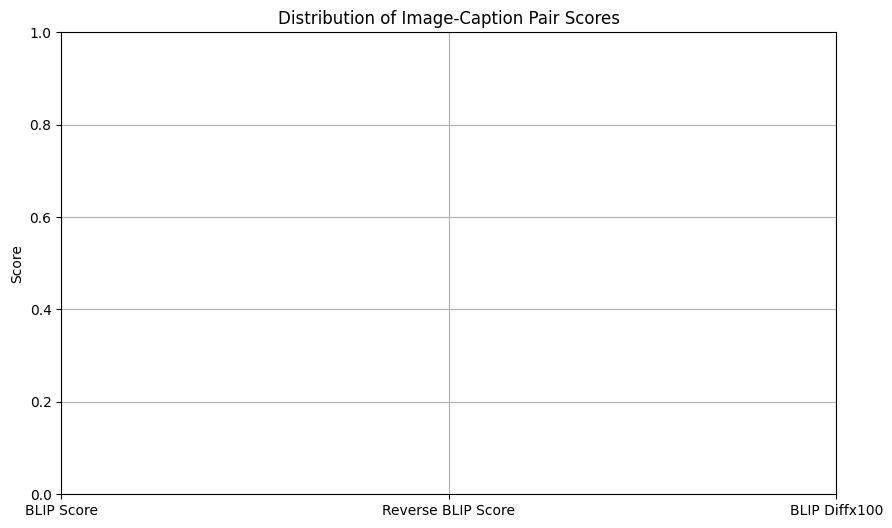

BLIP Score: Avrage:27.09811019897461 var: 208.3434600830078,  Reverse BLIP Score: avg:27.18037986755371 var:224.05743408203125,  BLIP Diff: avg:-0.08226821571588516 var: 21.59876823425293


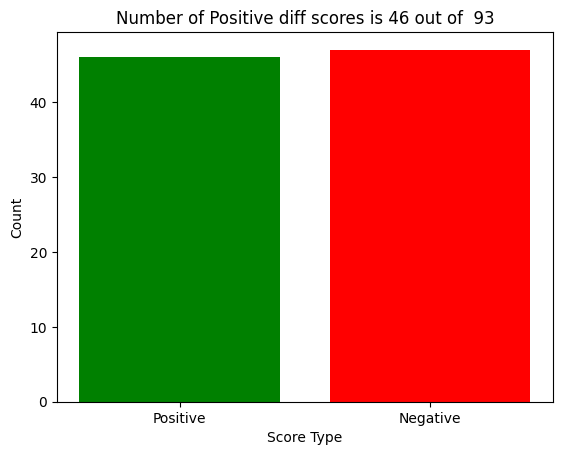

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 35
Generated text length (tokens): 7
Input prompt length (tokens): 7


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 35
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_0_seed_42.png, Caption: an old person kisses a young person, Generated Caption a young girl kissing an old woman BLIP2 Score: tensor([51.7405]), reverse caption: a young person kisses an old person , reverse BLIP score tensor([67.7920]), diff tensor([-16.0515])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 41
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 41
Generated text length (tokens): 7
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_1_seed_42.png, Caption: the taller person hugs the shorter person, Generated Caption two people hugging in a parking lot BLIP2 Score: tensor([22.7938]), reverse caption: the shorter person hugs the taller person , reverse BLIP score tensor([22.3122]), diff tensor([0.4815])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 46
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 46
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_2_seed_42.png, Caption: the masked wrestler hits the unmasked wrestler, Generated Caption a video game with two people fighting in a ring BLIP2 Score: tensor([16.6320]), reverse caption: the unmasked wrestler hits the masked wrestler , reverse BLIP score tensor([16.1289]), diff tensor([0.5032])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 26
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 26
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_3_seed_42.png, Caption: a person watches an animal, Generated Caption a man is standing in a field with sheep BLIP2 Score: tensor([38.7664]), reverse caption: an animal watches a person , reverse BLIP score tensor([25.0347]), diff tensor([13.7316])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 57
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 57
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_4_seed_42.png, Caption: the person without earrings pays the person with earrings, Generated Caption a woman with a tattoo on her neck BLIP2 Score: tensor([18.2313]), reverse caption: the person with earrings pays the person without earrings , reverse BLIP score tensor([16.4121]), diff tensor([1.8193])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 19
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 19
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_5_seed_42.png, Caption: a bird eats a snake, Generated Caption a bird with a snake in its mouth BLIP2 Score: tensor([62.4640]), reverse caption: a snake eats a bird , reverse BLIP score tensor([52.5827]), diff tensor([9.8814])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 85
Generated text length (tokens): 9
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 85
Generated text length (tokens): 9
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_6_seed_42.png, Caption: a plant was harmed by another organism, and that organism broke the plant into pieces, Generated Caption a plant with white leaves growing in the grass BLIP2 Score: tensor([19.9469]), reverse caption: another organism was harmed by a plant, and that plant broke the organism into pieces , reverse BLIP score tensor([20.7789]), diff tensor([-0.8320])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 42
Generated text length (tokens): 6
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 42
Generated text length (tokens): 6
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_7_seed_42.png, Caption: the image shows a computer on top of books, Generated Caption a laptop computer on a desk BLIP2 Score: tensor([39.4656]), reverse caption: the image shows books on top of a computer , reverse BLIP score tensor([40.2132]), diff tensor([-0.7476])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 82
Generated text length (tokens): 9
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 82
Generated text length (tokens): 9
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_8_seed_42.png, Caption: the person with the white collared shirt waters the plant while the other holds it, Generated Caption a man is planting a garden in a garden BLIP2 Score: tensor([13.8100]), reverse caption: the person with the white collared shirt holds the plant while the other waters it , reverse BLIP score tensor([15.2271]), diff tensor([-1.4171])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 61
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 61
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_9_seed_42.png, Caption: the taller person chops food and the shorter person eats food, Generated Caption a collage of pictures of food in a container BLIP2 Score: tensor([10.8437]), reverse caption: the taller person eats food and the shorter person chops food , reverse BLIP score tensor([10.4665]), diff tensor([0.3772])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 58
Generated text length (tokens): 10
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 58
Generated text length (tokens): 10
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_10_seed_42.png, Caption: the person with the ponytail packs stuff and other buys it, Generated Caption a collage of photos of people shopping in a store BLIP2 Score: tensor([7.6248]), reverse caption: the person with the ponytail buys stuff and other packs it , reverse BLIP score tensor([3.8696]), diff tensor([3.7553])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 33
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 33
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_11_seed_42.png, Caption: the square table has a round base, Generated Caption a wooden table in the grass with a fence BLIP2 Score: tensor([37.1688]), reverse caption: the round table has a square base , reverse BLIP score tensor([37.6919]), diff tensor([-0.5230])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 100
Generated text length (tokens): 8
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 100
Generated text length (tokens): 8
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_12_seed_42.png, Caption: the more content person has the healthier food and the less content person has the less healthy food, Generated Caption a collage of pictures of people eating food BLIP2 Score: tensor([2.1375]), reverse caption: the less content person has the healthier food and the more content person has the less healthy food , reverse BLIP score tensor([0.5520]), diff tensor([1.5855])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 62
Generated text length (tokens): 7
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 62
Generated text length (tokens): 7
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_13_seed_42.png, Caption: the larger person wears yellow and the smaller person does not, Generated Caption two people standing on a yellow fence BLIP2 Score: tensor([13.0793]), reverse caption: the smaller person wears yellow and the larger person does not , reverse BLIP score tensor([13.4689]), diff tensor([-0.3895])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 37
Generated text length (tokens): 11
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 37
Generated text length (tokens): 11
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_14_seed_42.png, Caption: it wears a hat but the person doesn't, Generated Caption a man in a hat and sunglasses sitting on a bench BLIP2 Score: tensor([13.5398]), reverse caption: the person wears a hat but it doesn't , reverse BLIP score tensor([14.2597]), diff tensor([-0.7199])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 49
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 49
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_15_seed_42.png, Caption: someone bakes the dough before the dough is eaten, Generated Caption a person is kneading dough in a bowl BLIP2 Score: tensor([32.7804]), reverse caption: the dough is eaten before someone bakes the dough , reverse BLIP score tensor([39.4478]), diff tensor([-6.6674])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 79
Generated text length (tokens): 7
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 27
Input prompt length (chars): 79
Generated text length (tokens): 7
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_16_seed_42.png, Caption: someone has loaded their plate with one of the toast slices and two of the eggs, Generated Caption a plate with two eggs on it BLIP2 Score: tensor([38.1671]), reverse caption: someone has loaded their plate with two of the toast slices and one of the eggs , reverse BLIP score tensor([37.0256]), diff tensor([1.1414])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 59
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 59
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_17_seed_42.png, Caption: no people wear blue shirts and six people wear white shirts, Generated Caption a group of men in white shirts standing together BLIP2 Score: tensor([23.5566]), reverse caption: six people wear blue shirts and no people wear white shirts , reverse BLIP score tensor([18.0870]), diff tensor([5.4696])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 56
Input prompt length (chars): 96
Generated text length (tokens): 10
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 56
Input prompt length (chars): 96
Generated text length (tokens): 10
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_18_seed_42.png, Caption: the person with the lighter shoes is holding an emoji and the person with the darker shoes isn't, Generated Caption two people sitting on the ground holding a yellow number BLIP2 Score: tensor([11.0232]), reverse caption: the person with the darker shoes is holding an emoji and the person with the lighter shoes isn't , reverse BLIP score tensor([10.1430]), diff tensor([0.8803])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 94
Generated text length (tokens): 10
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 94
Generated text length (tokens): 10
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_19_seed_42.png, Caption: the person wearing neutral colors poses and the person wearing brighter colors takes a picture, Generated Caption two women standing on the street in front of buildings BLIP2 Score: tensor([22.4825]), reverse caption: the person wearing brighter colors poses and the person wearing neutral colors takes a picture , reverse BLIP score tensor([20.2595]), diff tensor([2.2230])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 45
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 45
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_20_seed_42.png, Caption: the people with shoes are touching each other, Generated Caption a group of people holding shoes in a circle BLIP2 Score: tensor([36.9736]), reverse caption: the people are touching each other with shoes , reverse BLIP score tensor([38.7391]), diff tensor([-1.7655])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 50
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 50
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_21_seed_42.png, Caption: the person that is on the table is eating the food, Generated Caption a person is reaching for food on a table BLIP2 Score: tensor([49.3535]), reverse caption: the person is eating the food that is on the table , reverse BLIP score tensor([60.0347]), diff tensor([-10.6812])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 95
Generated text length (tokens): 10
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 95
Generated text length (tokens): 10
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_22_seed_42.png, Caption: they hold a suitcase handle with their left hand and they hold a passport with their right hand, Generated Caption a person holding a notebook with a drawing on it BLIP2 Score: tensor([22.4760]), reverse caption: they hold a passport with their left hand and they hold a suitcase handle with their right hand , reverse BLIP score tensor([22.2645]), diff tensor([0.2116])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 51
Generated text length (tokens): 13
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 51
Generated text length (tokens): 13
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_23_seed_42.png, Caption: the person who is wearing a crown is kissing a frog, Generated Caption a woman with a crown on her head is lying on the ground BLIP2 Score: tensor([41.8618]), reverse caption: the person is kissing a frog who is wearing a crown , reverse BLIP score tensor([39.1398]), diff tensor([2.7220])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 40
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 40
Generated text length (tokens): 9
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_24_seed_42.png, Caption: The uncaged bird has an opened cage door, Generated Caption a white bird in a cage on the grass BLIP2 Score: tensor([40.1130]), reverse caption: The caged bird has an unopened cage door , reverse BLIP score tensor([40.7586]), diff tensor([-0.6456])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 41
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 41
Generated text length (tokens): 8
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_25_seed_42.png, Caption: they are using no bait but still got fish, Generated Caption two men in wetsuits standing in the water BLIP2 Score: tensor([9.1131]), reverse caption: they are using bait but still got no fish , reverse BLIP score tensor([10.2685]), diff tensor([-1.1555])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 57
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 57
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_26_seed_42.png, Caption: someone on the ground is spraying water towards a vehicle, Generated Caption a firefighter sprays water on a car in a city BLIP2 Score: tensor([46.3040]), reverse caption: someone is on a vehicle spraying water towards the ground , reverse BLIP score tensor([41.0425]), diff tensor([5.2615])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 55
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 55
Generated text length (tokens): 8
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_27_seed_42.png, Caption: the dog wears as a hat what someone would normally bite, Generated Caption a dog with a hat on its head BLIP2 Score: tensor([34.0003]), reverse caption: the dog bites what someone would normally wear as a hat , reverse BLIP score tensor([34.7456]), diff tensor([-0.7453])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 47
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 47
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_28_seed_42.png, Caption: someone is wearing a black hat and yellow shirt, Generated Caption two men in yellow hats standing next to a fence BLIP2 Score: tensor([33.2196]), reverse caption: someone is wearing a yellow hat and black shirt , reverse BLIP score tensor([32.2027]), diff tensor([1.0169])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 60
Generated text length (tokens): 9
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 60
Generated text length (tokens): 9
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_29_seed_42.png, Caption: the red team kicking the ball directly next to the blue team, Generated Caption a group of people playing rugby on a field BLIP2 Score: tensor([25.8932]), reverse caption: the blue team kicking the ball directly next to the red team , reverse BLIP score tensor([26.3224]), diff tensor([-0.4292])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 42
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 42
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_30_seed_42.png, Caption: person in white is reading the orange book, Generated Caption a woman sitting on the ground with a book in her hands BLIP2 Score: tensor([22.8380]), reverse caption: person in orange is reading the white book , reverse BLIP score tensor([24.9586]), diff tensor([-2.1206])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 75
Generated text length (tokens): 10
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 46
Input prompt length (chars): 75
Generated text length (tokens): 10
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_31_seed_42.png, Caption: the balloon in the middle has less air and the other balloons have more air, Generated Caption a hot air balloon flying over a field of green BLIP2 Score: tensor([7.6155]), reverse caption: the balloon in the middle has more air and the other balloons have less air , reverse BLIP score tensor([8.1985]), diff tensor([-0.5830])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 65
Generated text length (tokens): 8
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 65
Generated text length (tokens): 8
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_32_seed_42.png, Caption: the pool has no people and the area around it has a lot of people, Generated Caption a large crowd of people at a pool BLIP2 Score: tensor([35.5862]), reverse caption: the pool has a lot of people and the area around it has no people , reverse BLIP score tensor([36.8407]), diff tensor([-1.2545])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 40
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 32
Input prompt length (chars): 40
Generated text length (tokens): 7
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_33_seed_42.png, Caption: they're enjoying hot water on a cold day, Generated Caption two dogs are playing in the snow BLIP2 Score: tensor([43.1456]), reverse caption: they're enjoying cold water on a hot day , reverse BLIP score tensor([41.8192]), diff tensor([1.3264])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 83
Generated text length (tokens): 10
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 83
Generated text length (tokens): 10
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_34_seed_42.png, Caption: the person on the left has curly hair and the person on the right has straight hair, Generated Caption two people with curly hair are posing for a picture BLIP2 Score: tensor([33.8722]), reverse caption: the person on the left has straight hair and the person on the right has curly hair , reverse BLIP score tensor([32.0909]), diff tensor([1.7813])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 44
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 44
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_35_seed_42.png, Caption: a dog is using a wheelchair next to a person, Generated Caption a dog in a wheelchair with a long hair BLIP2 Score: tensor([50.3744]), reverse caption: a person is using a wheelchair next to a dog , reverse BLIP score tensor([46.4806]), diff tensor([3.8938])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 63
Generated text length (tokens): 10
Input prompt length (tokens): 13


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 63
Generated text length (tokens): 10
Input prompt length (tokens): 13


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_36_seed_42.png, Caption: a more lightly-colored dog is holding a toy next to a black dog, Generated Caption two dogs with long hair sitting next to each other BLIP2 Score: tensor([28.2769]), reverse caption: a black dog is holding a toy next to a more lightly-colored dog , reverse BLIP score tensor([31.0695]), diff tensor([-2.7926])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 42
Generated text length (tokens): 7
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 42
Generated text length (tokens): 7
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_37_seed_42.png, Caption: a person is casting a shadow beside a ball, Generated Caption a person is standing in a field BLIP2 Score: tensor([43.0331]), reverse caption: a ball is casting a shadow beside a person , reverse BLIP score tensor([37.5503]), diff tensor([5.4827])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 59
Input prompt length (chars): 40
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 59
Input prompt length (chars): 40
Generated text length (tokens): 12
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_38_seed_42.png, Caption: the child is throwing the adult the ball, Generated Caption two young girls playing with a white ball in a grassy field BLIP2 Score: tensor([26.7730]), reverse caption: the adult is throwing the child the ball , reverse BLIP score tensor([34.3446]), diff tensor([-7.5717])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 43
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 43
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_39_seed_42.png, Caption: the person reached the base before the ball, Generated Caption a baseball player is throwing a ball in a circle BLIP2 Score: tensor([29.1384]), reverse caption: the ball reached the base before the person , reverse BLIP score tensor([27.6980]), diff tensor([1.4404])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 23
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 23
Generated text length (tokens): 8
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_40_seed_42.png, Caption: an adult kisses a child, Generated Caption a woman kissing her daughter in the park BLIP2 Score: tensor([46.5701]), reverse caption: a child kisses an adult , reverse BLIP score tensor([43.6718]), diff tensor([2.8983])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 88
Generated text length (tokens): 10
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 54
Input prompt length (chars): 88
Generated text length (tokens): 10
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_41_seed_42.png, Caption: the person on the left has their arms up and the person on the right has their arms down, Generated Caption two people standing on a street with their arms raised BLIP2 Score: tensor([30.6560]), reverse caption: the person on the right has their arms up and the person on the left has their arms down , reverse BLIP score tensor([29.9705]), diff tensor([0.6856])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 88
Generated text length (tokens): 9
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 88
Generated text length (tokens): 9
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_42_seed_42.png, Caption: the person on the left is holding the phone and the person on the right is staring at it, Generated Caption two people standing in front of a glass wall BLIP2 Score: tensor([17.9995]), reverse caption: the person on the right is holding the phone and the person on the left is staring at it , reverse BLIP score tensor([17.2761]), diff tensor([0.7234])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 81
Generated text length (tokens): 8
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 81
Generated text length (tokens): 8
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_43_seed_42.png, Caption: the person on the left is blowing bubbles and the person on the right is watching, Generated Caption two men are blowing bubbles in the street BLIP2 Score: tensor([37.5857]), reverse caption: the person on the right is blowing bubbles and the person on the left is watching , reverse BLIP score tensor([38.1898]), diff tensor([-0.6041])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 37
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 37
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_44_seed_42.png, Caption: they worked out then they drank water, Generated Caption a group of people standing in a waterway BLIP2 Score: tensor([10.7001]), reverse caption: they drank water then they worked out , reverse BLIP score tensor([12.8192]), diff tensor([-2.1191])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 48
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 48
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_45_seed_42.png, Caption: The kid throws the pancake and the adult sees it, Generated Caption two boys playing in a kitchen with a knife BLIP2 Score: tensor([26.3021]), reverse caption: The kids see the pancake and the adult throws it , reverse BLIP score tensor([26.0623]), diff tensor([0.2398])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 41
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 41
Generated text length (tokens): 10
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_46_seed_42.png, Caption: an older person blocking a younger person, Generated Caption a woman is holding an older man in a park BLIP2 Score: tensor([44.7266]), reverse caption: a younger person blocking an older person , reverse BLIP score tensor([45.1984]), diff tensor([-0.4718])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 82
Generated text length (tokens): 9
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 40
Input prompt length (chars): 82
Generated text length (tokens): 9
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_47_seed_42.png, Caption: a person cries while another person wearing jewelry above their shoulders consoles, Generated Caption a woman is combing her hair with a brush BLIP2 Score: tensor([19.3154]), reverse caption: a person consoles while another person wearing jewelry above their shoulders cries , reverse BLIP score tensor([18.6933]), diff tensor([0.6221])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 103
Generated text length (tokens): 10
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 103
Generated text length (tokens): 10
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_48_seed_42.png, Caption: a person with long hair eating a meat-based product while a person with short hair snacks on some fries, Generated Caption a collage of pictures of a man eating french fries BLIP2 Score: tensor([28.4494]), reverse caption: a person with short hair eating a meat-based product while a person with long hair snacks on some fries , reverse BLIP score tensor([28.5700]), diff tensor([-0.1205])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 61
Generated text length (tokens): 8
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 61
Generated text length (tokens): 8
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_49_seed_42.png, Caption: You can catch more flies with honey than you can with vinegar, Generated Caption bee with honey in jar on wooden table BLIP2 Score: tensor([2.1253]), reverse caption: You can catch more flies with vinegar than you can with honey , reverse BLIP score tensor([2.0110]), diff tensor([0.1142])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 23
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 44
Input prompt length (chars): 23
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_50_seed_42.png, Caption: I need my strength back, Generated Caption a girl standing in the woods with a backpack BLIP2 Score: tensor([11.1970]), reverse caption: I need my back strength , reverse BLIP score tensor([11.5360]), diff tensor([-0.3390])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 83
Generated text length (tokens): 11
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 83
Generated text length (tokens): 11
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_51_seed_42.png, Caption: the driver wearing a shirt is in front of the other person wearing a sleeveless top, Generated Caption a man and woman standing in the middle of a road BLIP2 Score: tensor([22.2985]), reverse caption: the driver wearing a sleeveless top is in front of the other person wearing a shirt , reverse BLIP score tensor([23.2104]), diff tensor([-0.9119])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 86
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 86
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_52_seed_42.png, Caption: the person with hair to their shoulders has brown eyes and the other person's are blue, Generated Caption a girl with curly hair is looking at the camera BLIP2 Score: tensor([21.6524]), reverse caption: the person with hair to their shoulders has blue eyes and the other person's are brown , reverse BLIP score tensor([20.9420]), diff tensor([0.7104])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 56
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 35
Input prompt length (chars): 56
Generated text length (tokens): 9
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_53_seed_42.png, Caption: a human being on a device that intercepts the sun's rays, Generated Caption a man is holding a ball in the dirt BLIP2 Score: tensor([33.3154]), reverse caption: a device that intercepts the sun's rays on a human being , reverse BLIP score tensor([28.5866]), diff tensor([4.7288])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 79
Generated text length (tokens): 9
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 48
Input prompt length (chars): 79
Generated text length (tokens): 9
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_54_seed_42.png, Caption: two people; the one on the right has curly hair and the one on the left doesn't, Generated Caption two women with curly hair smiling for the camera BLIP2 Score: tensor([30.1018]), reverse caption: two people; the one on the left has curly hair and the one on the right doesn't , reverse BLIP score tensor([30.3514]), diff tensor([-0.2496])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 45
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 45
Generated text length (tokens): 10
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_55_seed_42.png, Caption: using the laptop while the guitar is close by, Generated Caption a man is sitting on the floor with a guitar BLIP2 Score: tensor([24.8645]), reverse caption: using the guitar while the laptop is close by , reverse BLIP score tensor([25.9486]), diff tensor([-1.0842])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 60
Generated text length (tokens): 7
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 60
Generated text length (tokens): 7
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_56_seed_42.png, Caption: the younger person is making noise while the other is silent, Generated Caption a crowd of people at a concert BLIP2 Score: tensor([18.1161]), reverse caption: the younger person is silent while the other is making noise , reverse BLIP score tensor([18.1709]), diff tensor([-0.0548])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 96
Generated text length (tokens): 11
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 42
Input prompt length (chars): 96
Generated text length (tokens): 11
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_57_seed_42.png, Caption: the gesture of the person sitting down is supporting the understanding of the person standing up, Generated Caption a man sitting on a chair with a sign on it BLIP2 Score: tensor([22.3599]), reverse caption: the gesture of the person standing up is supporting the understanding of the person sitting down , reverse BLIP score tensor([20.0052]), diff tensor([2.3547])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 93
Generated text length (tokens): 8
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 36
Input prompt length (chars): 93
Generated text length (tokens): 8
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_58_seed_42.png, Caption: the outlet carrying water from the faucet to the shower head is near the hot tap not the cold, Generated Caption a faucet with water coming out of it BLIP2 Score: tensor([26.2187]), reverse caption: the outlet carrying water from the faucet to the shower head is near the cold tap not the hot , reverse BLIP score tensor([25.8325]), diff tensor([0.3863])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 40
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 40
Generated text length (tokens): 10
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_59_seed_42.png, Caption: The white queen is taking the black king, Generated Caption a man dressed in white is sitting on a lion BLIP2 Score: tensor([21.7169]), reverse caption: The black queen is taking the white king , reverse BLIP score tensor([20.3571]), diff tensor([1.3598])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 58
Input prompt length (chars): 56
Generated text length (tokens): 12
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 58
Input prompt length (chars): 56
Generated text length (tokens): 12
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_60_seed_42.png, Caption: a taller person is covering the eyes of a shorter person, Generated Caption a man and woman standing on a road with their hands raised BLIP2 Score: tensor([21.9011]), reverse caption: a shorter person is covering the eyes of a taller person , reverse BLIP score tensor([20.9487]), diff tensor([0.9524])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 27
Generated text length (tokens): 7
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 33
Input prompt length (chars): 27
Generated text length (tokens): 7
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_61_seed_42.png, Caption: the plant is eating the bug, Generated Caption a green bug sitting on some grass BLIP2 Score: tensor([22.6542]), reverse caption: the bug is eating the plant , reverse BLIP score tensor([31.3540]), diff tensor([-8.6998])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 20
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 43
Input prompt length (chars): 20
Generated text length (tokens): 9
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_62_seed_42.png, Caption: every bug has a leaf, Generated Caption a yellow leaf is sitting on a concrete wall BLIP2 Score: tensor([36.1533]), reverse caption: every leaf has a bug , reverse BLIP score tensor([40.1966]), diff tensor([-4.0433])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 58
Generated text length (tokens): 11
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 45
Input prompt length (chars): 58
Generated text length (tokens): 11
Input prompt length (tokens): 11


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_63_seed_42.png, Caption: the moon prevents the sun's rays from falling on the earth, Generated Caption a full moon is seen in the middle of a desert BLIP2 Score: tensor([29.1192]), reverse caption: the earth prevents the sun's rays from falling on the moon , reverse BLIP score tensor([20.8973]), diff tensor([8.2219])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 82
Generated text length (tokens): 6
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 30
Input prompt length (chars): 82
Generated text length (tokens): 6
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_64_seed_42.png, Caption: all paper airplanes fly on a straight path except for one which takes a curved one, Generated Caption two white gliders on the grass BLIP2 Score: tensor([8.1497]), reverse caption: all paper airplanes fly on a curved path except for one which takes a straight one , reverse BLIP score tensor([6.7493]), diff tensor([1.4004])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 36
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 36
Generated text length (tokens): 9
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_65_seed_42.png, Caption: a kid jumped then threw a basketball, Generated Caption a group of people playing basketball in a stadium BLIP2 Score: tensor([31.4846]), reverse caption: a kid threw a basketball then jumped , reverse BLIP score tensor([33.1047]), diff tensor([-1.6202])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 19
Generated text length (tokens): 7
Input prompt length (tokens): 4


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 28
Input prompt length (chars): 19
Generated text length (tokens): 7
Input prompt length (tokens): 4


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_66_seed_42.png, Caption: someone babys a pet, Generated Caption a baby is laying on a carpet BLIP2 Score: tensor([21.8974]), reverse caption: someone pets a baby , reverse BLIP score tensor([39.1115]), diff tensor([-17.2141])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 86
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 86
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_67_seed_42.png, Caption: the person wearing a sweater stands in front of the person who isn't wearing a sweater, Generated Caption a man and woman standing in the street wearing sweaters BLIP2 Score: tensor([39.3781]), reverse caption: the person who isn't wearing a sweater stands in front of the person wearing a sweater , reverse BLIP score tensor([36.0779]), diff tensor([3.3002])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 70
Generated text length (tokens): 10
Input prompt length (tokens): 13


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 70
Generated text length (tokens): 10
Input prompt length (tokens): 13


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_68_seed_42.png, Caption: a person without glasses pushes a person with glasses sitting in a box, Generated Caption a man and woman sitting on the floor with boxes BLIP2 Score: tensor([35.8945]), reverse caption: a person with glasses pushes a person without glasses sitting in a box , reverse BLIP score tensor([34.5955]), diff tensor([1.2990])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 46
Generated text length (tokens): 7
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 46
Generated text length (tokens): 7
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_69_seed_42.png, Caption: soon this animal not with a tail will have one, Generated Caption a lion walking down a dirt road BLIP2 Score: tensor([5.9639]), reverse caption: soon this animal with a tail will not have one , reverse BLIP score tensor([7.7599]), diff tensor([-1.7959])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 25
Generated text length (tokens): 11
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 25
Generated text length (tokens): 11
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_70_seed_42.png, Caption: a mouse is touching a dog, Generated Caption a dog and a mouse are standing next to each other BLIP2 Score: tensor([48.0697]), reverse caption: a dog is touching a mouse , reverse BLIP score tensor([56.1583]), diff tensor([-8.0886])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 60
Input prompt length (chars): 151
Generated text length (tokens): 13
Input prompt length (tokens): 26


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 60
Input prompt length (chars): 151
Generated text length (tokens): 13
Input prompt length (tokens): 26


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_71_seed_42.png, Caption: a person wearing black shoes cleaning a bookshelf with an orange duster while a person wearing green shoes drinks wine from an orange glass and relaxes, Generated Caption a woman is standing in front of a shelf full of wine bottles BLIP2 Score: tensor([19.0815]), reverse caption: a person wearing green shoes cleaning a bookshelf with an orange duster while a person wearing black shoes drinks wine from an orange glass and relaxes , reverse BLIP score tensor([19.1512]), diff tensor([-0.0697])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 114
Generated text length (tokens): 11
Input prompt length (tokens): 23


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 47
Input prompt length (chars): 114
Generated text length (tokens): 11
Input prompt length (tokens): 23


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_72_seed_42.png, Caption: a person with short hair is happily ironing a light blue shirt while a person with long hair sits on a white couch, Generated Caption a woman is sitting on a couch with a hair dryer BLIP2 Score: tensor([35.5845]), reverse caption: a person with long hair is happily ironing a light blue shirt while a person with short hair sits on a white couch , reverse BLIP score tensor([35.3954]), diff tensor([0.1891])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 23
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 31
Input prompt length (chars): 23
Generated text length (tokens): 7
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_73_seed_42.png, Caption: a bird cooking a person, Generated Caption a woman is cooking in a kitchen BLIP2 Score: tensor([34.8579]), reverse caption: a person cooking a bird , reverse BLIP score tensor([45.7897]), diff tensor([-10.9317])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 56
Input prompt length (chars): 79
Generated text length (tokens): 11
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 56
Input prompt length (chars): 79
Generated text length (tokens): 11
Input prompt length (tokens): 15


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_74_seed_42.png, Caption: a person wearing yellow with their feet in the air and a person wearing stripes, Generated Caption two women in yellow and blue uniforms standing on a road BLIP2 Score: tensor([22.6416]), reverse caption: a person wearing stripes with their feet in the air and a person wearing yellow , reverse BLIP score tensor([23.1907]), diff tensor([-0.5491])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 95
Generated text length (tokens): 7
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 95
Generated text length (tokens): 7
Input prompt length (tokens): 18


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_75_seed_42.png, Caption: A person sits next to a baby using an orange screwdriver to assemble a white piece of furniture, Generated Caption two children playing with an orange table BLIP2 Score: tensor([36.1576]), reverse caption: A baby sits next to a person using an orange screwdriver to assemble a white piece of furniture , reverse BLIP score tensor([37.7910]), diff tensor([-1.6334])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 85
Generated text length (tokens): 11
Input prompt length (tokens): 20


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 49
Input prompt length (chars): 85
Generated text length (tokens): 11
Input prompt length (tokens): 20


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_76_seed_42.png, Caption: a worker in a yellow hat uses a drill to the left of where the opening in the wall is, Generated Caption a worker is using a brick wall to apply a coating BLIP2 Score: tensor([38.8859]), reverse caption: the opening in the wall is to the left of where a worker in a yellow hat uses a drill , reverse BLIP score tensor([33.2905]), diff tensor([5.5954])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 43
Generated text length (tokens): 7
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 34
Input prompt length (chars): 43
Generated text length (tokens): 7
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_77_seed_42.png, Caption: A right hand pulls a glove onto a left hand, Generated Caption a person's hand is touching a wall BLIP2 Score: tensor([28.3114]), reverse caption: A left hand pulls a glove onto a right hand , reverse BLIP score tensor([26.9365]), diff tensor([1.3750])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 52
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 52
Generated text length (tokens): 9
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_78_seed_42.png, Caption: one ear that some donkey is whispering a secret into, Generated Caption a donkey standing in a field with a fence BLIP2 Score: tensor([26.4782]), reverse caption: donkey ear that some one is whispering a secret into , reverse BLIP score tensor([17.3625]), diff tensor([9.1158])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 43
Generated text length (tokens): 8
Input prompt length (tokens): 7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_79_seed_42.png, Caption: walking someone cut lines into green plants, Generated Caption a man walking through a field of green BLIP2 Score: tensor([28.2014]), reverse caption: someone walking lines cut into green plants , reverse BLIP score tensor([26.2586]), diff tensor([1.9427])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 33
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 33
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_80_seed_42.png, Caption: a volcano above water makes steam, Generated Caption a volcano is spewing out of the water BLIP2 Score: tensor([43.3901]), reverse caption: water above a volcano makes steam , reverse BLIP score tensor([24.6324]), diff tensor([18.7578])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 36
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 39
Input prompt length (chars): 36
Generated text length (tokens): 8
Input prompt length (tokens): 8


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_81_seed_42.png, Caption: an adult putting a helmet on a child, Generated Caption a family with two children and a helmet BLIP2 Score: tensor([45.3814]), reverse caption: a child putting a helmet on an adult , reverse BLIP score tensor([40.7929]), diff tensor([4.5885])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 107
Generated text length (tokens): 8
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 107
Generated text length (tokens): 8
Input prompt length (tokens): 19


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_82_seed_42.png, Caption: a fencer who is wearing black pants having a point scored against them by another fencer using a wheelchair, Generated Caption two men in wheelchairs are playing a game BLIP2 Score: tensor([16.4892]), reverse caption: a fencer having a point scored against them by another fencer who is wearing black pants using a wheelchair , reverse BLIP score tensor([17.1804]), diff tensor([-0.6912])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 53
Input prompt length (chars): 73
Generated text length (tokens): 11
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 53
Input prompt length (chars): 73
Generated text length (tokens): 11
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_83_seed_42.png, Caption: in the stadium, the person wearing gray outperformed the one wearing blue, Generated Caption a football player is running with a ball in his hands BLIP2 Score: tensor([12.5650]), reverse caption: in the stadium, the person wearing blue outperformed the one wearing gray , reverse BLIP score tensor([12.4256]), diff tensor([0.1395])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 43
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 51
Input prompt length (chars): 43
Generated text length (tokens): 11
Input prompt length (tokens): 9


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_84_seed_42.png, Caption: a person is touching the head of a squirrel, Generated Caption a squirrel is sitting on a rock with its mouth open BLIP2 Score: tensor([45.7348]), reverse caption: a squirrel is touching the head of a person , reverse BLIP score tensor([46.9552]), diff tensor([-1.2204])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 30
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 30
Generated text length (tokens): 8
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_85_seed_42.png, Caption: an animal giving a person food, Generated Caption a woman is feeding a stuffed bear carrots BLIP2 Score: tensor([36.0113]), reverse caption: a person giving an animal food , reverse BLIP score tensor([45.7686]), diff tensor([-9.7573])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 85
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 55
Input prompt length (chars): 85
Generated text length (tokens): 10
Input prompt length (tokens): 16


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_86_seed_42.png, Caption: two people wearing clothes of the same colors are on different side of the tennis net, Generated Caption two people are holding tennis rackets on a tennis court BLIP2 Score: tensor([32.3772]), reverse caption: two people wearing clothes of different colors are on the same side of the tennis net , reverse BLIP score tensor([34.7082]), diff tensor([-2.3310])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 31
Generated text length (tokens): 11
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 50
Input prompt length (chars): 31
Generated text length (tokens): 11
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_87_seed_42.png, Caption: a person supports a small chair, Generated Caption a woman standing next to a wooden chair in a field BLIP2 Score: tensor([36.8383]), reverse caption: a chair supports a small person , reverse BLIP score tensor([26.8246]), diff tensor([10.0137])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 52
Input prompt length (chars): 89
Generated text length (tokens): 11
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 52
Input prompt length (chars): 89
Generated text length (tokens): 11
Input prompt length (tokens): 17


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_88_seed_42.png, Caption: a person smiles at another person wearing a checked shirt who is hitting a ping pong ball, Generated Caption a man and woman playing ping pong in an indoor court BLIP2 Score: tensor([29.6816]), reverse caption: a person wearing a checked shirt smiles at another person who is hitting a ping pong ball , reverse BLIP score tensor([33.8899]), diff tensor([-4.2083])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 58
Input prompt length (chars): 72
Generated text length (tokens): 12
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 58
Input prompt length (chars): 72
Generated text length (tokens): 12
Input prompt length (tokens): 12


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_89_seed_42.png, Caption: The worker wears something striped over a white undershirt with a collar, Generated Caption a man in a white striped shirt standing on a concrete wall BLIP2 Score: tensor([38.0307]), reverse caption: The worker wears something white over a striped undershirt with a collar , reverse BLIP score tensor([38.4694]), diff tensor([-0.4387])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 46
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 41
Input prompt length (chars): 46
Generated text length (tokens): 10
Input prompt length (tokens): 10


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_90_seed_42.png, Caption: A person seen from above has a grid below them, Generated Caption a cross is shown in the middle of a field BLIP2 Score: tensor([23.9429]), reverse caption: A person seen from below has a grid above them , reverse BLIP score tensor([22.3868]), diff tensor([1.5561])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 36
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 38
Input prompt length (chars): 36
Generated text length (tokens): 6
Input prompt length (tokens): 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_91_seed_42.png, Caption: They have sunglasses over their hair, Generated Caption a collage of people wearing sunglasses BLIP2 Score: tensor([23.6286]), reverse caption: They have hair over their sunglasses , reverse BLIP score tensor([23.6238]), diff tensor([0.0048])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 23
Generated text length (tokens): 10
Input prompt length (tokens): 4


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text length (chars): 37
Input prompt length (chars): 24
Generated text length (tokens): 10
Input prompt length (tokens): 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/winoground_trained_1_evaluation/image_92_seed_42.png, Caption: someone is overdoing it, Generated Caption a man is seen with a sign on his lawn BLIP2 Score: tensor([10.7131]), reverse caption: someone is doing it over , reverse BLIP score tensor([12.3507]), diff tensor([-1.6376])


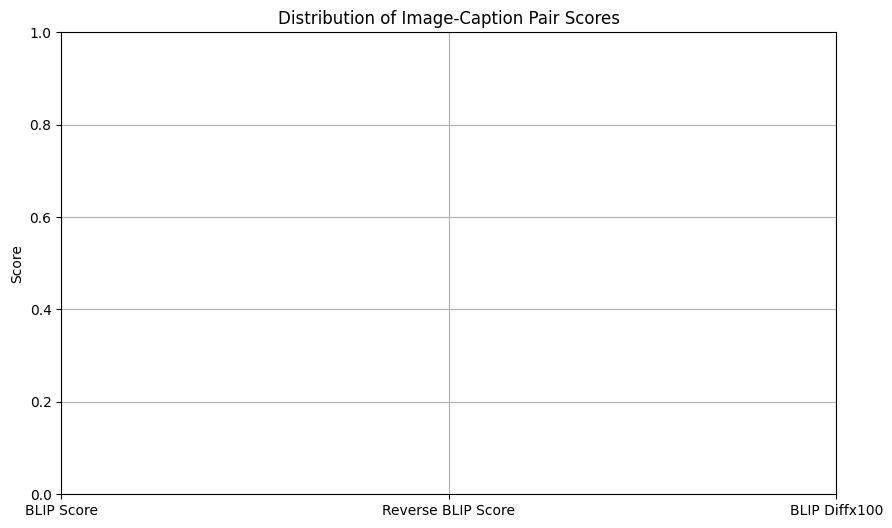

BLIP Score: Avrage:28.152008056640625 var: 154.3371124267578,  Reverse BLIP Score: avg:28.041433334350586 var:169.85928344726562,  BLIP Diff: avg:0.1105743944644928 var: 25.377565383911133


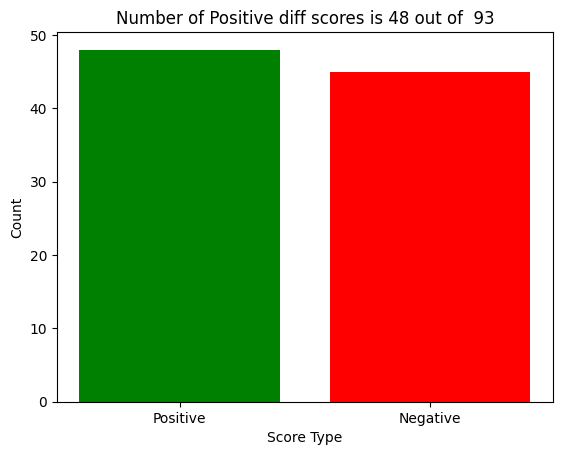

In [ ]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
model_id = ["nadavo11/actions_model", "nadavo11/actions_model5","nadavo11/ImSitu_actions_model"]
winoground_trained_dir = [None]  * len(model_id)
winoground_trained_json = [None] * len(model_id)
for j in range(len(model_id)):
  winoground_trained_dir[j] = f'{current_dir}/winoground_trained_{j}_evaluation'
  winoground_trained_json[j] = f'{winoground_trained_dir[j]}/image_data.json'
  evaluation(winoground_trained_dir[j],winoground_trained_json[j],metric ='blip', output_file_name = "blip_ouput")